참고
- https://dacon.io/competitions/official/235590/codeshare/1076?dtype=recent
- https://dacon.io/competitions/official/235590/codeshare/2458?dtype=recent
- https://dacon.io/competitions/official/235590/codeshare/997?page=4&dtype=recent

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

In [233]:
## 데이터 불러오기

Case = pd.read_csv('./Case.csv')
Patientinfo = pd.read_csv('./Patientinfo.csv')
Policy = pd.read_csv('./Policy.csv')
Region = pd.read_csv('./Region.csv')
SearchTrend = pd.read_csv('./SearchTrend.csv')
SeoulFloating = pd.read_csv('./SeoulFloating.csv')
Time = pd.read_csv('./Time.csv')
TimeAge = pd.read_csv('./TimeAge.csv')
TimeGender = pd.read_csv('./TimeGender.csv')
TimeProvince = pd.read_csv('./TimeProvince.csv')
Weather = pd.read_csv('./Weather.csv')

In [3]:
Policy['type'].unique()

array(['Alert', 'Immigration', 'Health', 'Social', 'Education',
       'Technology', 'Administrative', 'Transformation'], dtype=object)

In [4]:
Policy[Policy['type']=='Administrative']

policy_id country            type                              gov_policy  \
53         54   Korea  Administrative                    Close bars and clubs   
54         55   Korea  Administrative  local government Administrative orders   
55         56   Korea  Administrative                           Close karaoke   

                                               detail  start_date    end_date  
53       administrative order to close bars and clubs  2020-05-08  2020-06-07  
54  Gathering limited administrative orders for nu...  2020-05-16         NaN  
55  Ban on gathering for 2 weeks for all karaoke a...  2020-05-21  2020-06-03

---
### 제한 명령(Administrative)에 대한 세부 정책
    1. 술집 및 클럽 폐쇄 - 술집 및 클럽 폐쇄 행정명령
    2. 노래방 닫기 - 모든 가라오케와 코인 가라오케의 2주 동안 모임 금지
    3. 지방자치단체 행정명령 - 취약계층이 이용하는 요양원, 요양원, 노인어린이집, 정신병원에 대한 행정명령 제한수집
---
## 1. 술집 및 클럽 폐쇄 제한 명령에 대한 EDA
    : 주 이용객인 20-30대가 영향을 많이 받을 것으로 예상된다. 
      정책 시작일과 종료일 기준 +- 2주까지 비교

#### 술집 및 클럽 폐쇄 제한 명령 시작일(2020-05-08) 기준 일별 확진자 수

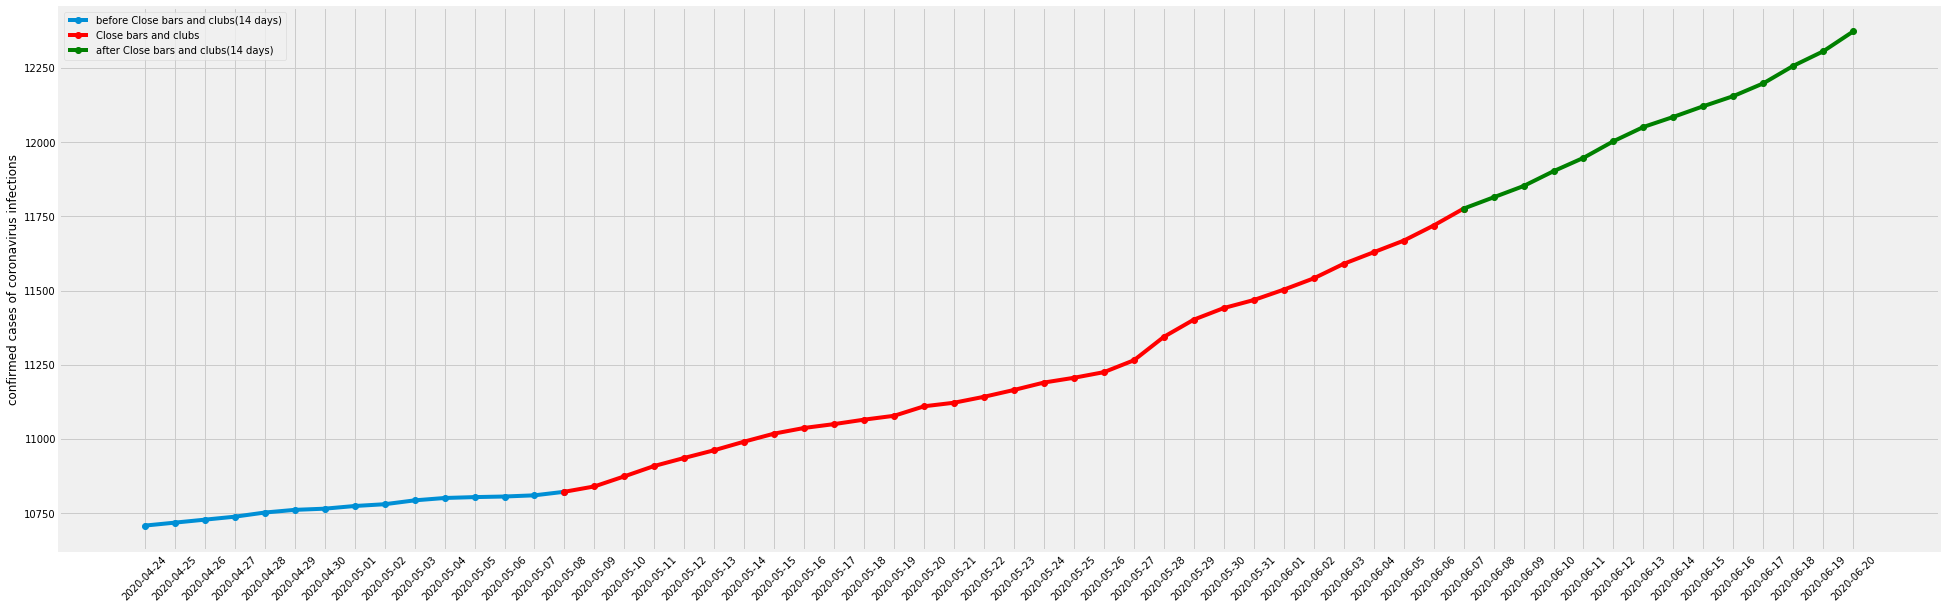

In [186]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 14일과 시행 이후 14일의 일별 확진자수를 시각화합니다.
date = Time['date'] #날짜 column
conNum = Time['confirmed'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 10] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 14일 동안의 확진자수 그래프 그리기
xbefore=date[95:110] # 4월 24일 ~ 5월 8일을 x축으로 지정
ybefore=conNum[95:110] # 4월 24일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', label='before Close bars and clubs(14 days)')

#술집 및 클럽 폐쇄 제한 명령동안의 확진자수 그래프 그리기
xing=date[109:140] # 5월 8일부터 6월 7일을 x축으로 지정
ying=conNum[109:140] # 5월 8일부터 6월 7일까지의 확진자수를 y축으로 지정
plt.plot(xing, ying, marker='o', color='r', label='Close bars and clubs')

#술집 및 클럽 폐쇄 제한 명령 종료 이후 일 동안의 확진자수 그래프 그리기
xafter=date[139:153] # 6월 7일부터 6월 21일을 x축으로 지정
yafter=conNum[139:153] # 6월 7일부터 6월 21일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', color='green', label='after Close bars and clubs(14 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.ylabel("confirmed cases of coronavirus infections")
plt.legend()
plt.show()

오히려 일별 확진자수 증가율이 상승하였다. 클럽과 주점의 주 이용자인 2-30대의 확진률을 살펴보자.  
(잠복기 등을 고려하여 시행 명령 이후 약 2주 후부터 시행 명령의 효과를 확인할 수 있다.)

In [6]:
Patientinfo[Patientinfo['infection_case']=='Itaewon Clubs']['age'].value_counts(normalize=True)*100

20s    50.000000
30s    30.769231
60s     7.692308
40s     3.846154
50s     3.846154
70s     3.846154
Name: age, dtype: float64

이태원 클럽 집단감염의 확진자 비율을 보았을 때, 20, 30대가 80% 이상을 차지한다. 그러므로, 술집 및 클럽 폐쇄 제한 명령의 실효성을 살펴보기 위해서는 2-30대 위주로 살펴보아야 한다.

#### 20대 일별 확진자 수

In [235]:
Patientinfo['age'] = Patientinfo["age"].str.replace('s',"") # 연령대 정렬을 위한 문자열 제거
    
pat_20 = Patientinfo[Patientinfo['age']== '20']
pat_20 = pat_20.sort_values(by=["confirmed_date", "contact_number"]) 
pat_20['confirmed_date'] = pd.to_datetime(pat_20['confirmed_date'], format = '%Y-%m-%d')
pat_20

patient_id     sex age country           province         city  \
3     1000000004    male  20   Korea              Seoul      Mapo-gu   
6     1000000007    male  20   Korea              Seoul    Jongno-gu   
4     1000000005  female  20   Korea              Seoul  Seongbuk-gu   
7     1000000008    male  20   Korea              Seoul          etc   
1601  1300000002  female  20   Korea            Gwangju          NaN   
...          ...     ...  ..     ...                ...          ...   
1632  1300000033    male  20   Korea            Gwangju          NaN   
3705  4100000167    male  20   Korea  Chungcheongnam-do      Asan-si   
4959  6022000051    male  20   Korea   Gyeongsangbuk-do  Chilgok-gun   
2104  1500000118  female  20   Korea            Daejeon      Dong-gu   
3706  4100000168     NaN  20   Korea  Chungcheongnam-do    Buyeo-gun   

            infection_case infected_by contact_number symptom_onset_date  \
3          overseas inflow         NaN              9         2020-01-26   
6     contact with patient  1000000003              0                NaN   
4     contact with patient  1000000002              2                NaN   
7          overseas inflow         NaN              0                NaN   
1601  contact with patient  1300000001              8                NaN   
...                    ...         ...            ...                ...   
1632                   etc         NaN            NaN                NaN   
3705       overseas inflow         NaN            NaN                NaN   
4959                   NaN         NaN            NaN                NaN   
2104       overseas inflow         NaN              0                NaN   
3706       overseas inflow         NaN              1                NaN   

     confirmed_date released_date deceased_date     state  
3        2020-01-30    2020-02-15           NaN  released  
6        2020-01-31    2020-02-10           NaN  released  
4        2020-01-31    2020-02-24           NaN  released  
7        2020-02-02    2020-02-24           NaN  released  
1601     2020-02-05    2020-02-20           NaN  released  
...             ...           ...           ...       ...  
1632     2020-06-27           NaN           NaN  isolated  
3705     2020-06-27           NaN           NaN  isolated  
4959     2020-06-28           NaN           NaN  isolated  
2104     2020-06-30           NaN           NaN  isolated  
3706     2020-06-30           NaN           NaN  isolated  

[899 rows x 14 columns]

In [8]:
conf_20 = pd.DataFrame(pat_20['confirmed_date'].value_counts())
conf_20.reset_index(inplace=True)
conf_20 = conf_20.sort_values(by=["index"]) 
conf_20

index  confirmed_date
0   2020-01-30               1
1   2020-01-31               2
2   2020-02-02               1
3   2020-02-05               1
4   2020-02-07               1
5   2020-02-18               2
6   2020-02-19               5
7   2020-02-20              10
8   2020-02-21               5
9   2020-02-22              20
10  2020-02-23              29
11  2020-02-24              15
12  2020-02-25              21
13  2020-02-26              30
14  2020-02-27              27
15  2020-02-28              32
16  2020-02-29              22
17  2020-03-01              35
18  2020-03-02              14
19  2020-03-03              43
20  2020-03-04              34
21  2020-03-05              32
22  2020-03-06              21
23  2020-03-07              13
24  2020-03-08              16
25  2020-03-09               6
26  2020-03-10              14
27  2020-03-11              10
28  2020-03-12               5
29  2020-03-13               8
30  2020-03-14               2
31  2020-03-15               4
32  2020-03-16              11
33  2020-03-17               8
34  2020-03-18              14
35  2020-03-19               3
36  2020-03-20               9
37  2020-03-21               8
38  2020-03-22               7
39  2020-03-23               9
40  2020-03-24              12
41  2020-03-25              18
42  2020-03-26              19
43  2020-03-27              12
44  2020-03-28              23
45  2020-03-29              17
46  2020-03-30              11
47  2020-03-31              24
48  2020-04-01              13
49  2020-04-02              13
50  2020-04-03              16
51  2020-04-04              14
52  2020-04-05              11
53  2020-04-06               4
54  2020-04-07               4
55  2020-04-08               6
56  2020-04-09               4
57  2020-04-10               4
58  2020-04-11               1
59  2020-04-12               2
60  2020-04-13               1
61  2020-04-14               3
62  2020-04-16               3
63  2020-04-17               1
64  2020-04-18               2
65  2020-04-19               2
66  2020-04-22               1
67  2020-04-23               1
68  2020-04-24               1
69  2020-04-25               4
70  2020-04-26               2
71  2020-04-27               2
72  2020-04-28               1
73  2020-04-29               1
74  2020-04-30               1
75  2020-05-02               2
76  2020-05-05               1
77  2020-05-06               1
78  2020-05-07               1
79  2020-05-08               2
80  2020-05-09               3
81  2020-05-10               1
82  2020-05-11               9
83  2020-05-12               3
84  2020-05-13               7
85  2020-05-14               4
86  2020-05-16               1
87  2020-05-17               1
88  2020-05-18               4
89  2020-05-19               8
90  2020-05-20               1
91  2020-05-21               3
92  2020-05-22               1
93  2020-05-23               1
94  2020-05-25               2
95  2020-05-27               4
96  2020-05-28               5
97  2020-05-29               5
98  2020-05-30               1
99  2020-06-02               1
100 2020-06-04               1
101 2020-06-05               1
102 2020-06-06               1
103 2020-06-08               1
104 2020-06-09               1
105 2020-06-12               1
106 2020-06-13               2
107 2020-06-15               1
108 2020-06-17               2
109 2020-06-18               1
110 2020-06-19               1
111 2020-06-21               1
112 2020-06-22               1
113 2020-06-23               2
114 2020-06-25               1
115 2020-06-27               2
116 2020-06-28               1
117 2020-06-30               2

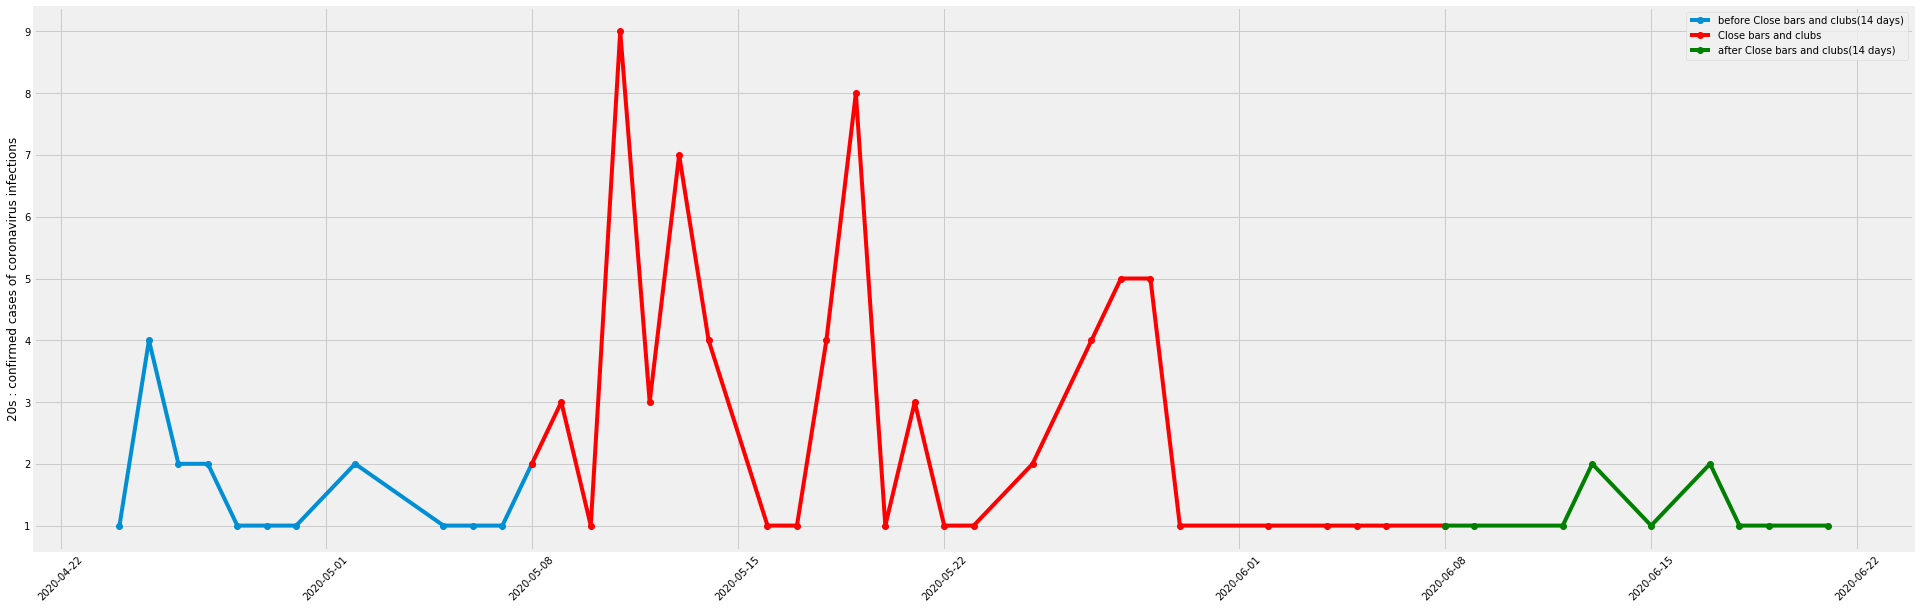

In [9]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 14일과 시행 이후 14일의 일별 확진자수를 시각화합니다.
date = conf_20['index'] #날짜 column
conNum = conf_20['confirmed_date'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 5] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 14일 동안의 확진자수 그래프 그리기
xbefore=date[68:80] # 4월 24일 ~ 5월 8일을 x축으로 지정
ybefore=conNum[68:80] # 4월 24일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', label='before Close bars and clubs(14 days)')

#술집 및 클럽 폐쇄 제한 명령동안의 확진자수 그래프 그리기
xing=date[79:104] # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 6월 7일을 x축으로 지정
ying=conNum[79:104] # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 6월 7일까지의 확진자수를 y축으로 지정
plt.plot(xing, ying, marker='o', color='r', label='Close bars and clubs')

#술집 및 클럽 폐쇄 제한 명령 종료 이후 일 동안의 확진자수 그래프 그리기
xafter=date[103:112] # 술집 및 클럽 폐쇄 제한 명령 시작일인 6월 7일부터 6월 21일을 x축으로 지정
yafter=conNum[103:112] # 술집 및 클럽 폐쇄 제한 명령 시작일인 6월 7일부터 6월 21일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', color='green', label='after Close bars and clubs(14 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.ylabel("20s : confirmed cases of coronavirus infections")
plt.legend()
plt.show()

In [10]:
conf_20[79:104].sort_values(by=["confirmed_date"], ascending=False) 

index  confirmed_date
82  2020-05-11               9
89  2020-05-19               8
84  2020-05-13               7
97  2020-05-29               5
96  2020-05-28               5
85  2020-05-14               4
95  2020-05-27               4
88  2020-05-18               4
91  2020-05-21               3
80  2020-05-09               3
83  2020-05-12               3
94  2020-05-25               2
79  2020-05-08               2
92  2020-05-22               1
93  2020-05-23               1
90  2020-05-20               1
87  2020-05-17               1
86  2020-05-16               1
81  2020-05-10               1
98  2020-05-30               1
99  2020-06-02               1
100 2020-06-04               1
101 2020-06-05               1
102 2020-06-06               1
103 2020-06-08               1

In [11]:
Patientinfo[Patientinfo['confirmed_date']=='2020-05-11']['infection_case'].value_counts()

Itaewon Clubs           14
contact with patient     7
overseas inflow          5
etc                      1
Name: infection_case, dtype: int64

일별 20대 확진자를 확인한 결과 확진자 수가 폭증한 일자를 확인할 수 있었다. 해당 경우를 자세히 살펴본 결과, 이태원 클럽 집단감염 확진자임을 알 수 있었다. 이태원 클럽 집단감염은 2020년 4월 30일에서 5월 5일 (황금연휴) 사이에 발생한 집단감염으로 술집 및 클럽 제한명령 시행일인 2020-05-08보다 앞선 시기에 발생했다. 해당 경우를 감안 시 해당 제한 명령은 효과적이었음을 알 수 있다. (+ 정책 시기는 조금 더 이르게 실행했어도 괜찮았을 것 같다)

#### 30대 일별 확진자 수

In [12]:
pat_30 = Patientinfo[Patientinfo['age']== '30']
pat_30 = pat_30.sort_values(by=["confirmed_date", "contact_number"]) 
pat_30['confirmed_date'] = pd.to_datetime(pat_30['confirmed_date'], format = '%Y-%m-%d')
pat_30

patient_id     sex age country           province         city  \
1644  1400000001  female  30   China            Incheon          etc   
1     1000000002    male  30   Korea              Seoul  Jungnang-gu   
2218  2000000006    male  30   Korea        Gyeonggi-do      Guri-si   
8     1000000009    male  30   Korea              Seoul    Songpa-gu   
2222  2000000010  female  30   China        Gyeonggi-do   Siheung-si   
...          ...     ...  ..     ...                ...          ...   
2091  1500000105    male  30   Korea            Daejeon      Dong-gu   
2093  1500000107    male  30   Korea            Daejeon   Daedeok-gu   
3538  4000000056    male  30   Korea  Chungcheongbuk-do  Okcheon-gun   
1637  1300000038  female  30   Korea            Gwangju          NaN   
5145  6100000133    male  30   Korea   Gyeongsangnam-do   Yangsan-si   

            infection_case infected_by contact_number symptom_onset_date  \
1644       overseas inflow         NaN            NaN         2020-01-19   
1          overseas inflow         NaN             31                NaN   
2218       overseas inflow         NaN            290                NaN   
8          overseas inflow         NaN             68                NaN   
2222       overseas inflow         NaN             40                NaN   
...                    ...         ...            ...                ...   
2091                   etc         NaN             21         2020-06-25   
2093  contact with patient  1500000105              8                NaN   
3538                   etc         NaN            NaN                NaN   
1637       overseas inflow         NaN            NaN                NaN   
5145       overseas inflow         NaN            NaN                NaN   

     confirmed_date released_date deceased_date     state  
1644     2020-01-20    2020-02-06           NaN  released  
1        2020-01-30    2020-03-02           NaN  released  
2218     2020-02-05    2020-02-12           NaN  released  
8        2020-02-05    2020-02-21           NaN  released  
2222     2020-02-09    2020-03-07           NaN  released  
...             ...           ...           ...       ...  
2091     2020-06-27           NaN           NaN  isolated  
2093     2020-06-27           NaN           NaN  isolated  
3538     2020-06-27           NaN           NaN  isolated  
1637     2020-06-28           NaN           NaN  isolated  
5145     2020-06-28           NaN           NaN  isolated  

[523 rows x 14 columns]

In [13]:
conf_30 = pd.DataFrame(pat_30['confirmed_date'].value_counts())
conf_30.reset_index(inplace=True)
conf_30 = conf_30.sort_values(by=["index"]) 
conf_30.reset_index(inplace=True, drop=True)
conf_30

index  confirmed_date
0   2020-01-20               1
1   2020-01-30               1
2   2020-02-05               2
3   2020-02-09               1
4   2020-02-10               1
5   2020-02-19               3
6   2020-02-20               6
7   2020-02-21               9
8   2020-02-22              11
9   2020-02-23               8
10  2020-02-24               8
11  2020-02-25              18
12  2020-02-26              17
13  2020-02-27              17
14  2020-02-28              17
15  2020-02-29              16
16  2020-03-01              12
17  2020-03-02              11
18  2020-03-03              11
19  2020-03-04               8
20  2020-03-05               9
21  2020-03-06              10
22  2020-03-07               3
23  2020-03-08               2
24  2020-03-09               8
25  2020-03-10              11
26  2020-03-11               3
27  2020-03-12               8
28  2020-03-13               5
29  2020-03-14               5
30  2020-03-15               4
31  2020-03-16               7
32  2020-03-17              11
33  2020-03-18              12
34  2020-03-19               6
35  2020-03-20               3
36  2020-03-21               4
37  2020-03-22               7
38  2020-03-23               1
39  2020-03-24              15
40  2020-03-25               5
41  2020-03-26               2
42  2020-03-27              11
43  2020-03-28              11
44  2020-03-29               5
45  2020-03-30               5
46  2020-03-31              12
47  2020-04-01               7
48  2020-04-02              11
49  2020-04-03              11
50  2020-04-04              11
51  2020-04-05               4
52  2020-04-06               1
53  2020-04-07               3
54  2020-04-08               2
55  2020-04-09               2
56  2020-04-10               1
57  2020-04-11               2
58  2020-04-13               2
59  2020-04-14               2
60  2020-04-15               3
61  2020-04-16               1
62  2020-04-17               2
63  2020-04-19               1
64  2020-04-21               2
65  2020-04-22               1
66  2020-04-24               1
67  2020-04-25               3
68  2020-04-26               1
69  2020-04-28               1
70  2020-04-30               1
71  2020-05-06               2
72  2020-05-07               4
73  2020-05-08               2
74  2020-05-09               2
75  2020-05-10               3
76  2020-05-11               2
77  2020-05-12               2
78  2020-05-13               2
79  2020-05-15               1
80  2020-05-16               3
81  2020-05-17               1
82  2020-05-20               3
83  2020-05-22               5
84  2020-05-23               4
85  2020-05-24               4
86  2020-05-25               1
87  2020-05-26               1
88  2020-05-27              13
89  2020-05-28               6
90  2020-05-30               1
91  2020-05-31               1
92  2020-06-02               1
93  2020-06-06               1
94  2020-06-07               1
95  2020-06-16               1
96  2020-06-19               5
97  2020-06-20               2
98  2020-06-21               1
99  2020-06-23               2
100 2020-06-25               1
101 2020-06-27               4
102 2020-06-28               2

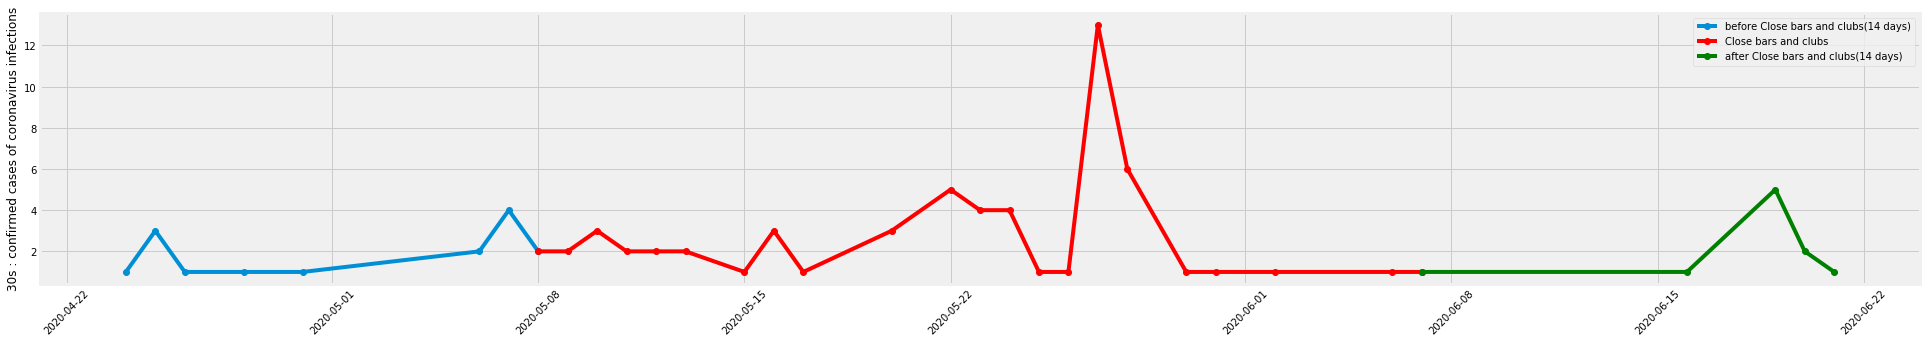

In [14]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 14일과 시행 이후 14일의 일별 확진자수를 시각화합니다.
date = conf_30['index'] #날짜 column
conNum = conf_30['confirmed_date'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 5] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 14일 동안의 확진자수 그래프 그리기
xbefore=date[66:74] # 4월 24일 ~ 5월 8일을 x축으로 지정
ybefore=conNum[66:74] # 4월 24일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', label='before Close bars and clubs(14 days)')

#술집 및 클럽 폐쇄 제한 명령동안의 확진자수 그래프 그리기
xing=date[73:95] # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 6월 7일을 x축으로 지정
ying=conNum[73:95] # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 6월 7일까지의 확진자수를 y축으로 지정
plt.plot(xing, ying, marker='o', color='r', label='Close bars and clubs')

#술집 및 클럽 폐쇄 제한 명령 종료 이후 일 동안의 확진자수 그래프 그리기
xafter=date[94:99] # 술집 및 클럽 폐쇄 제한 명령 시작일인 6월 7일부터 6월 21일을 x축으로 지정
yafter=conNum[94:99] # 술집 및 클럽 폐쇄 제한 명령 시작일인 6월 7일부터 6월 21일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', color='green', label='after Close bars and clubs(14 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.ylabel("30s : confirmed cases of coronavirus infections")
plt.legend()
plt.show()

In [15]:
Patientinfo[Patientinfo['confirmed_date']=='2020-05-27']['infection_case'].value_counts()

Coupang Logistics Center     45
contact with patient         16
Itaewon Clubs                 4
overseas inflow               4
Guri Collective Infection     2
KB Life Insurance             2
Name: infection_case, dtype: int64

30대의 경우 술집 및 클럽 제한 명령이 시행된 일자부터 확진자 수가 비교적 감소하다 잠시 2020-05-27에 확진자가 증가하였다. 확인 시 쿠팡 물류센터 집단감염임을 알 수 있었고, 집단 감염을 감안 시 해당 제한 명령은 효과적이었음을 알 수 있다.

---
### 구별 20대 유동인구 수
국세청 2020년 1월말 기준 사업자 현황에 따르면 
    
"간이주점"  
1. 마포구 (323)  
2. 강서구 (322)  
3. 양천구 (295)   
      
"호프전문점"  
1. 중랑구 (440)  
2. 마포구 (421)  
3. 영등포구 (386)  

#### SeoulFloating 전처리

In [16]:
SeoulFloating['date'] = pd.to_datetime(SeoulFloating['date'], format = '%Y-%m-%d')

In [17]:
# 시간 데이터를 pd.cut() 함수를 이용해 각각의 범주형 데이터로 변환
SeoulFloating["hour_cat"] = pd.cut(SeoulFloating["hour"], 
                              # 범주형 데이터의 구역 설정
                             bins=[-1, 6, 12, 18, np.inf], labels=["dawn","morning","afternoon","evening"])
SeoulFloating

date  hour  birth_year     sex province           city  fp_num  \
0       2020-01-01     0          20  female    Seoul      Dobong-gu   19140   
1       2020-01-01     0          20    male    Seoul      Dobong-gu   19950   
2       2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450   
3       2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050   
4       2020-01-01     0          20  female    Seoul     Dongjag-gu   28880   
...            ...   ...         ...     ...      ...            ...     ...   
1084795 2020-05-31    21          40  female    Seoul      Dobong-gu   27620   
1084796 2020-05-31    21          40  female    Seoul      Songpa-gu   56560   
1084797 2020-05-31    21          50  female    Seoul    Gangdong-gu   38960   
1084798 2020-05-31    22          60  female    Seoul        Guro-gu   25420   
1084799 2020-05-31    23          40    male    Seoul   Eunpyeong-gu   38650   

        hour_cat  
0           dawn  
1           dawn  
2           dawn  
3           dawn  
4           dawn  
...          ...  
1084795  evening  
1084796  evening  
1084797  evening  
1084798  evening  
1084799  evening  

[1084800 rows x 8 columns]

In [18]:
# 요일 컬럼 추가 (0:월 6:일)
SeoulFloating["day_of_week"] = SeoulFloating["date"].dt.weekday   
SeoulFloating

date  hour  birth_year     sex province           city  fp_num  \
0       2020-01-01     0          20  female    Seoul      Dobong-gu   19140   
1       2020-01-01     0          20    male    Seoul      Dobong-gu   19950   
2       2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450   
3       2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050   
4       2020-01-01     0          20  female    Seoul     Dongjag-gu   28880   
...            ...   ...         ...     ...      ...            ...     ...   
1084795 2020-05-31    21          40  female    Seoul      Dobong-gu   27620   
1084796 2020-05-31    21          40  female    Seoul      Songpa-gu   56560   
1084797 2020-05-31    21          50  female    Seoul    Gangdong-gu   38960   
1084798 2020-05-31    22          60  female    Seoul        Guro-gu   25420   
1084799 2020-05-31    23          40    male    Seoul   Eunpyeong-gu   38650   

        hour_cat  day_of_week  
0           dawn            2  
1           dawn            2  
2           dawn            2  
3           dawn            2  
4           dawn            2  
...          ...          ...  
1084795  evening            6  
1084796  evening            6  
1084797  evening            6  
1084798  evening            6  
1084799  evening            6  

[1084800 rows x 9 columns]

In [19]:
SeoulFloating['city'].unique()

array(['Dobong-gu', 'Dongdaemun-gu', 'Dongjag-gu', 'Eunpyeong-gu',
       'Gangbuk-gu', 'Gangdong-gu', 'Gangnam-gu', 'Gangseo-gu',
       'Geumcheon-gu', 'Guro-gu', 'Gwanak-gu', 'Gwangjin-gu', 'Jongno-gu',
       'Jung-gu', 'Jungnang-gu', 'Mapo-gu', 'Nowon-gu', 'Seocho-gu',
       'Seodaemun-gu', 'Seongbuk-gu', 'Seongdong-gu', 'Songpa-gu',
       'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu'], dtype=object)

#### 간이주점 Top 3인 마포구, 강서구, 양천구의 20대 유동인구 (일자별)

In [20]:
age_20 = SeoulFloating[SeoulFloating['birth_year'] == 20]
city_20 = age_20.groupby(['city', 'date'])['fp_num'].sum()
df_city20 = city_20.to_frame()

In [21]:
df_city20

fp_num
city       date              
Dobong-gu  2020-01-01  977520
           2020-01-02  905800
           2020-01-03  891450
           2020-01-04  947900
           2020-01-05  980820
...                       ...
Yongsan-gu 2020-05-27  890110
           2020-05-28  895280
           2020-05-29  635140
           2020-05-30  863570
           2020-05-31  842760

[3775 rows x 1 columns]

In [22]:
df_city20 = df_city20.reset_index()
df_city20

city       date  fp_num
0      Dobong-gu 2020-01-01  977520
1      Dobong-gu 2020-01-02  905800
2      Dobong-gu 2020-01-03  891450
3      Dobong-gu 2020-01-04  947900
4      Dobong-gu 2020-01-05  980820
...          ...        ...     ...
3770  Yongsan-gu 2020-05-27  890110
3771  Yongsan-gu 2020-05-28  895280
3772  Yongsan-gu 2020-05-29  635140
3773  Yongsan-gu 2020-05-30  863570
3774  Yongsan-gu 2020-05-31  842760

[3775 rows x 3 columns]

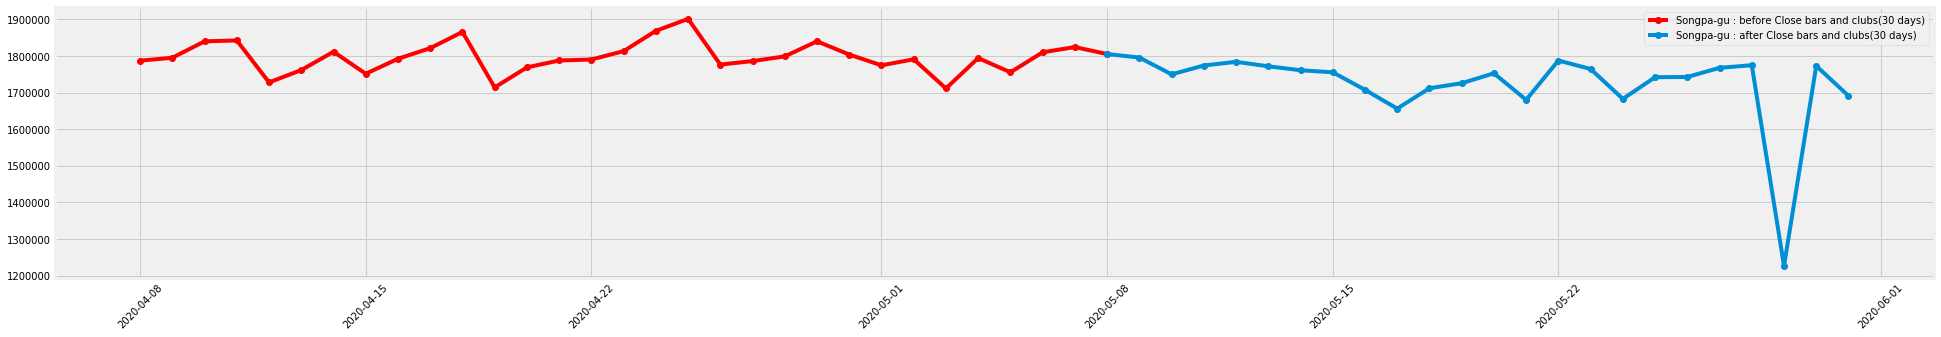

In [23]:
##마포구
Mapo = df_city20[df_city20['city'] == 'Mapo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

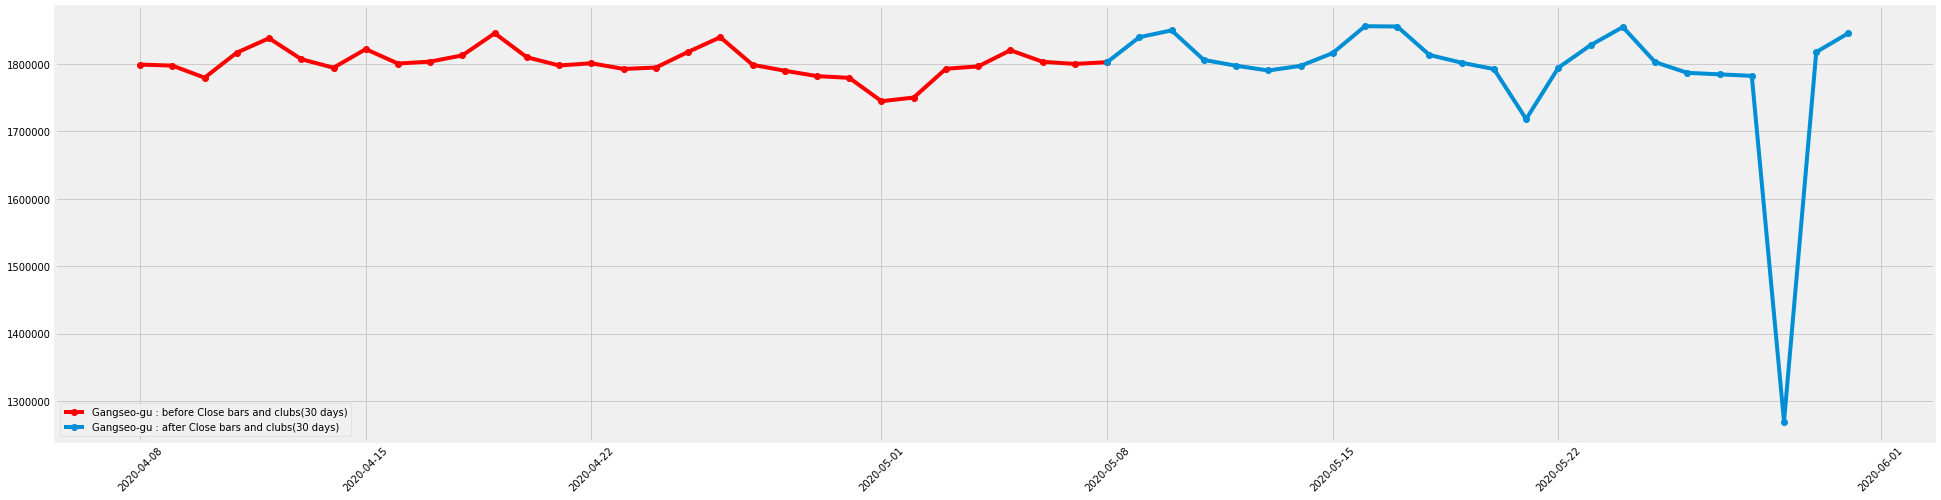

In [24]:
##강서구
Gangseo = df_city20[df_city20['city'] == 'Gangseo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Gangseo['date'].loc[1154:1184] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Gangseo['fp_num'].loc[1154:1184] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Gangseo['date'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Gangseo['fp_num'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Gangseo-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

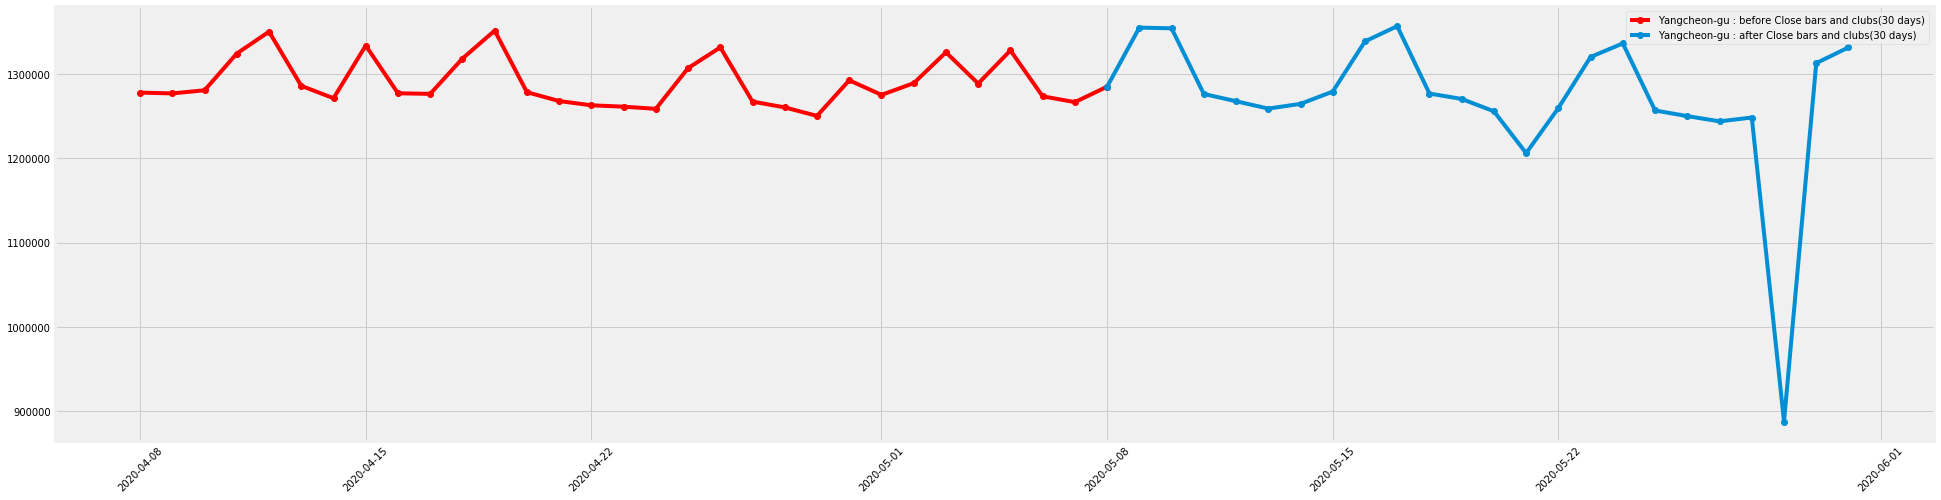

In [25]:
##양천구
Yangcheon = df_city20[df_city20['city'] == 'Yangcheon-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Yangcheon['date'].loc[3419:3449] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Yangcheon['fp_num'].loc[3419:3449] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Yangcheon['date'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Yangcheon['fp_num'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 3지역의 유동인구 수 

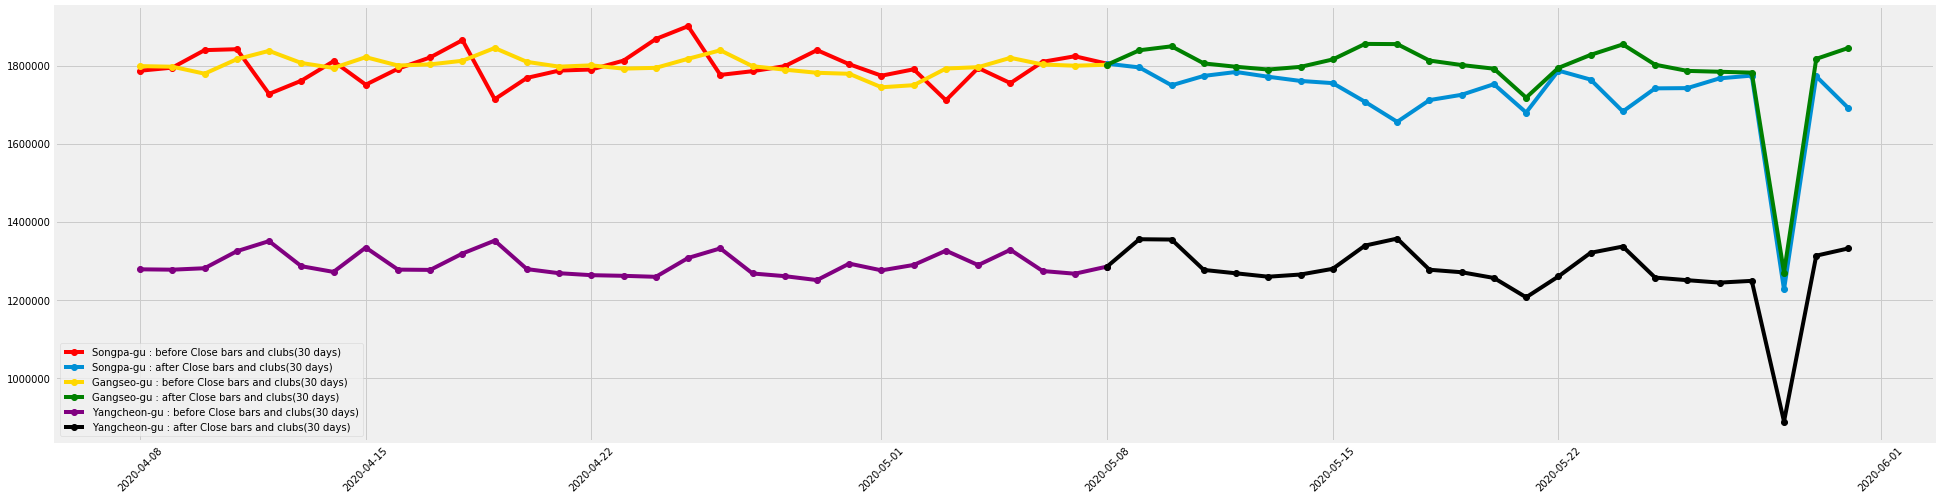

In [26]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Gangseo['date'].loc[1154:1184] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Gangseo['fp_num'].loc[1154:1184] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Gangseo['date'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Gangseo['fp_num'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Yangcheon['date'].loc[3419:3449] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Yangcheon['fp_num'].loc[3419:3449] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Yangcheon['date'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Yangcheon['fp_num'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 간이주점 Top 3인 마포구, 강서구, 양천구의 20대 유동인구 (시간대 별)

In [27]:
##마포구
Mapo_hour = age_20[age_20['city'] == 'Mapo-gu']
Mapo_hour = Mapo_hour.sort_values(by=["date", "hour"]) 
Mapo_hour.reset_index(inplace=True)
Mapo_hour

index       date  hour  birth_year     sex province     city  fp_num  \
0          30 2020-01-01     0          20  female    Seoul  Mapo-gu   39280   
1          31 2020-01-01     0          20    male    Seoul  Mapo-gu   39820   
2          80 2020-01-01     1          20  female    Seoul  Mapo-gu   38580   
3          81 2020-01-01     1          20    male    Seoul  Mapo-gu   39200   
4         130 2020-01-01     2          20  female    Seoul  Mapo-gu   37540   
...       ...        ...   ...         ...     ...      ...      ...     ...   
7227  1022668 2020-05-31    21          20    male    Seoul  Mapo-gu   34030   
7228  1008495 2020-05-31    22          20  female    Seoul  Mapo-gu   35620   
7229  1024706 2020-05-31    22          20    male    Seoul  Mapo-gu   31620   
7230   968295 2020-05-31    23          20  female    Seoul  Mapo-gu   34270   
7231  1066712 2020-05-31    23          20    male    Seoul  Mapo-gu   30590   

     hour_cat  day_of_week  
0        dawn            2  
1        dawn            2  
2        dawn            2  
3        dawn            2  
4        dawn            2  
...       ...          ...  
7227  evening            6  
7228  evening            6  
7229  evening            6  
7230  evening            6  
7231  evening            6  

[7232 rows x 10 columns]

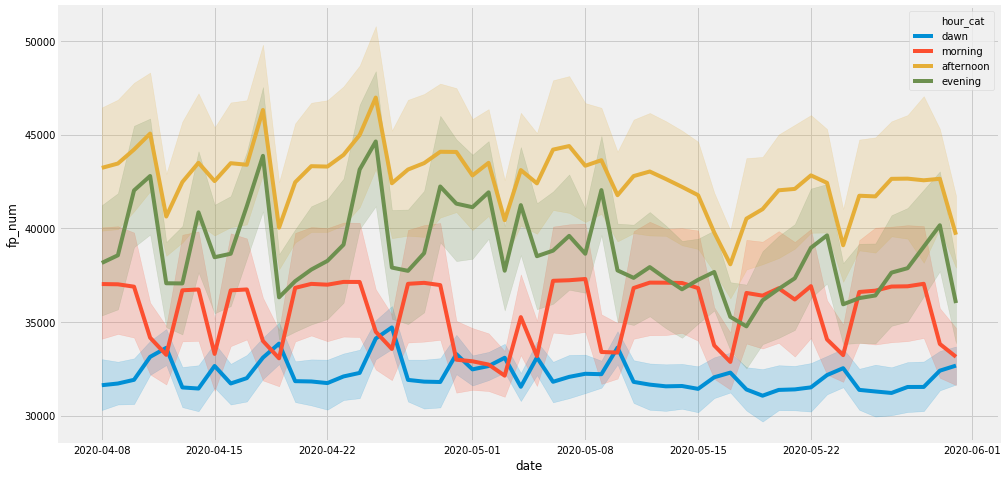

In [28]:
drunk_mapo = Mapo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_mapo, x='date', y="fp_num", hue="hour_cat")

주점을 주로 이용하는 시간인 저녁시간대 마포구 유동인구가 감소하였다.

In [29]:
##강서구
Gangseo_hour = age_20[age_20['city'] == 'Gangseo-gu']
Gangseo_hour = Gangseo_hour.sort_values(by=["date", "hour"]) 
Gangseo_hour.reset_index(inplace=True)
Gangseo_hour

index       date  hour  birth_year     sex province        city  \
0          14 2020-01-01     0          20  female    Seoul  Gangseo-gu   
1          15 2020-01-01     0          20    male    Seoul  Gangseo-gu   
2          64 2020-01-01     1          20  female    Seoul  Gangseo-gu   
3          65 2020-01-01     1          20    male    Seoul  Gangseo-gu   
4         114 2020-01-01     2          20  female    Seoul  Gangseo-gu   
...       ...        ...   ...         ...     ...      ...         ...   
7227   898182 2020-05-31    21          20  female    Seoul  Gangseo-gu   
7228   974243 2020-05-31    22          20  female    Seoul  Gangseo-gu   
7229  1064725 2020-05-31    22          20    male    Seoul  Gangseo-gu   
7230   910042 2020-05-31    23          20    male    Seoul  Gangseo-gu   
7231  1026739 2020-05-31    23          20  female    Seoul  Gangseo-gu   

      fp_num hour_cat  day_of_week  
0      37780     dawn            2  
1      38300     dawn            2  
2      38390     dawn            2  
3      38630     dawn            2  
4      38350     dawn            2  
...      ...      ...          ...  
7227   39630  evening            6  
7228   40120  evening            6  
7229   37250  evening            6  
7230   37750  evening            6  
7231   40640  evening            6  

[7232 rows x 10 columns]

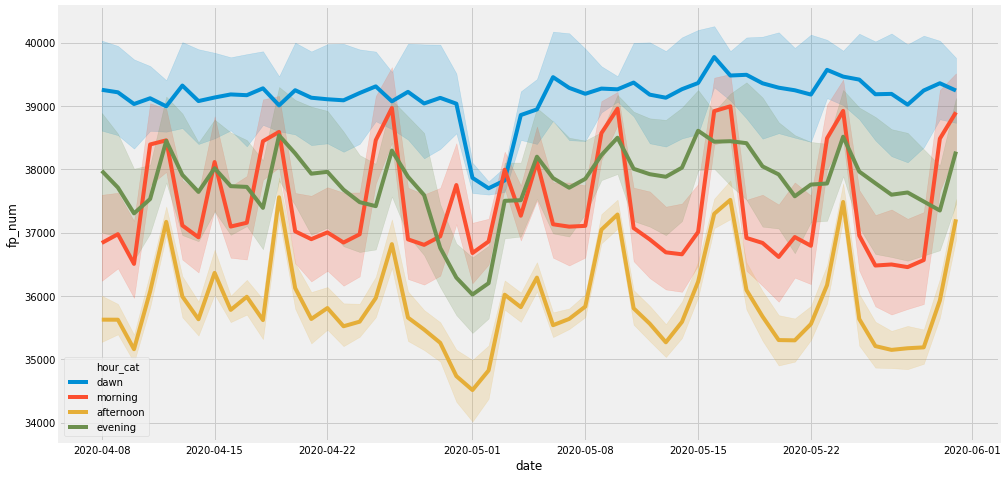

In [30]:
drunk_gangseo = Gangseo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_gangseo, x='date', y="fp_num", hue="hour_cat")

In [31]:
##양천구
Yangcheon_hour = age_20[age_20['city'] == 'Yangcheon-gu']
Yangcheon_hour = Yangcheon_hour.sort_values(by=["date", "hour"]) 
Yangcheon_hour.reset_index(inplace=True)
Yangcheon_hour

index       date  hour  birth_year     sex province          city  \
0          44 2020-01-01     0          20  female    Seoul  Yangcheon-gu   
1          45 2020-01-01     0          20    male    Seoul  Yangcheon-gu   
2          94 2020-01-01     1          20  female    Seoul  Yangcheon-gu   
3          95 2020-01-01     1          20    male    Seoul  Yangcheon-gu   
4         144 2020-01-01     2          20  female    Seoul  Yangcheon-gu   
...       ...        ...   ...         ...     ...      ...           ...   
7227  1000349 2020-05-31    21          20  female    Seoul  Yangcheon-gu   
7228   876020 2020-05-31    22          20  female    Seoul  Yangcheon-gu   
7229  1082835 2020-05-31    22          20    male    Seoul  Yangcheon-gu   
7230   928233 2020-05-31    23          20  female    Seoul  Yangcheon-gu   
7231   972293 2020-05-31    23          20    male    Seoul  Yangcheon-gu   

      fp_num hour_cat  day_of_week  
0      27210     dawn            2  
1      29620     dawn            2  
2      27670     dawn            2  
3      29890     dawn            2  
4      28030     dawn            2  
...      ...      ...          ...  
7227   27070  evening            6  
7228   27880  evening            6  
7229   28930  evening            6  
7230   28270  evening            6  
7231   29060  evening            6  

[7232 rows x 10 columns]

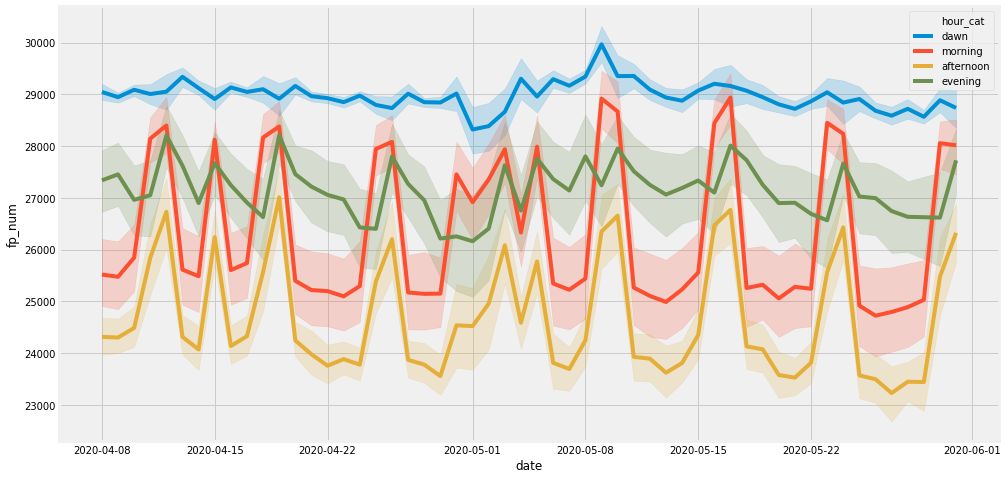

In [32]:
drunk_yangcheon = Yangcheon_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_yangcheon, x='date', y="fp_num", hue="hour_cat")

---
#### 호프전문점 Top 3인 중랑구, 마포구, 영등포구의 20대 유동인구 (일자별)

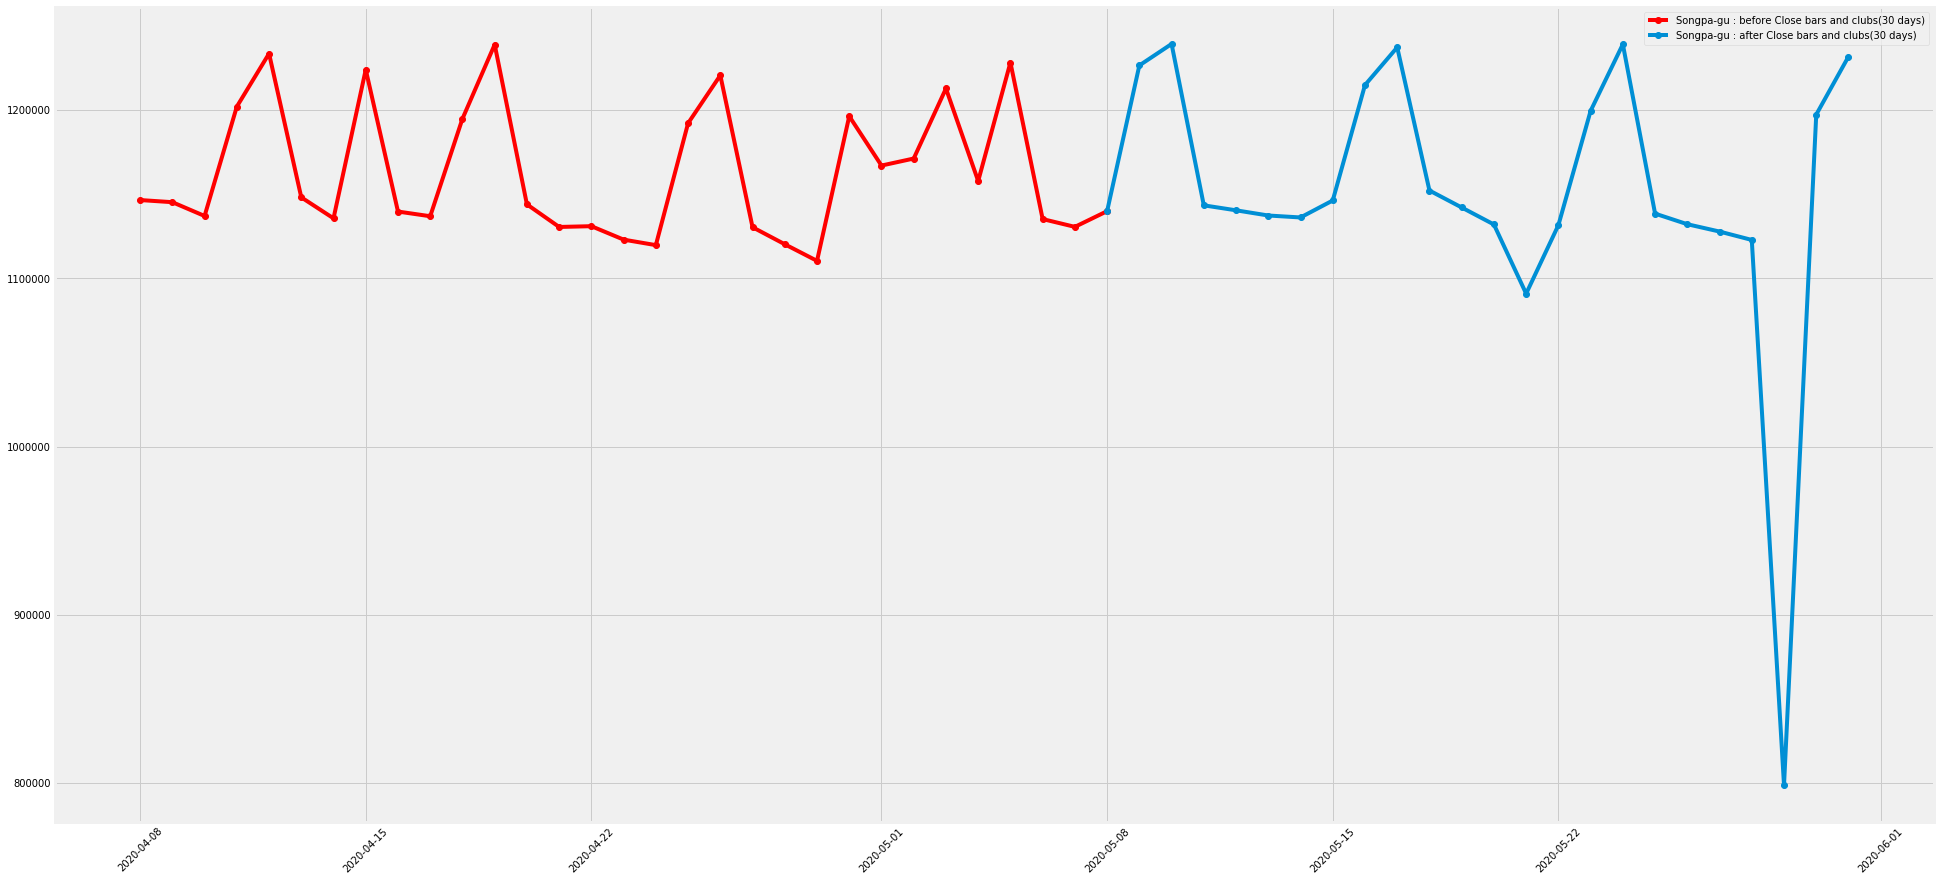

In [33]:
##중랑구
Jungnang = df_city20[df_city20['city'] == 'Jungnang-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Jungnang['date'].loc[2211:2241] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Jungnang['fp_num'].loc[2211:2241] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Jungnang['date'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Jungnang['fp_num'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

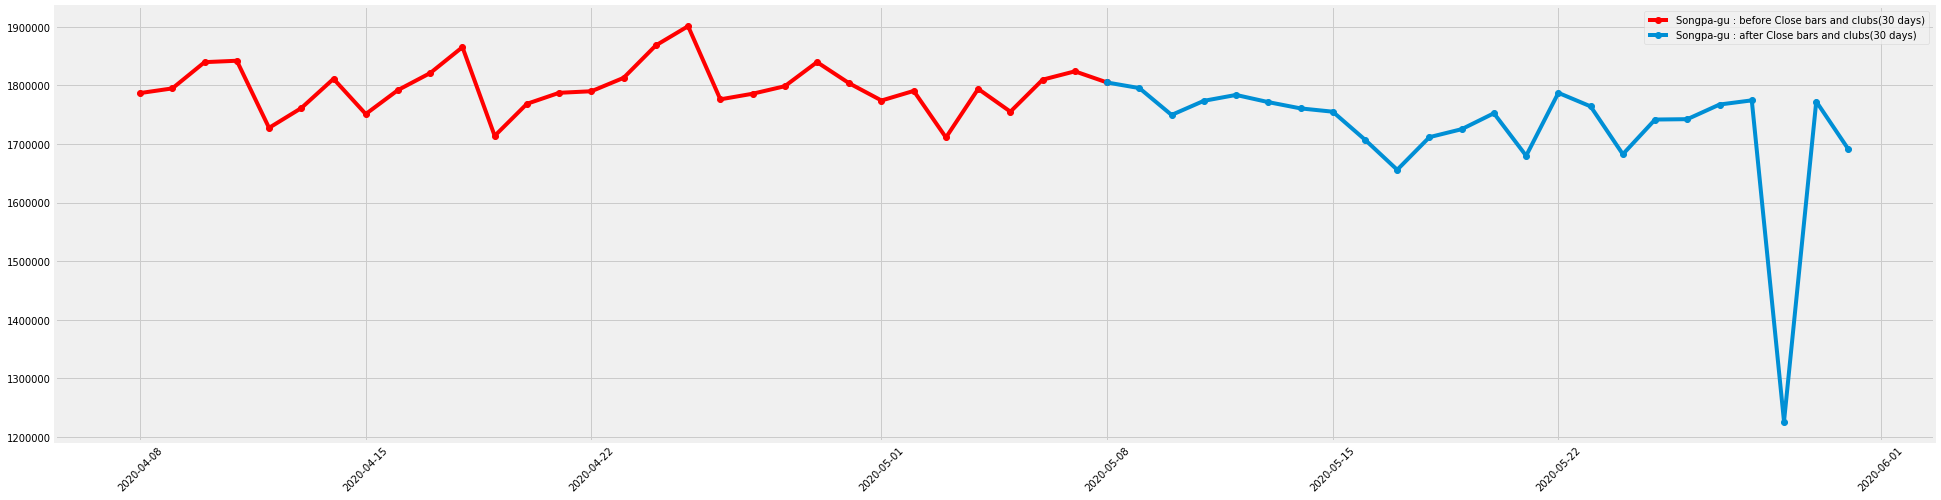

In [34]:
##마포구
Mapo = df_city20[df_city20['city'] == 'Mapo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

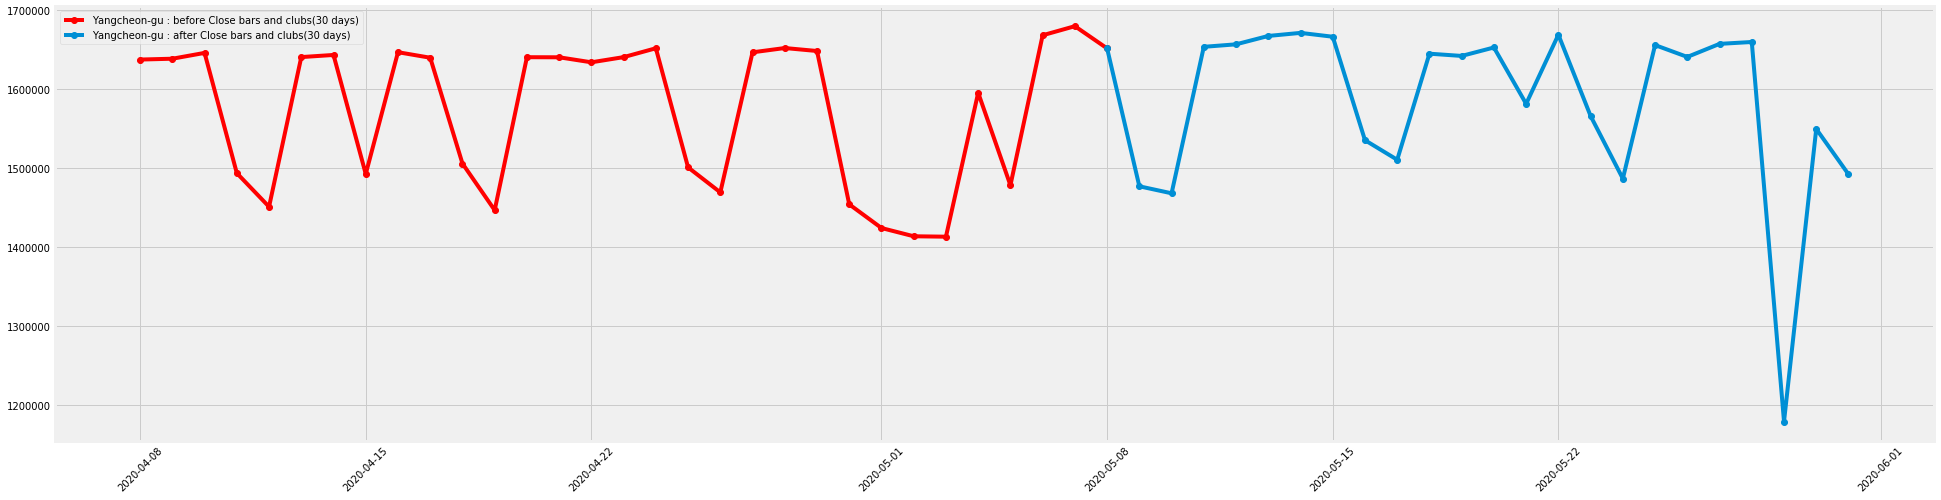

In [35]:
##영등포구
Yeongdeungpo = df_city20[df_city20['city'] == 'Yeongdeungpo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Yeongdeungpo['date'].loc[3570:3600] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Yeongdeungpo['fp_num'].loc[3570:3600] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Yeongdeungpo['date'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Yeongdeungpo['fp_num'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 3지역의 유동인구 수 

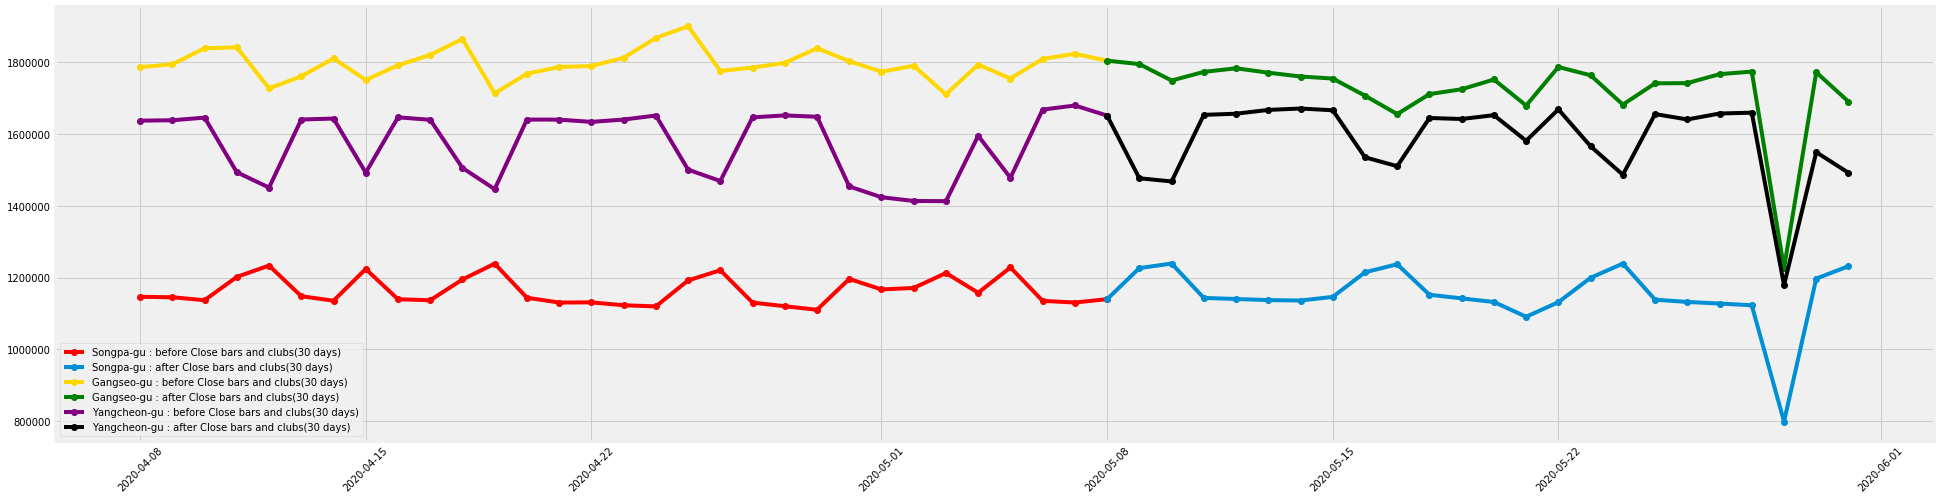

In [36]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Jungnang['date'].loc[2211:2241] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Jungnang['fp_num'].loc[2211:2241] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Jungnang['date'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Jungnang['fp_num'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Yeongdeungpo['date'].loc[3570:3600] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Yeongdeungpo['fp_num'].loc[3570:3600] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Yeongdeungpo['date'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Yeongdeungpo['fp_num'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 호프전문점 Top 3인 중랑구, 마포구, 영등포구의 20대 유동인구 (시간대별)

In [37]:
##마포구
Jungnang_hour = age_20[age_20['city'] == 'Jungnang-gu']
Jungnang_hour = Jungnang_hour.sort_values(by=["date", "hour"]) 
Jungnang_hour.reset_index(inplace=True)
Jungnang_hour

index       date  hour  birth_year     sex province         city  \
0          28 2020-01-01     0          20  female    Seoul  Jungnang-gu   
1          29 2020-01-01     0          20    male    Seoul  Jungnang-gu   
2          78 2020-01-01     1          20  female    Seoul  Jungnang-gu   
3          79 2020-01-01     1          20    male    Seoul  Jungnang-gu   
4         128 2020-01-01     2          20  female    Seoul  Jungnang-gu   
...       ...        ...   ...         ...     ...      ...          ...   
7227  1028684 2020-05-31    21          20    male    Seoul  Jungnang-gu   
7228   972292 2020-05-31    22          20  female    Seoul  Jungnang-gu   
7229   980224 2020-05-31    22          20    male    Seoul  Jungnang-gu   
7230   876023 2020-05-31    23          20    male    Seoul  Jungnang-gu   
7231   990328 2020-05-31    23          20  female    Seoul  Jungnang-gu   

      fp_num hour_cat  day_of_week  
0      23820     dawn            2  
1      25030     dawn            2  
2      24440     dawn            2  
3      25490     dawn            2  
4      24880     dawn            2  
...      ...      ...          ...  
7227   25660  evening            6  
7228   26920  evening            6  
7229   26460  evening            6  
7230   26880  evening            6  
7231   27350  evening            6  

[7232 rows x 10 columns]

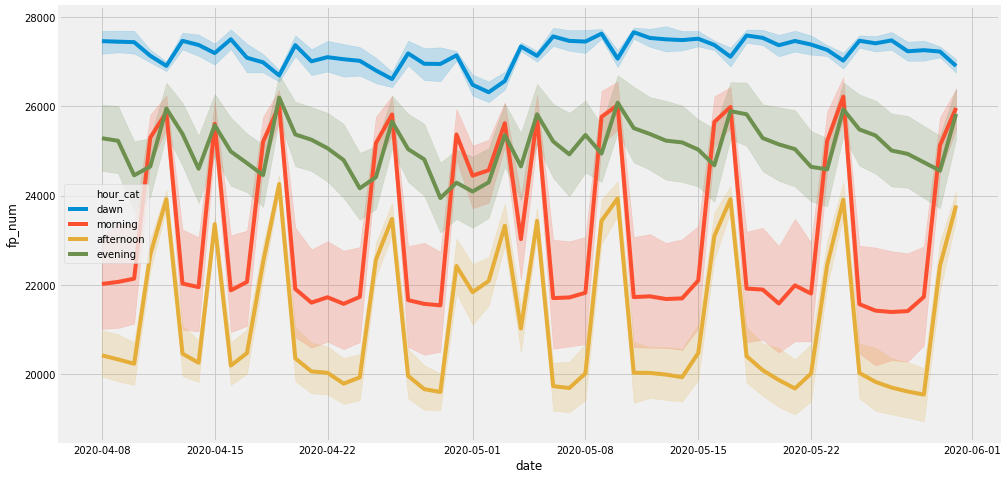

In [38]:
drunk_jungnang = Jungnang_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_jungnang, x='date', y="fp_num", hue="hour_cat")

In [39]:
##마포구
Mapo_hour = age_20[age_20['city'] == 'Mapo-gu']
Mapo_hour = Mapo_hour.sort_values(by=["date", "hour"]) 
Mapo_hour.reset_index(inplace=True)
Mapo_hour

index       date  hour  birth_year     sex province     city  fp_num  \
0          30 2020-01-01     0          20  female    Seoul  Mapo-gu   39280   
1          31 2020-01-01     0          20    male    Seoul  Mapo-gu   39820   
2          80 2020-01-01     1          20  female    Seoul  Mapo-gu   38580   
3          81 2020-01-01     1          20    male    Seoul  Mapo-gu   39200   
4         130 2020-01-01     2          20  female    Seoul  Mapo-gu   37540   
...       ...        ...   ...         ...     ...      ...      ...     ...   
7227  1022668 2020-05-31    21          20    male    Seoul  Mapo-gu   34030   
7228  1008495 2020-05-31    22          20  female    Seoul  Mapo-gu   35620   
7229  1024706 2020-05-31    22          20    male    Seoul  Mapo-gu   31620   
7230   968295 2020-05-31    23          20  female    Seoul  Mapo-gu   34270   
7231  1066712 2020-05-31    23          20    male    Seoul  Mapo-gu   30590   

     hour_cat  day_of_week  
0        dawn            2  
1        dawn            2  
2        dawn            2  
3        dawn            2  
4        dawn            2  
...       ...          ...  
7227  evening            6  
7228  evening            6  
7229  evening            6  
7230  evening            6  
7231  evening            6  

[7232 rows x 10 columns]

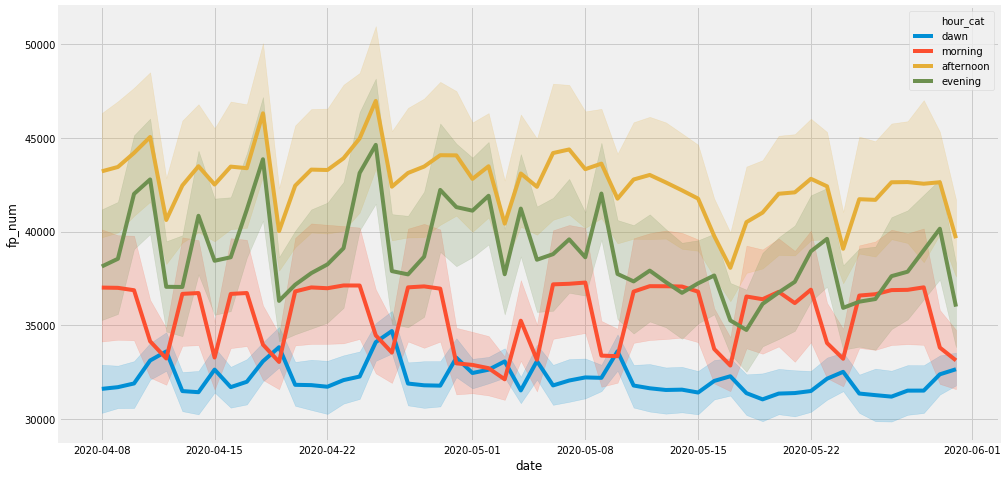

In [40]:
drunk_mapo = Mapo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_mapo, x='date', y="fp_num", hue="hour_cat")

In [41]:
##영등포구
Yeongdeungpo_hour = age_20[age_20['city'] == 'Yeongdeungpo-gu']
Yeongdeungpo_hour = Yeongdeungpo_hour.sort_values(by=["date", "hour"]) 
Yeongdeungpo_hour.reset_index(inplace=True)
Yeongdeungpo_hour

index       date  hour  birth_year     sex province             city  \
0          46 2020-01-01     0          20  female    Seoul  Yeongdeungpo-gu   
1          47 2020-01-01     0          20    male    Seoul  Yeongdeungpo-gu   
2          96 2020-01-01     1          20  female    Seoul  Yeongdeungpo-gu   
3          97 2020-01-01     1          20    male    Seoul  Yeongdeungpo-gu   
4         146 2020-01-01     2          20  female    Seoul  Yeongdeungpo-gu   
...       ...        ...   ...         ...     ...      ...              ...   
7227  1028683 2020-05-31    21          20    male    Seoul  Yeongdeungpo-gu   
7228   892248 2020-05-31    22          20  female    Seoul  Yeongdeungpo-gu   
7229  1070671 2020-05-31    22          20    male    Seoul  Yeongdeungpo-gu   
7230  1030758 2020-05-31    23          20  female    Seoul  Yeongdeungpo-gu   
7231  1070677 2020-05-31    23          20    male    Seoul  Yeongdeungpo-gu   

      fp_num hour_cat  day_of_week  
0      30130     dawn            2  
1      29670     dawn            2  
2      29240     dawn            2  
3      28860     dawn            2  
4      28710     dawn            2  
...      ...      ...          ...  
7227   30410  evening            6  
7228   30930  evening            6  
7229   29530  evening            6  
7230   29990  evening            6  
7231   28690  evening            6  

[7232 rows x 10 columns]

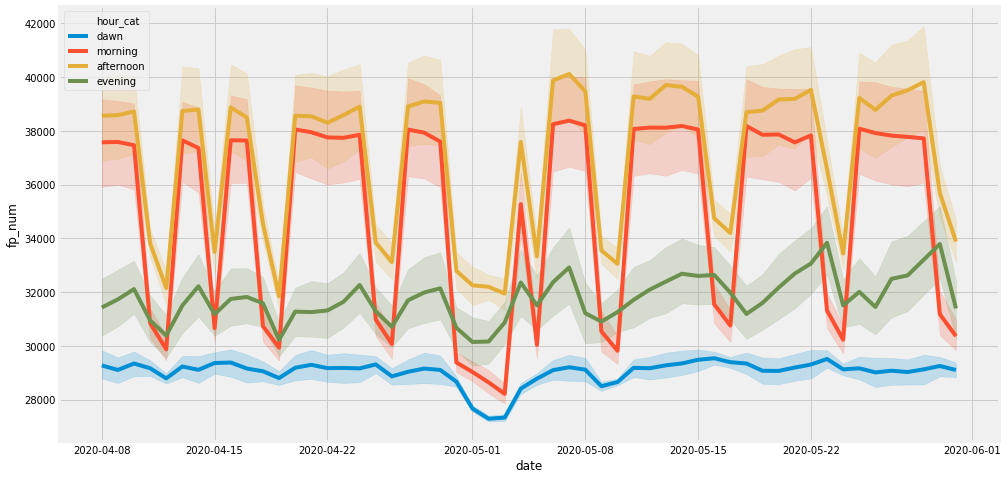

In [42]:
drunk_yeongdeungpo = Yeongdeungpo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_yeongdeungpo, x='date', y="fp_num", hue="hour_cat")

---

#### 간이주점 Top 3인 마포구, 강서구, 양천구의 30대 유동인구 (일자별)

In [43]:
age_30 = SeoulFloating[SeoulFloating['birth_year'] == 30]
city_30 = age_30.groupby(['city', 'date'])['fp_num'].sum()
df_city30 = city_30.to_frame()

In [44]:
df_city30

fp_num
city       date               
Dobong-gu  2020-01-01  1052420
           2020-01-02   894810
           2020-01-03   878730
           2020-01-04   988080
           2020-01-05  1039590
...                        ...
Yongsan-gu 2020-05-27  1147930
           2020-05-28  1146580
           2020-05-29   812180
           2020-05-30  1018370
           2020-05-31   991860

[3775 rows x 1 columns]

In [45]:
df_city30 = df_city30.reset_index()
df_city30

city       date   fp_num
0      Dobong-gu 2020-01-01  1052420
1      Dobong-gu 2020-01-02   894810
2      Dobong-gu 2020-01-03   878730
3      Dobong-gu 2020-01-04   988080
4      Dobong-gu 2020-01-05  1039590
...          ...        ...      ...
3770  Yongsan-gu 2020-05-27  1147930
3771  Yongsan-gu 2020-05-28  1146580
3772  Yongsan-gu 2020-05-29   812180
3773  Yongsan-gu 2020-05-30  1018370
3774  Yongsan-gu 2020-05-31   991860

[3775 rows x 3 columns]

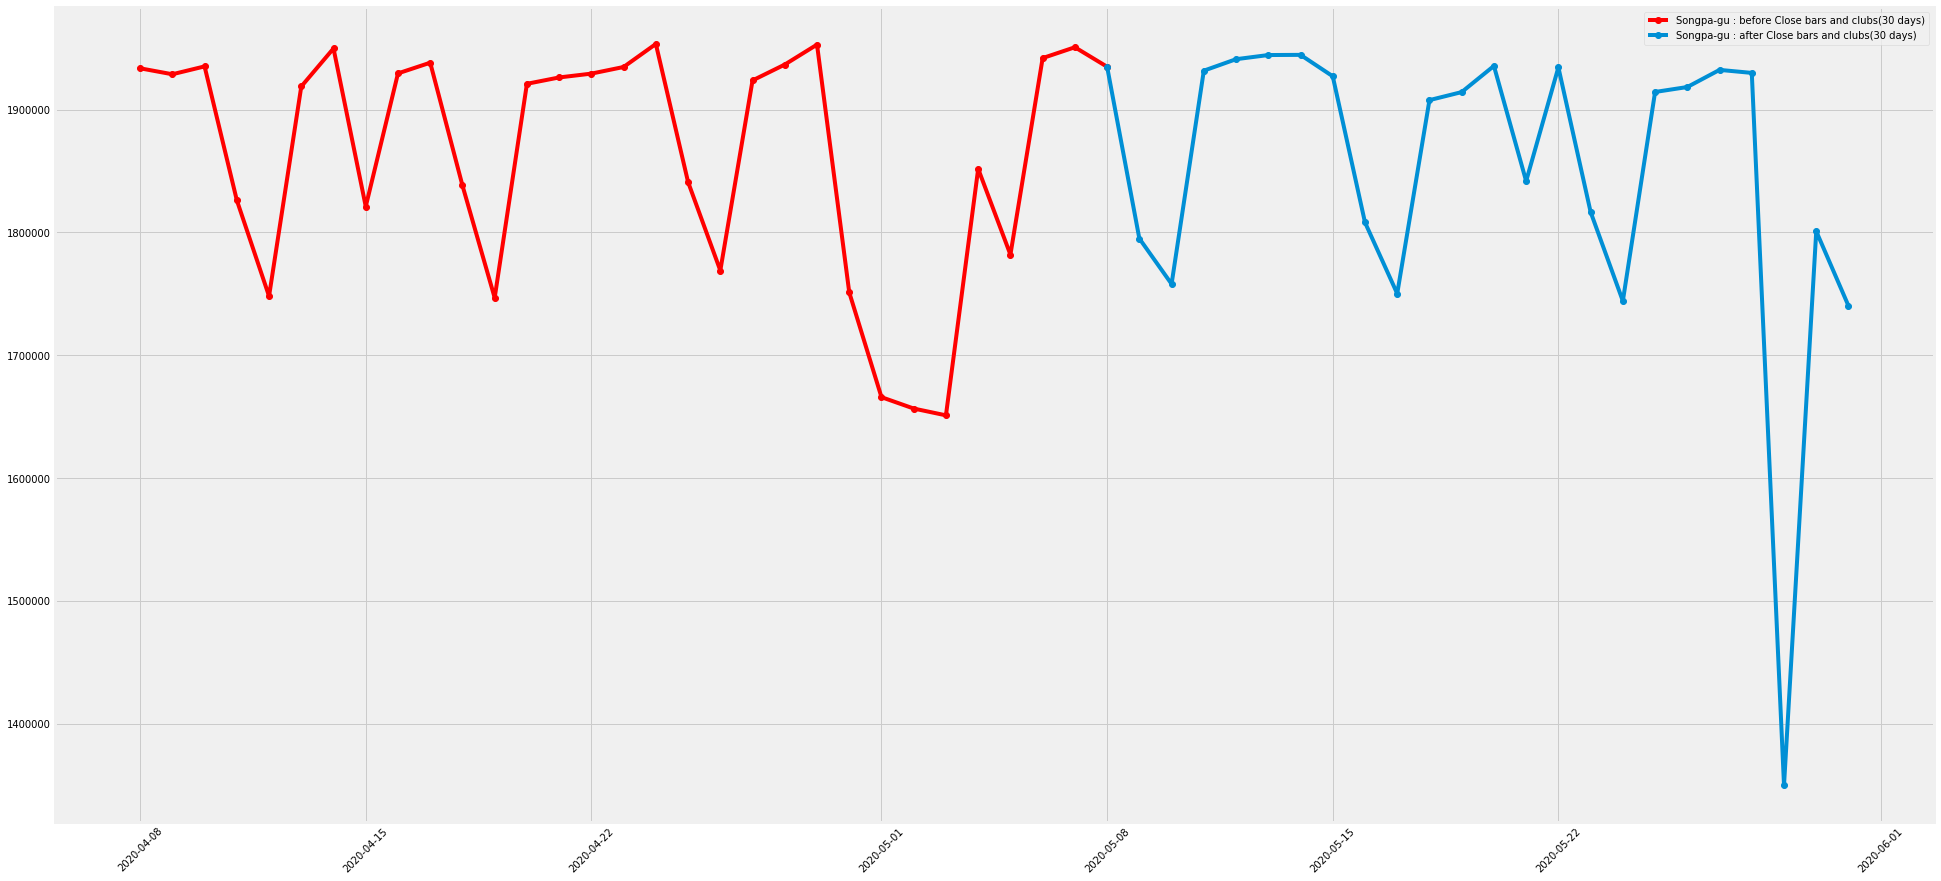

In [46]:
##마포구
Mapo = df_city30[df_city30['city'] == 'Mapo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

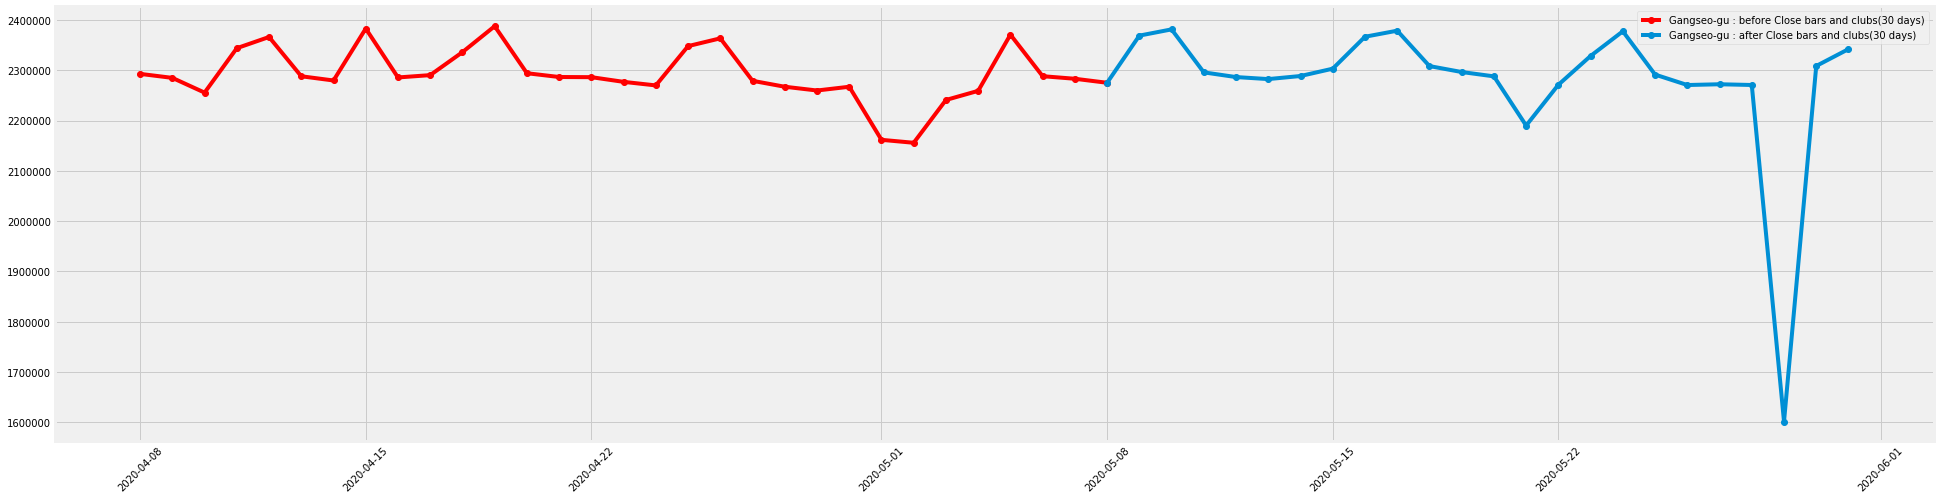

In [47]:
##강서구
Gangseo = df_city30[df_city30['city'] == 'Gangseo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Gangseo['date'].loc[1154:1184] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Gangseo['fp_num'].loc[1154:1184] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Gangseo['date'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Gangseo['fp_num'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Gangseo-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

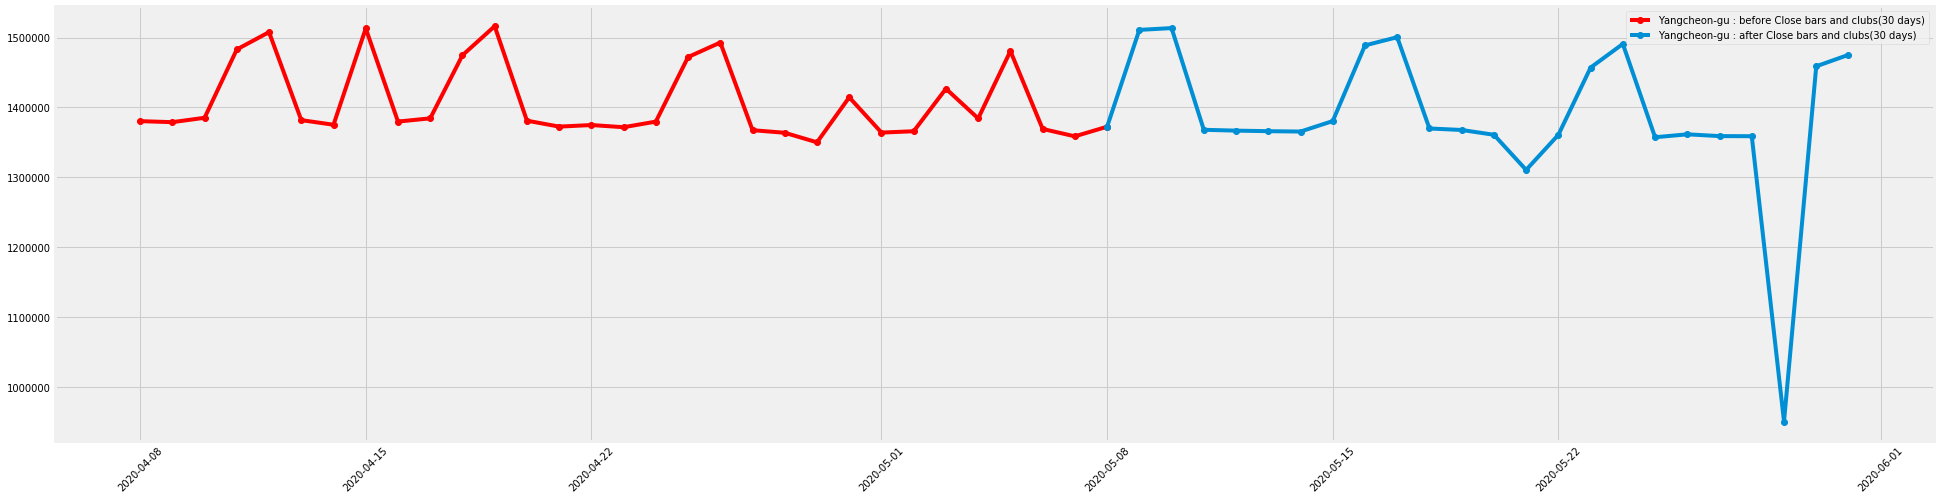

In [48]:
##양천구
Yangcheon = df_city30[df_city30['city'] == 'Yangcheon-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Yangcheon['date'].loc[3419:3449] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Yangcheon['fp_num'].loc[3419:3449] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Yangcheon['date'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Yangcheon['fp_num'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 3지역의 유동인구 수 

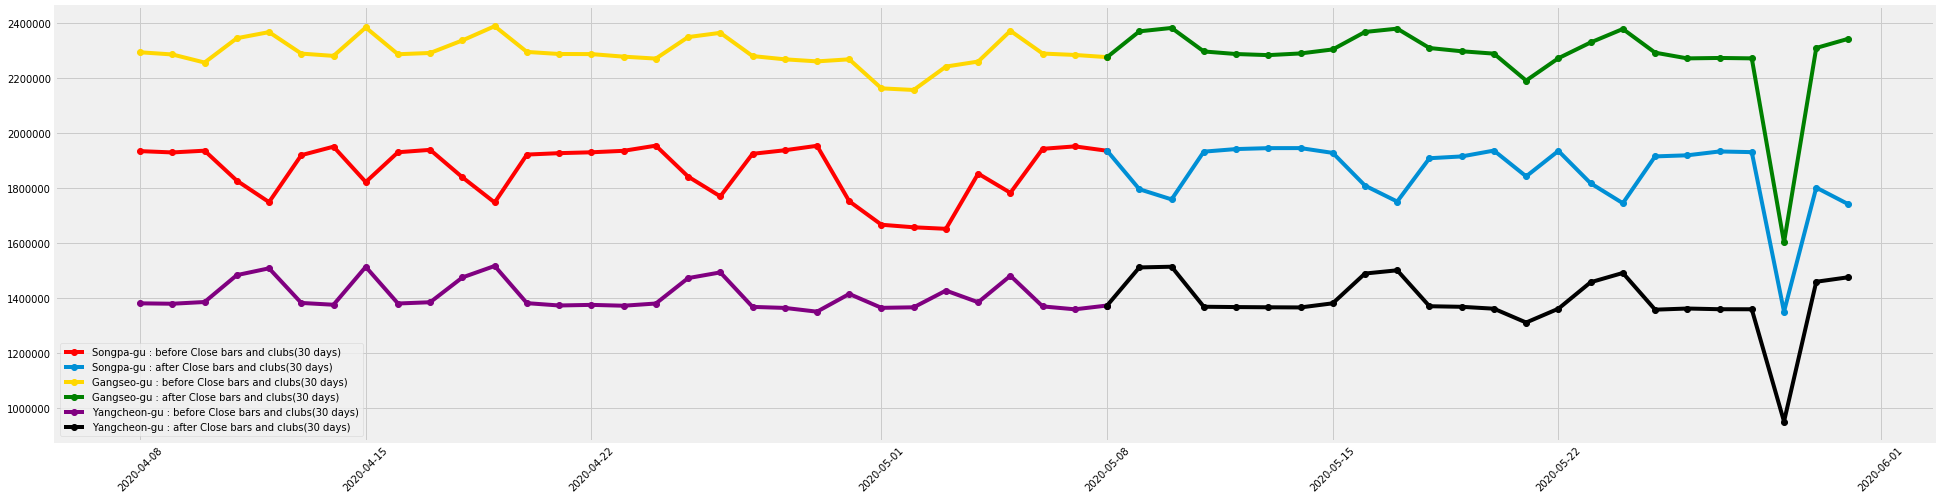

In [49]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Gangseo['date'].loc[1154:1184] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Gangseo['fp_num'].loc[1154:1184] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Gangseo['date'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Gangseo['fp_num'].loc[1184:1207]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Yangcheon['date'].loc[3419:3449] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Yangcheon['fp_num'].loc[3419:3449] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Yangcheon['date'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Yangcheon['fp_num'].loc[3449:3472]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 간이주점 Top 3인 마포구, 강서구, 양천구의 20대 유동인구 (시간대 별)

In [50]:
##마포구
Mapo_hour = age_30[age_30['city'] == 'Mapo-gu']
Mapo_hour = Mapo_hour.sort_values(by=["date", "hour"]) 
Mapo_hour.reset_index(inplace=True)
Mapo_hour

index       date  hour  birth_year     sex province     city  fp_num  \
0        1230 2020-01-01     0          30  female    Seoul  Mapo-gu   34720   
1        1231 2020-01-01     0          30    male    Seoul  Mapo-gu   36120   
2        1280 2020-01-01     1          30  female    Seoul  Mapo-gu   34110   
3        1281 2020-01-01     1          30    male    Seoul  Mapo-gu   35350   
4        1330 2020-01-01     2          30  female    Seoul  Mapo-gu   33570   
...       ...        ...   ...         ...     ...      ...      ...     ...   
7227  1044845 2020-05-31    21          30    male    Seoul  Mapo-gu   37290   
7228  1012495 2020-05-31    22          30    male    Seoul  Mapo-gu   36310   
7229  1066709 2020-05-31    22          30  female    Seoul  Mapo-gu   36820   
7230   898188 2020-05-31    23          30    male    Seoul  Mapo-gu   35530   
7231  1022677 2020-05-31    23          30  female    Seoul  Mapo-gu   36410   

     hour_cat  day_of_week  
0        dawn            2  
1        dawn            2  
2        dawn            2  
3        dawn            2  
4        dawn            2  
...       ...          ...  
7227  evening            6  
7228  evening            6  
7229  evening            6  
7230  evening            6  
7231  evening            6  

[7232 rows x 10 columns]

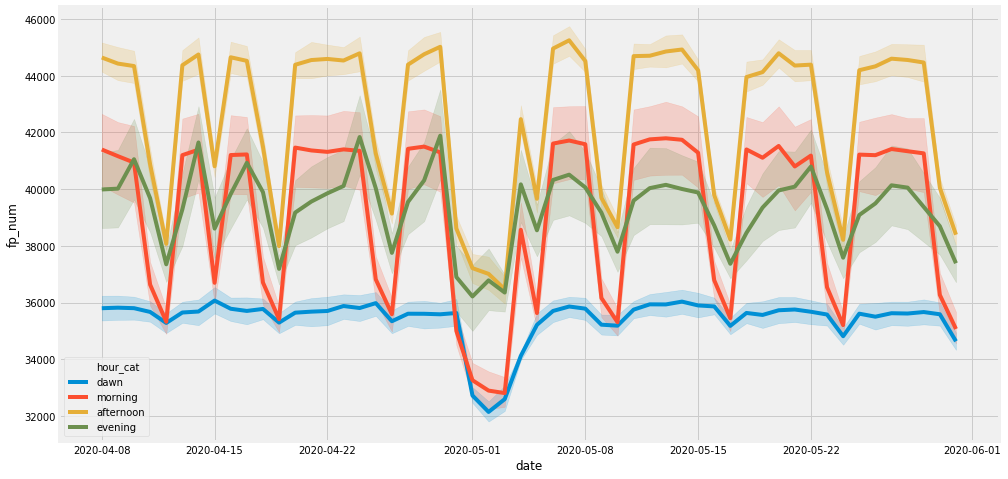

In [51]:
drunk_mapo = Mapo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_mapo, x='date', y="fp_num", hue="hour_cat")

In [52]:
##강서구
Gangseo_hour = age_30[age_30['city'] == 'Gangseo-gu']
Gangseo_hour = Gangseo_hour.sort_values(by=["date", "hour"]) 
Gangseo_hour.reset_index(inplace=True)
Gangseo_hour

index       date  hour  birth_year     sex province        city  \
0        1214 2020-01-01     0          30  female    Seoul  Gangseo-gu   
1        1215 2020-01-01     0          30    male    Seoul  Gangseo-gu   
2        1264 2020-01-01     1          30  female    Seoul  Gangseo-gu   
3        1265 2020-01-01     1          30    male    Seoul  Gangseo-gu   
4        1314 2020-01-01     2          30  female    Seoul  Gangseo-gu   
...       ...        ...   ...         ...     ...      ...         ...   
7227  1032789 2020-05-31    21          30    male    Seoul  Gangseo-gu   
7228   976276 2020-05-31    22          30  female    Seoul  Gangseo-gu   
7229  1048793 2020-05-31    22          30    male    Seoul  Gangseo-gu   
7230   907971 2020-05-31    23          30  female    Seoul  Gangseo-gu   
7231  1060718 2020-05-31    23          30    male    Seoul  Gangseo-gu   

      fp_num hour_cat  day_of_week  
0      47220     dawn            2  
1      50340     dawn            2  
2      47550     dawn            2  
3      50760     dawn            2  
4      47530     dawn            2  
...      ...      ...          ...  
7227   51290  evening            6  
7228   49540  evening            6  
7229   51340  evening            6  
7230   49870  evening            6  
7231   51730  evening            6  

[7232 rows x 10 columns]

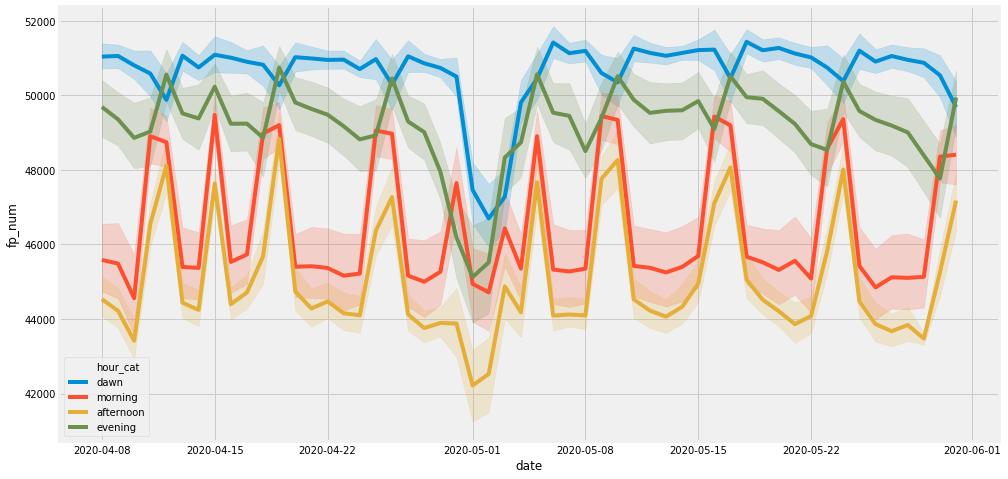

In [53]:
drunk_gangseo = Gangseo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_gangseo, x='date', y="fp_num", hue="hour_cat")

In [54]:
##양천구
Yangcheon_hour = age_30[age_30['city'] == 'Yangcheon-gu']
Yangcheon_hour = Yangcheon_hour.sort_values(by=["date", "hour"]) 
Yangcheon_hour.reset_index(inplace=True)
Yangcheon_hour

index       date  hour  birth_year     sex province          city  \
0        1244 2020-01-01     0          30  female    Seoul  Yangcheon-gu   
1        1245 2020-01-01     0          30    male    Seoul  Yangcheon-gu   
2        1294 2020-01-01     1          30  female    Seoul  Yangcheon-gu   
3        1295 2020-01-01     1          30    male    Seoul  Yangcheon-gu   
4        1344 2020-01-01     2          30  female    Seoul  Yangcheon-gu   
...       ...        ...   ...         ...     ...      ...           ...   
7227  1030752 2020-05-31    21          30  female    Seoul  Yangcheon-gu   
7228  1060715 2020-05-31    22          30    male    Seoul  Yangcheon-gu   
7229  1060716 2020-05-31    22          30  female    Seoul  Yangcheon-gu   
7230   956273 2020-05-31    23          30    male    Seoul  Yangcheon-gu   
7231  1074642 2020-05-31    23          30  female    Seoul  Yangcheon-gu   

      fp_num hour_cat  day_of_week  
0      29900     dawn            2  
1      29740     dawn            2  
2      30030     dawn            2  
3      30110     dawn            2  
4      30150     dawn            2  
...      ...      ...          ...  
7227   32370  evening            6  
7228   32070  evening            6  
7229   32850  evening            6  
7230   32210  evening            6  
7231   32910  evening            6  

[7232 rows x 10 columns]

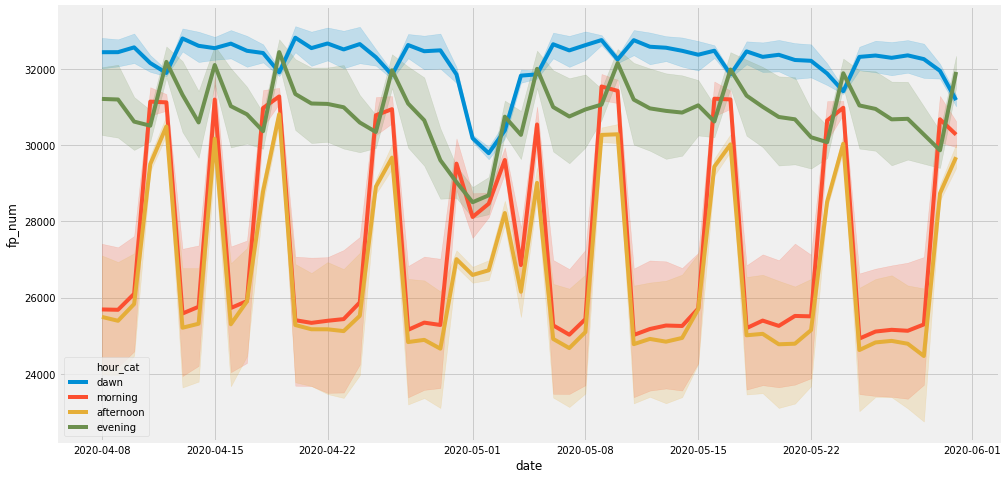

In [55]:
drunk_yangcheon = Yangcheon_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_yangcheon, x='date', y="fp_num", hue="hour_cat")

---
#### 호프전문점 Top 3인 중랑구, 마포구, 영등포구의 30대 유동인구 (일자별)

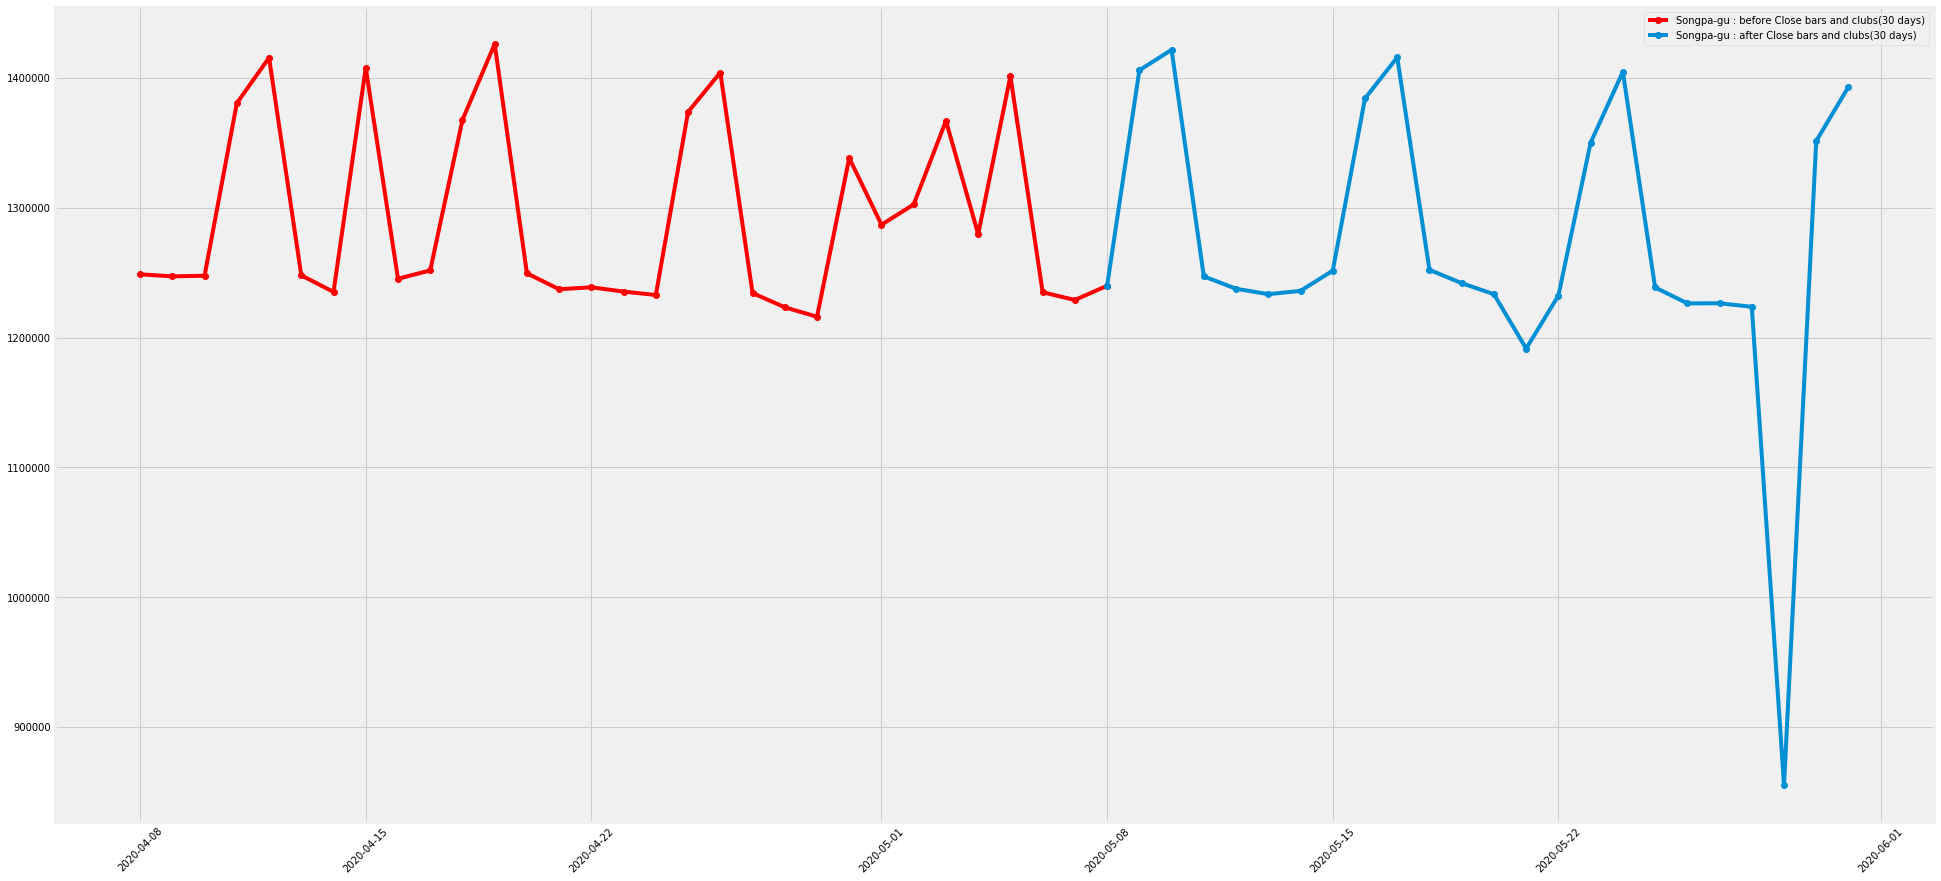

In [56]:
##중랑구
Jungnang = df_city30[df_city30['city'] == 'Jungnang-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Jungnang['date'].loc[2211:2241] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Jungnang['fp_num'].loc[2211:2241] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Jungnang['date'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Jungnang['fp_num'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

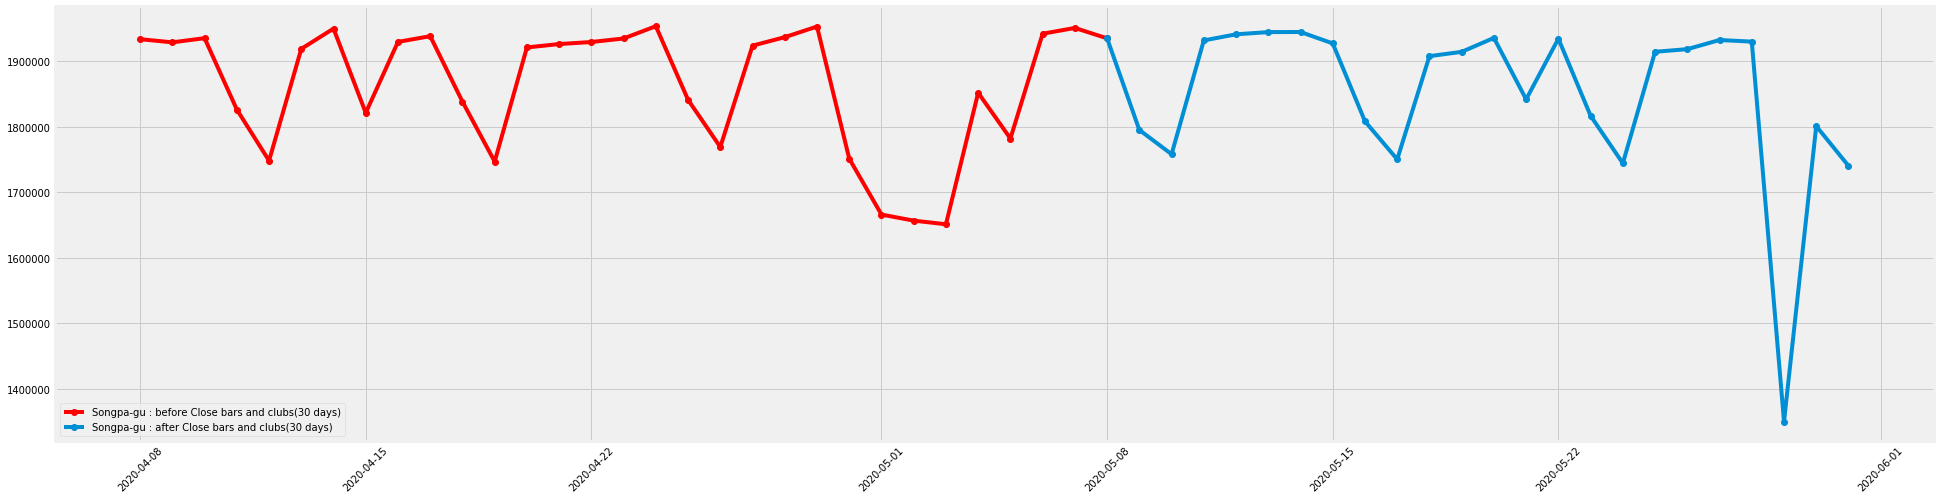

In [57]:
##마포구
Mapo = df_city30[df_city30['city'] == 'Mapo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

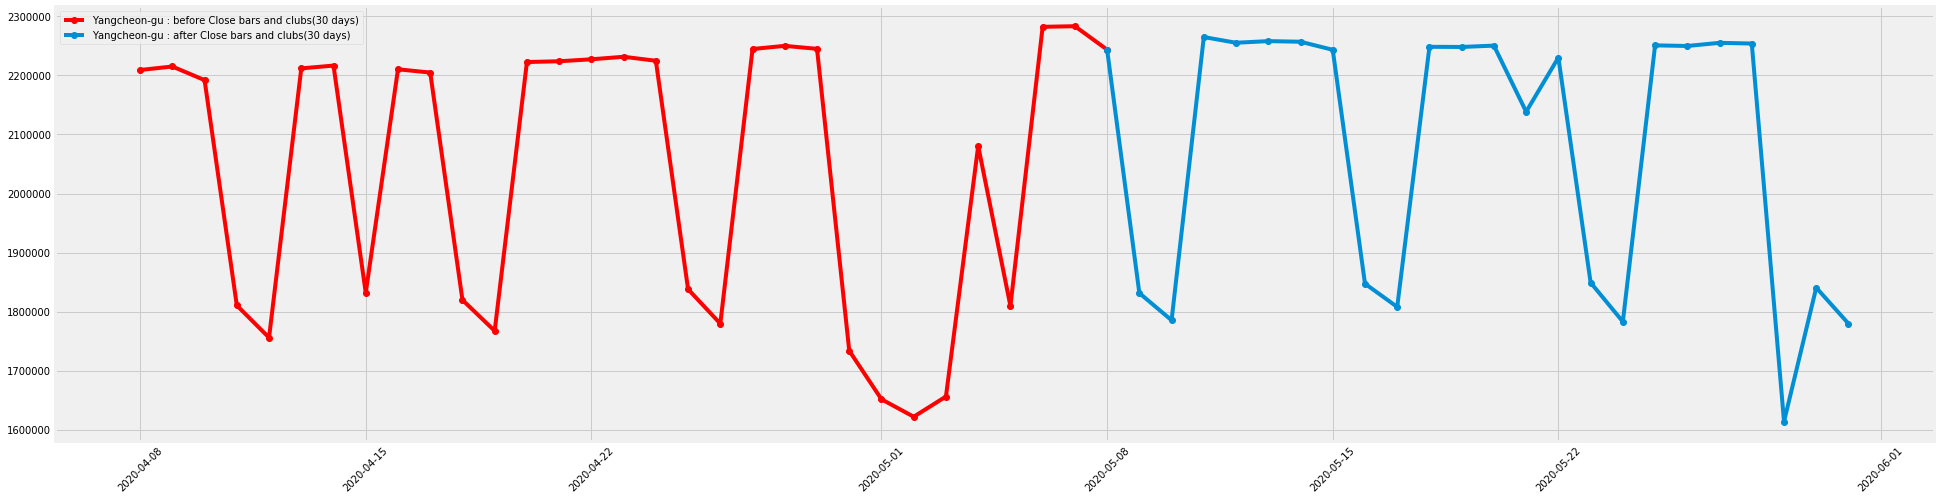

In [58]:
##영등포구
Yeongdeungpo = df_city30[df_city30['city'] == 'Yeongdeungpo-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore=Yeongdeungpo['date'].loc[3570:3600] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore=Yeongdeungpo['fp_num'].loc[3570:3600] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter=Yeongdeungpo['date'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter=Yeongdeungpo['fp_num'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 3지역의 유동인구 수 

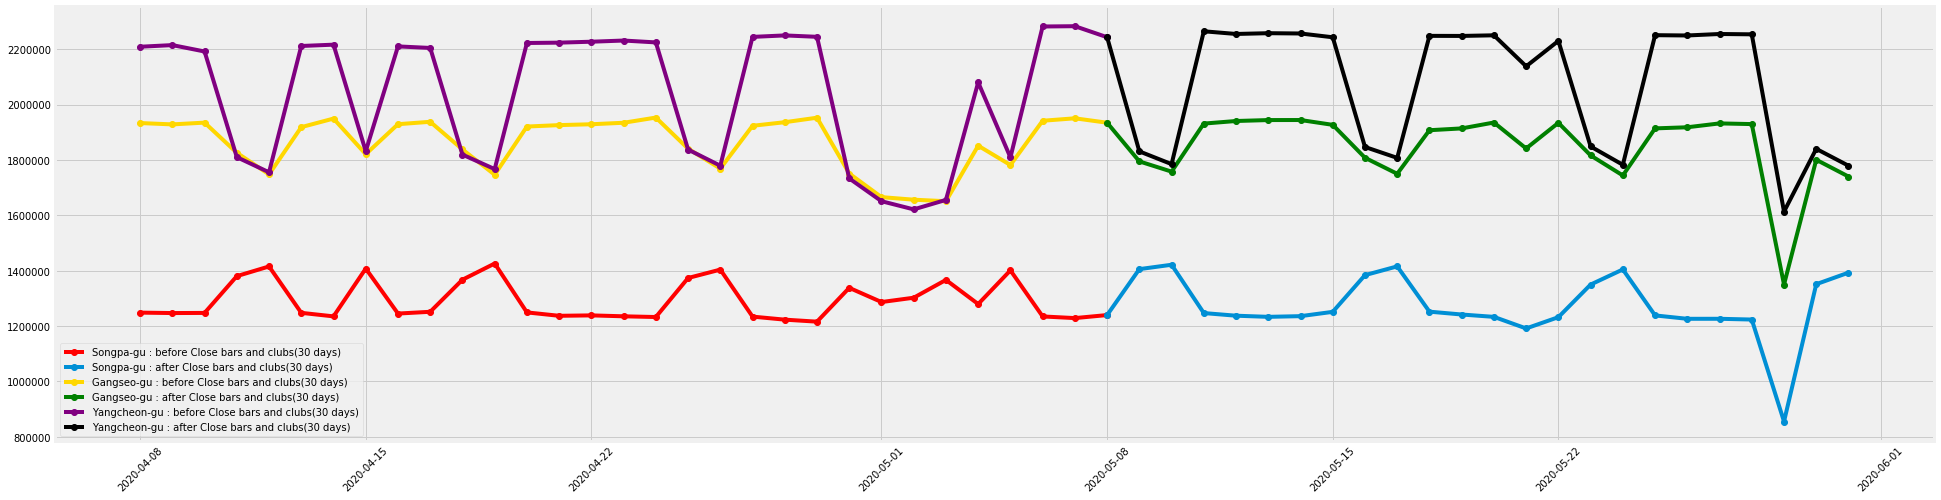

In [59]:
#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Jungnang['date'].loc[2211:2241] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Jungnang['fp_num'].loc[2211:2241] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Jungnang['date'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Jungnang['fp_num'].loc[2241:2264]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Mapo['date'].loc[2362:2392] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Mapo['fp_num'].loc[2362:2392] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Mapo['date'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Mapo['fp_num'].loc[2392:2415]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Yeongdeungpo['date'].loc[3570:3600] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Yeongdeungpo['fp_num'].loc[3570:3600] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Yeongdeungpo['date'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Yeongdeungpo['fp_num'].loc[3600:3623]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 호프전문점 Top 3인 중랑구, 마포구, 영등포구의 20대 유동인구 (시간대별)

In [60]:
##마포구
Jungnang_hour = age_30[age_30['city'] == 'Jungnang-gu']
Jungnang_hour = Jungnang_hour.sort_values(by=["date", "hour"]) 
Jungnang_hour.reset_index(inplace=True)
Jungnang_hour

index       date  hour  birth_year     sex province         city  \
0        1228 2020-01-01     0          30  female    Seoul  Jungnang-gu   
1        1229 2020-01-01     0          30    male    Seoul  Jungnang-gu   
2        1278 2020-01-01     1          30  female    Seoul  Jungnang-gu   
3        1279 2020-01-01     1          30    male    Seoul  Jungnang-gu   
4        1328 2020-01-01     2          30  female    Seoul  Jungnang-gu   
...       ...        ...   ...         ...     ...      ...          ...   
7227  1030750 2020-05-31    21          30    male    Seoul  Jungnang-gu   
7228   970291 2020-05-31    22          30  female    Seoul  Jungnang-gu   
7229  1072678 2020-05-31    22          30    male    Seoul  Jungnang-gu   
7230   994316 2020-05-31    23          30    male    Seoul  Jungnang-gu   
7231  1020614 2020-05-31    23          30  female    Seoul  Jungnang-gu   

      fp_num hour_cat  day_of_week  
0      28630     dawn            2  
1      31520     dawn            2  
2      28990     dawn            2  
3      31990     dawn            2  
4      29050     dawn            2  
...      ...      ...          ...  
7227   31340  evening            6  
7228   29710  evening            6  
7229   31900  evening            6  
7230   32200  evening            6  
7231   29910  evening            6  

[7232 rows x 10 columns]

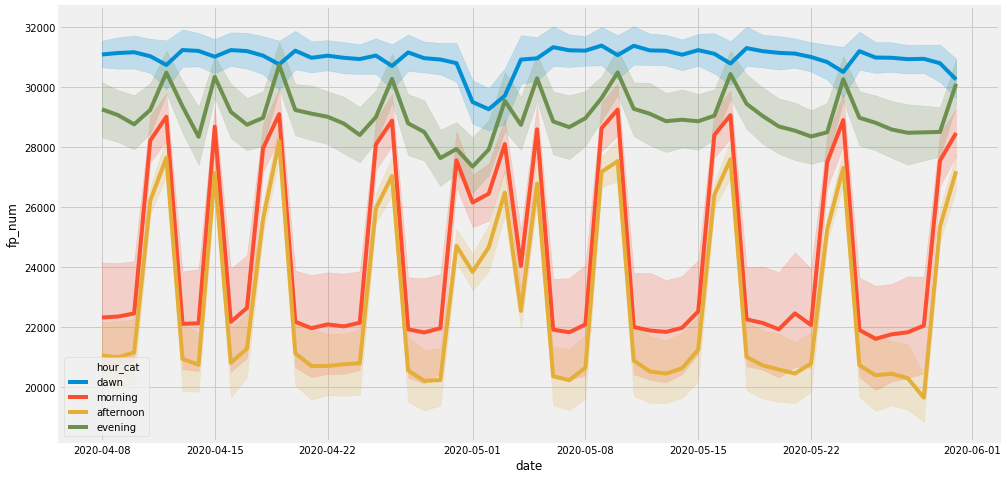

In [61]:
drunk_jungnang = Jungnang_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_jungnang, x='date', y="fp_num", hue="hour_cat")

In [62]:
##마포구
Mapo_hour = age_30[age_30['city'] == 'Mapo-gu']
Mapo_hour = Mapo_hour.sort_values(by=["date", "hour"]) 
Mapo_hour.reset_index(inplace=True)
Mapo_hour

index       date  hour  birth_year     sex province     city  fp_num  \
0        1230 2020-01-01     0          30  female    Seoul  Mapo-gu   34720   
1        1231 2020-01-01     0          30    male    Seoul  Mapo-gu   36120   
2        1280 2020-01-01     1          30  female    Seoul  Mapo-gu   34110   
3        1281 2020-01-01     1          30    male    Seoul  Mapo-gu   35350   
4        1330 2020-01-01     2          30  female    Seoul  Mapo-gu   33570   
...       ...        ...   ...         ...     ...      ...      ...     ...   
7227  1044845 2020-05-31    21          30    male    Seoul  Mapo-gu   37290   
7228  1012495 2020-05-31    22          30    male    Seoul  Mapo-gu   36310   
7229  1066709 2020-05-31    22          30  female    Seoul  Mapo-gu   36820   
7230   898188 2020-05-31    23          30    male    Seoul  Mapo-gu   35530   
7231  1022677 2020-05-31    23          30  female    Seoul  Mapo-gu   36410   

     hour_cat  day_of_week  
0        dawn            2  
1        dawn            2  
2        dawn            2  
3        dawn            2  
4        dawn            2  
...       ...          ...  
7227  evening            6  
7228  evening            6  
7229  evening            6  
7230  evening            6  
7231  evening            6  

[7232 rows x 10 columns]

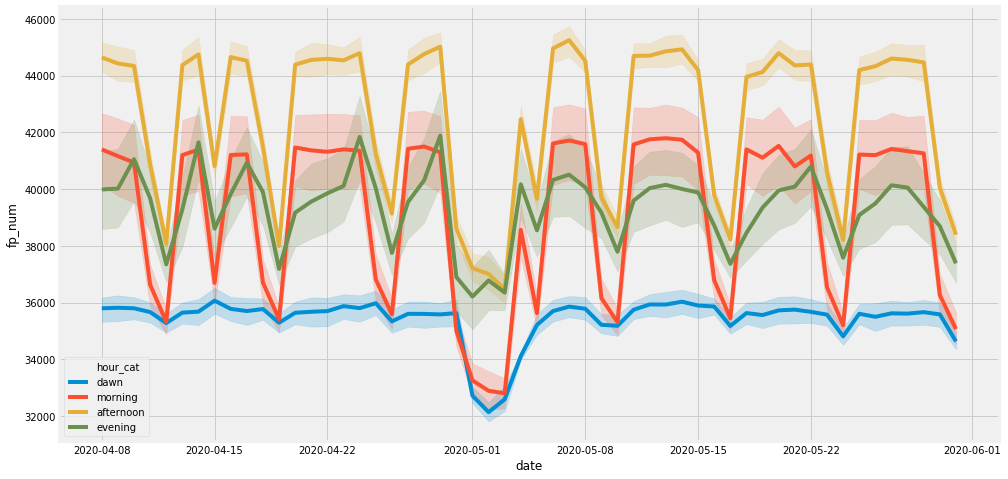

In [63]:
drunk_mapo = Mapo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_mapo, x='date', y="fp_num", hue="hour_cat")

In [64]:
##영등포구
Yeongdeungpo_hour = age_30[age_30['city'] == 'Yeongdeungpo-gu']
Yeongdeungpo_hour = Yeongdeungpo_hour.sort_values(by=["date", "hour"]) 
Yeongdeungpo_hour.reset_index(inplace=True)
Yeongdeungpo_hour

index       date  hour  birth_year     sex province             city  \
0        1246 2020-01-01     0          30  female    Seoul  Yeongdeungpo-gu   
1        1247 2020-01-01     0          30    male    Seoul  Yeongdeungpo-gu   
2        1296 2020-01-01     1          30  female    Seoul  Yeongdeungpo-gu   
3        1297 2020-01-01     1          30    male    Seoul  Yeongdeungpo-gu   
4        1346 2020-01-01     2          30  female    Seoul  Yeongdeungpo-gu   
...       ...        ...   ...         ...     ...      ...              ...   
7227   924113 2020-05-31    21          30    male    Seoul  Yeongdeungpo-gu   
7228   890234 2020-05-31    22          30  female    Seoul  Yeongdeungpo-gu   
7229   932233 2020-05-31    22          30    male    Seoul  Yeongdeungpo-gu   
7230   952258 2020-05-31    23          30  female    Seoul  Yeongdeungpo-gu   
7231  1072681 2020-05-31    23          30    male    Seoul  Yeongdeungpo-gu   

      fp_num hour_cat  day_of_week  
0      34870     dawn            2  
1      38640     dawn            2  
2      33840     dawn            2  
3      37660     dawn            2  
4      33380     dawn            2  
...      ...      ...          ...  
7227   39360  evening            6  
7228   35230  evening            6  
7229   38900  evening            6  
7230   35090  evening            6  
7231   38640  evening            6  

[7232 rows x 10 columns]

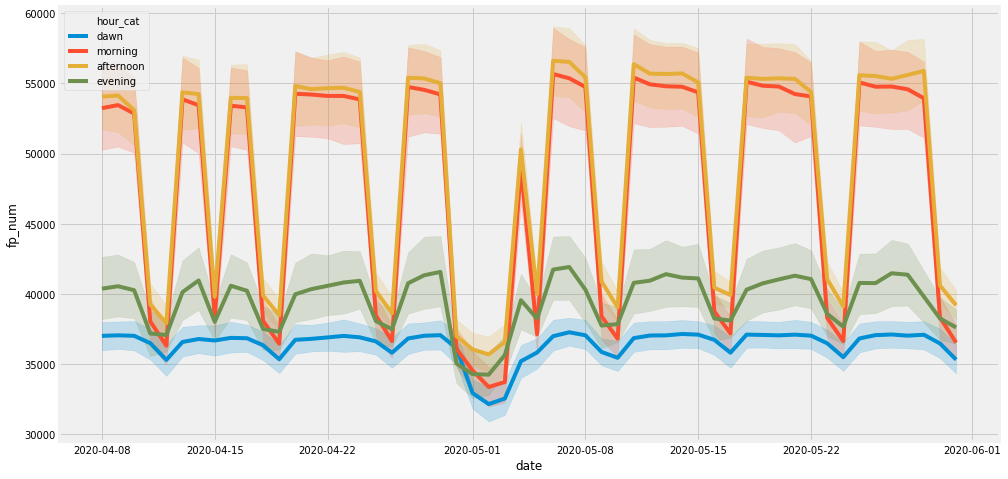

In [65]:
drunk_yeongdeungpo = Yeongdeungpo_hour[4656:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=drunk_yeongdeungpo, x='date', y="fp_num", hue="hour_cat")

환경 빅데이터 플랫폼에서 제공하는 **'행정동별 유흥분야 소비인구'** 데이터 셋을 통해 소비인구 top 3 지역은 **서초구, 관악구, 강남구**로 판명되었다. 따라서, 해당 지역에 대한 EDA를 진행한다. (추가 데이터셋을 사용해도 되는 지 알 수 없어 분석을 진행하지 않았지만 가능하다면 해당 명령의 실효성을 파악하기에 유의미한 데이터셋일 것으로 생각된다.)

#### 서초구, 관악구, 강남구의 20대 유동인구

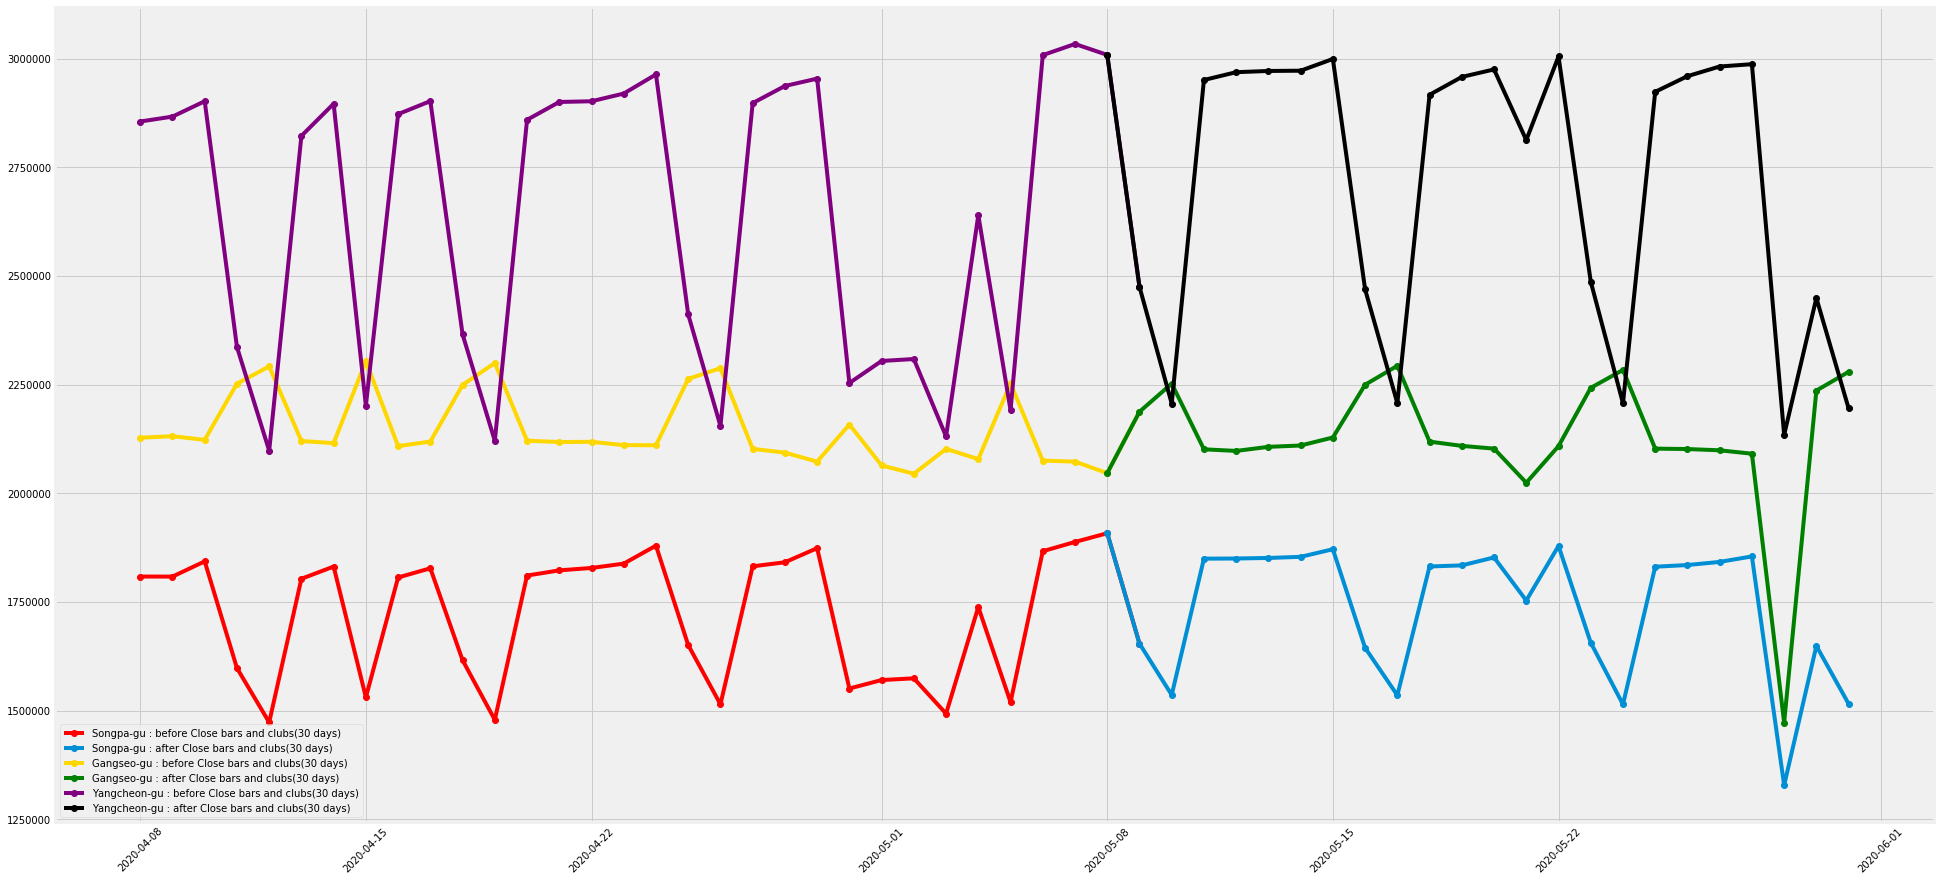

In [66]:
##서초구
Seocho = df_city20[df_city20['city'] == 'Seocho-gu']

##관악구
Gwanak = df_city20[df_city20['city'] == 'Gwanak-gu']

##강남구
Gangnam = df_city20[df_city20['city'] == 'Gangnam-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Seocho['date'].loc[2664:2695] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Seocho['fp_num'].loc[2664:2695] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Seocho['date'].loc[2694:2718]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Seocho['fp_num'].loc[2694:2718]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Gwanak['date'].loc[1607:1638] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Gwanak['fp_num'].loc[1607:1638] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Gwanak['date'].loc[1637:1661]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Gwanak['fp_num'].loc[1637:1661]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Gangnam['date'].loc[1003:1034] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Gangnam['fp_num'].loc[1003:1034] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Gangnam['date'].loc[1033:1057]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Gangnam['fp_num'].loc[1033:1057]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 서초구, 관악구, 강남구의 30대 유동인구

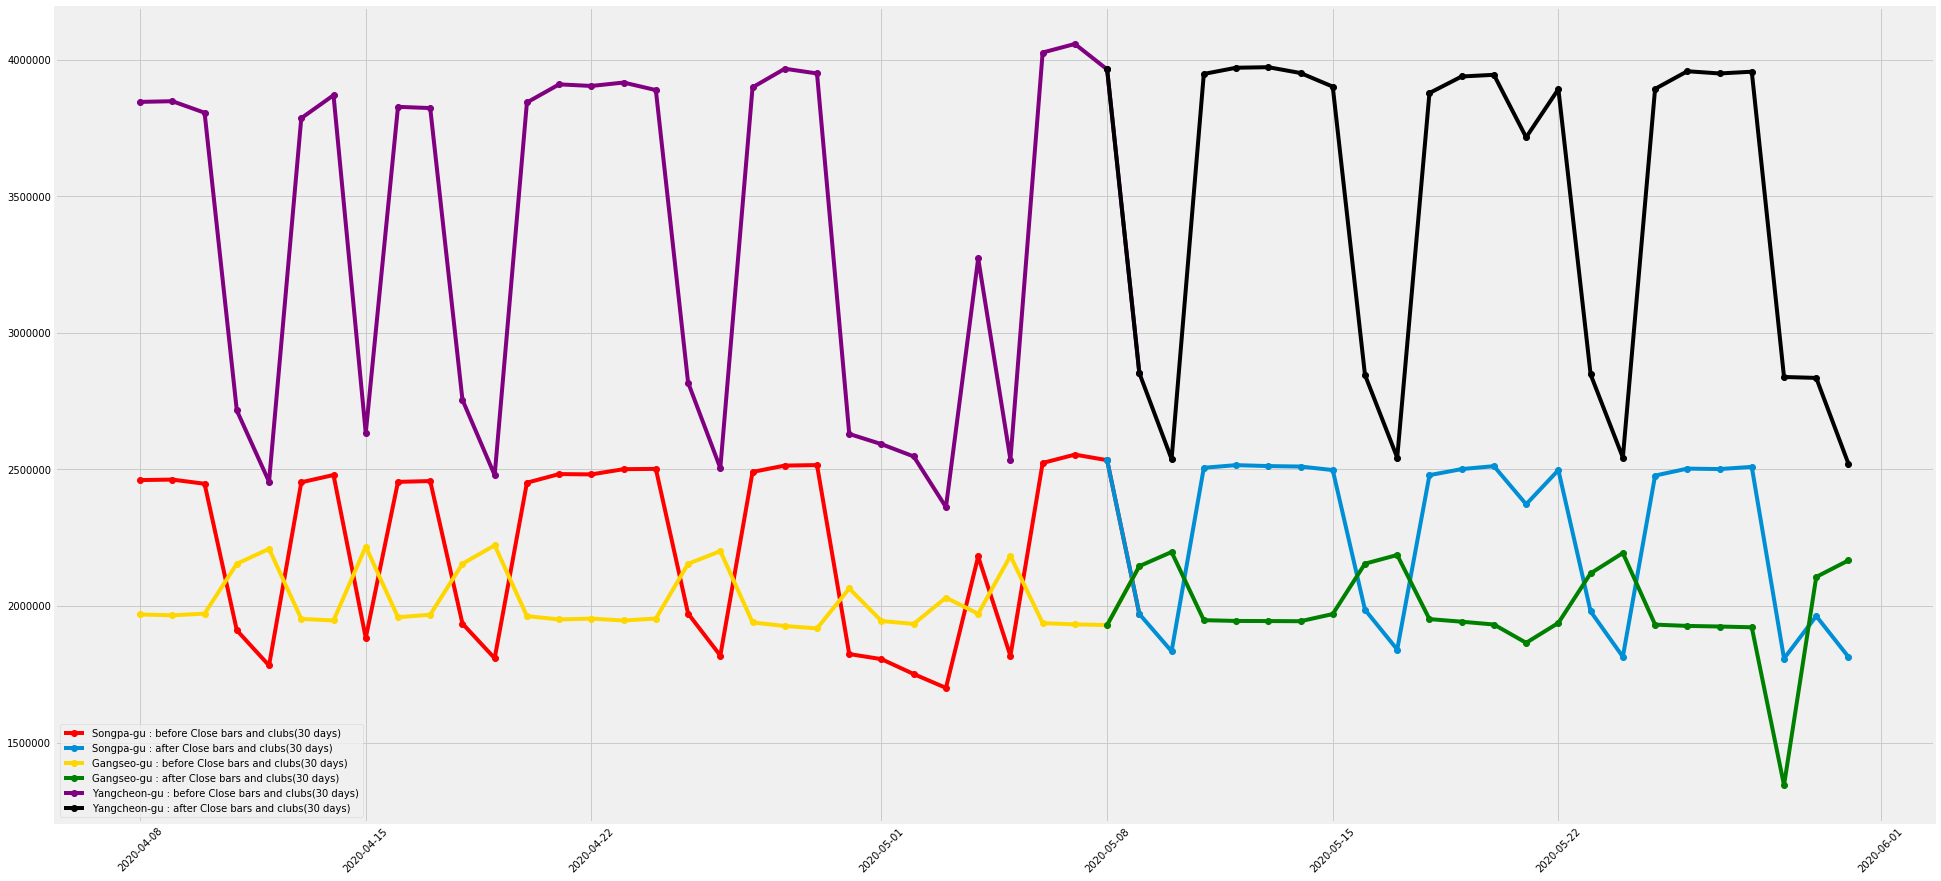

In [67]:
##서초구
Seocho = df_city30[df_city30['city'] == 'Seocho-gu']

##관악구
Gwanak = df_city30[df_city30['city'] == 'Gwanak-gu']

##강남구
Gangnam = df_city30[df_city30['city'] == 'Gangnam-gu']

#술집 및 클럽 폐쇄 제한 명령 시행 이전 30일과 시행 이후 30일의 일별 확진자수를 시각화합니다.
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore1=Seocho['date'].loc[2664:2695] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore1=Seocho['fp_num'].loc[2664:2695] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter1=Seocho['date'].loc[2694:2718]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter1=Seocho['fp_num'].loc[2694:2718]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore2=Gwanak['date'].loc[1607:1638] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore2=Gwanak['fp_num'].loc[1607:1638] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gangseo-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter2=Gwanak['date'].loc[1637:1661]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter2=Gwanak['fp_num'].loc[1637:1661]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gangseo-gu : after Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이전 30일 동안의 확진자수 그래프 그리기
xbefore3=Gangnam['date'].loc[1003:1034] # 4월 8일 ~ 5월 8일을 x축으로 지정
ybefore3=Gangnam['fp_num'].loc[1003:1034] # 4월 8일 ~ 5월 8일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Yangcheon-gu : before Close bars and clubs(30 days)')

#술집 및 클럽 폐쇄 제한 명령 이후 30일 동안의 확진자수 그래프 그리기
xafter3=Gangnam['date'].loc[1033:1057]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일을 x축으로 지정
yafter3=Gangnam['fp_num'].loc[1033:1057]  # 술집 및 클럽 폐쇄 제한 명령 시작일인 5월 8일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Yangcheon-gu : after Close bars and clubs(30 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

---
## 2. 노래방 폐쇄 제한 명령에 대한 EDA
      정책 시작일과 종료일 기준 +- 2주까지 비교
      
#### 노래방 폐쇄 제한 명령 시작일(2020-05-21) 기준 일별 확진자 수

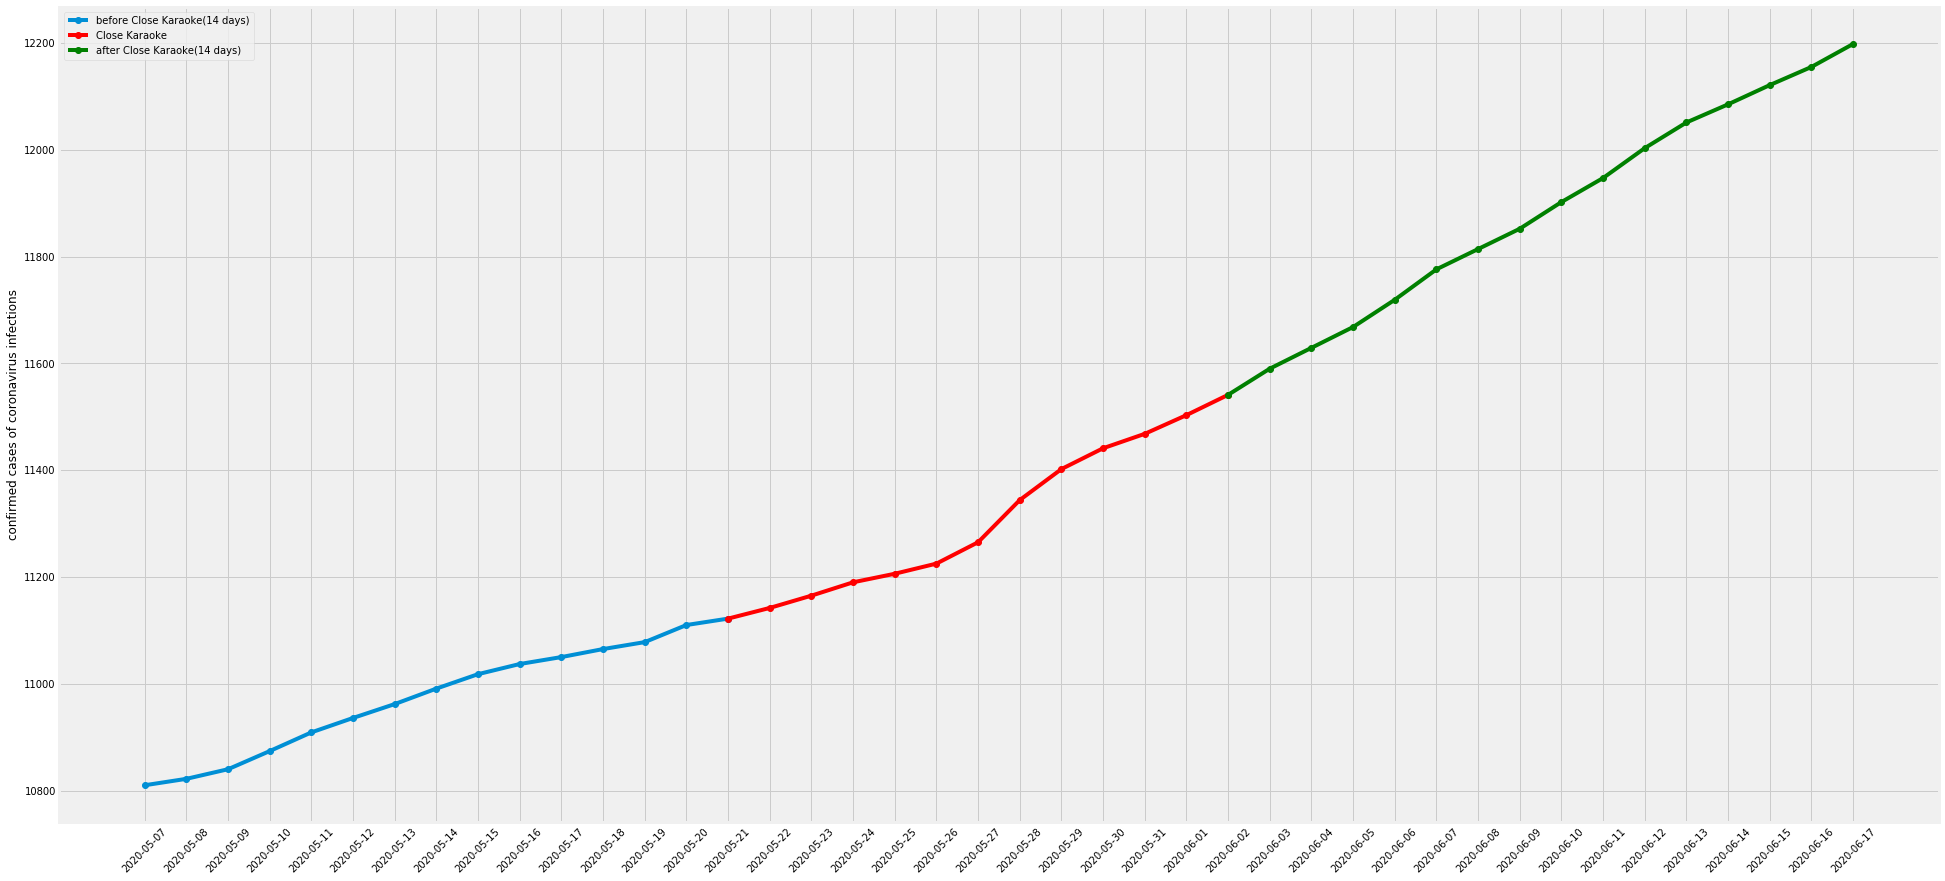

In [68]:
#노래방 폐쇄 제한 명령 시행 이전 14일과 시행 이후 14일의 일별 확진자수를 시각화합니다.
date = Time['date'] #날짜 column
conNum = Time['confirmed'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 10] # [width, height]

#노래방 폐쇄 제한 명령 이전 14일 동안의 확진자수 그래프 그리기
xbefore=date[108:123] # 5월 7일 ~ 5월 21일을 x축으로 지정
ybefore=conNum[108:123] # 5월 7일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', label='before Close Karaoke(14 days)')

#노래방 폐쇄 제한 명령동안의 확진자수 그래프 그리기
xing=date[122:135] # 5월 21일 ~ 6월 3일을 x축으로 지정
ying=conNum[122:135] # 5월 21일 ~ 6월 3일까지의 확진자수를 y축으로 지정
plt.plot(xing, ying, marker='o', color='r', label='Close Karaoke')

#노래방 폐쇄 제한 명령 종료 이후 일 동안의 확진자수 그래프 그리기
xafter=date[134:150] # 6월 3일 ~ 6월 17일을 x축으로 지정
yafter=conNum[134:150] # 6월 3일 ~ 6월 17일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', color='green', label='after Close Karaoke(14 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.ylabel("confirmed cases of coronavirus infections")
plt.legend()
plt.show()

In [69]:
Patientinfo[Patientinfo['infection_case']=='Changnyeong Coin Karaoke']['age'].value_counts(normalize=True)*100

20    50.0
10    25.0
60    25.0
Name: age, dtype: float64

환경 빅데이터 플랫폼에서 제공하는 **'행정동별 노래방분야 소비인구'** 데이터 셋을 통해 소비연령대를 확인한 결과 10, 20대가 주요 타겟층임을 알 수 있었다. 그러므로 해당 제한 명령은 1-20대를 중심으로 살펴보자.
  
#### 10대 일별 확진자수

In [70]:
pat_10 = Patientinfo[Patientinfo['age']== '10']
pat_10 = pat_10.sort_values(by=["confirmed_date", "contact_number"]) 
pat_10['confirmed_date'] = pd.to_datetime(pat_10['confirmed_date'], format = '%Y-%m-%d')
pat_10

patient_id     sex age country           province             city  \
2224  2000000012  female  10   Korea        Gyeonggi-do         Suwon-si   
3759  6001000002  female  10   Korea       Jeollanam-do     Gyeongsan-si   
5015  6100000003  female  10   Korea   Gyeongsangnam-do         Jinju-si   
1312  1100000001    male  10   Korea              Busan       Dongnae-gu   
5016  6100000004    male  10   Korea   Gyeongsangnam-do         Jinju-si   
1326  1100000015    male  10   Korea              Busan       Dongnae-gu   
1332  1100000021  female  10   Korea              Busan       Gangseo-gu   
1353  1100000042    male  10   Korea              Busan       Dongnae-gu   
3788  6001000031    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4970  6023000011  female  10   Korea   Gyeongsangbuk-do        Pohang-si   
4877  6020000014  female  10   Korea   Gyeongsangbuk-do     Cheongdo-gun   
3808  6001000051    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
3810  6001000053  female  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4468  6004000010    male  10   Korea   Gyeongsangbuk-do          Gumi-si   
4657  6010000001  female  10   Korea   Gyeongsangbuk-do      Seongju-gun   
5041  6100000029    male  10   Korea   Gyeongsangnam-do      Changwon-si   
1373  1100000062    male  10   Korea              Busan       Dongnae-gu   
2116  1600000009    male  10   Korea              Ulsan           Buk-gu   
3840  6001000083  female  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4695  6011000016  female  10   Korea   Gyeongsangbuk-do        Andong-si   
1381  1100000070  female  10   Korea              Busan        Yeonje-gu   
78    1000000079  female  10   Korea              Seoul         Nowon-gu   
86    1000000087    male  10   Korea              Seoul         Nowon-gu   
3881  6001000124    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
3586  4100000048    male  10   Korea  Chungcheongnam-do       Cheonan-si   
3595  4100000057    male  10   Korea  Chungcheongnam-do       Cheonan-si   
3596  4100000058    male  10   Korea  Chungcheongnam-do       Cheonan-si   
2296  2000000084  female  10   Korea        Gyeonggi-do      Hwaseong-si   
3598  4100000060    male  10   Korea  Chungcheongnam-do       Cheonan-si   
3599  4100000061    male  10   Korea  Chungcheongnam-do       Cheonan-si   
3892  6001000135  female  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4939  6022000031    male  10   Korea   Gyeongsangbuk-do      Chilgok-gun   
3602  4100000064    male  10   Korea  Chungcheongnam-do       Cheonan-si   
3608  4100000070    male  10   Korea  Chungcheongnam-do       Cheonan-si   
2299  2000000087  female  10   Korea        Gyeonggi-do      Hwaseong-si   
3923  6001000166  female  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
3931  6001000174  female  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4943  6022000035    male  10   Korea   Gyeongsangbuk-do      Chilgok-gun   
3616  4100000078    male  10   Korea  Chungcheongnam-do       Cheonan-si   
4410  6002000014    male  10   Korea   Gyeongsangbuk-do      Gyeongju-si   
1393  1100000082    male  10   Korea              Busan       Dongnae-gu   
1394  1100000083    male  10   Korea              Busan      Busanjin-gu   
2309  2000000097  female  10   Korea        Gyeonggi-do         Suwon-si   
3989  6001000232    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4004  6001000247    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4499  6004000041    male  10   Korea   Gyeongsangbuk-do          Gumi-si   
100   1000000101  female  10   Korea              Seoul      Jungnang-gu   
2320  2000000108  female  10   Korea        Gyeonggi-do      Hwaseong-si   
4051  6001000294    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4098  6001000341    male  10   Korea   Gyeongsangbuk-do     Gyeongsan-si   
4505  6004000047  female  10   Korea   Gyeongsangbuk-do          Gumi-si   
4506  6004000048    male  10   Korea   Gyeongsangbuk-d

In [71]:
conf_10 = pd.DataFrame(pat_10['confirmed_date'].value_counts())
conf_10.reset_index(inplace=True)
conf_10 = conf_10.sort_values(by=["index"]) 
conf_10.reset_index(inplace=True, drop=True)
conf_10

index  confirmed_date
0  2020-02-18               1
1  2020-02-19               1
2  2020-02-20               1
3  2020-02-21               2
4  2020-02-22               1
5  2020-02-23               1
6  2020-02-24               3
7  2020-02-25               1
8  2020-02-26               5
9  2020-02-27               4
10 2020-02-28               4
11 2020-02-29               8
12 2020-03-01               6
13 2020-03-02               2
14 2020-03-03               6
15 2020-03-04               7
16 2020-03-05               3
17 2020-03-06               6
18 2020-03-07               1
19 2020-03-08               3
20 2020-03-09               4
21 2020-03-10               1
22 2020-03-12               2
23 2020-03-14               2
24 2020-03-15               3
25 2020-03-16               3
26 2020-03-17               2
27 2020-03-18               2
28 2020-03-19               3
29 2020-03-20               3
30 2020-03-23               2
31 2020-03-24               2
32 2020-03-25               3
33 2020-03-26               4
34 2020-03-27               4
35 2020-03-28               6
36 2020-03-29               2
37 2020-03-30               3
38 2020-03-31               4
39 2020-04-01               2
40 2020-04-02               3
41 2020-04-04               2
42 2020-04-07               3
43 2020-04-09               1
44 2020-04-10               2
45 2020-04-11               1
46 2020-04-12               1
47 2020-04-13               2
48 2020-04-14               3
49 2020-04-15               2
50 2020-04-16               2
51 2020-04-18               1
52 2020-04-19               1
53 2020-04-21               1
54 2020-04-23               1
55 2020-04-26               2
56 2020-05-11               3
57 2020-05-13               1
58 2020-05-14               1
59 2020-05-19               1
60 2020-05-21               1
61 2020-05-22               1
62 2020-05-24               1
63 2020-05-26               1
64 2020-05-28               3
65 2020-05-29               1
66 2020-06-01               1
67 2020-06-04               1
68 2020-06-06               1
69 2020-06-09               1
70 2020-06-11               1
71 2020-06-17               1
72 2020-06-26               1
73 2020-06-27               1
74 2020-06-29               2
75 2020-06-30               2

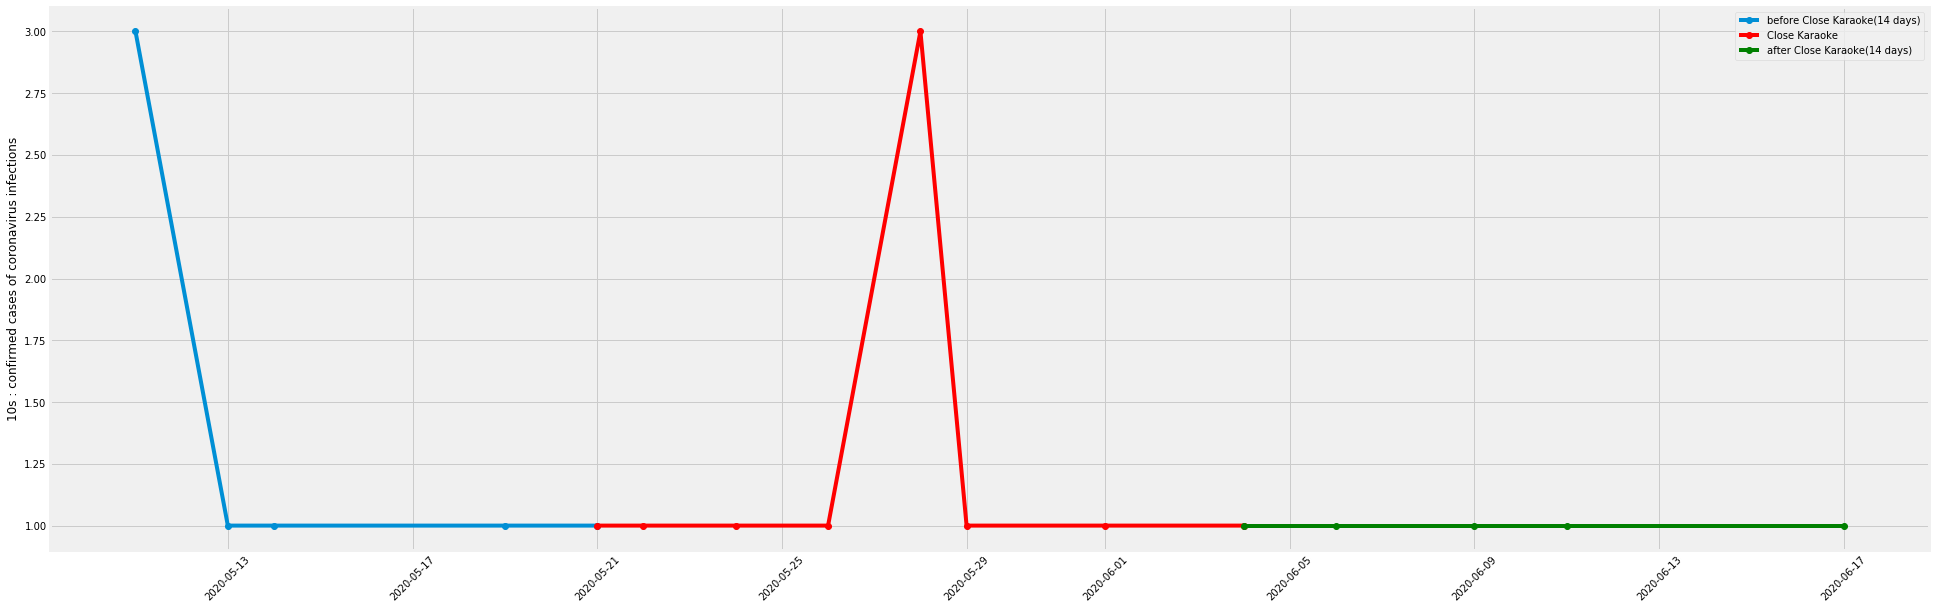

In [72]:
#노래방 제한 명령 시행 이전 14일과 시행 이후 14일의 일별 확진자수를 시각화합니다.
date = conf_10['index'] #날짜 column
conNum = conf_10['confirmed_date'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

#노래방 제한 명령 이전 14일 동안의 확진자수 그래프 그리기
xbefore=date[56:61] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore=conNum[56:61] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', label='before Close Karaoke(14 days)')

#노래방 제한 명령동안의 확진자수 그래프 그리기
xing=date[60:68] # 5월 21일 ~ 6월 3일을 x축으로 지정
ying=conNum[60:68] # 5월 21일 ~ 6월 3일까지의 확진자수를 y축으로 지정
plt.plot(xing, ying, marker='o', color='r', label='Close Karaoke')

#노래방 제한 명령 종료 이후 일 동안의 확진자수 그래프 그리기
xafter=date[67:72] # 6월 3일 ~ 6월 17일을 x축으로 지정
yafter=conNum[67:72] # 6월 3일 ~ 6월 17일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', color='green', label='after Close Karaoke(14 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.ylabel("10s : confirmed cases of coronavirus infections")
plt.legend()
plt.show()

In [73]:
conf_10[60:68].sort_values(by=["confirmed_date"], ascending=False) 

index  confirmed_date
64 2020-05-28               3
60 2020-05-21               1
61 2020-05-22               1
62 2020-05-24               1
63 2020-05-26               1
65 2020-05-29               1
66 2020-06-01               1
67 2020-06-04               1

In [74]:
Patientinfo[Patientinfo['confirmed_date']=='2020-05-28']['infection_case'].value_counts()

contact with patient               23
Coupang Logistics Center           13
KB Life Insurance                   5
overseas inflow                     5
Yeongdeungpo Learning Institute     2
Itaewon Clubs                       2
Guri Collective Infection           1
Biblical Language study meeting     1
Korea Campus Crusade of Christ      1
Gangnam Dongin Church               1
Name: infection_case, dtype: int64

---
### 구별 유동인구 수
국세청 2020년 1월말 기준 사업자 현황에 따르면 
    
"노래방"  
1. 송파구 (458)  
2. 광진구 (342)  
3. 중랑구 (340)  

(그러나, 유동인구 데이터에 10대는 포함되어 있지 않다.)

#### 노래방 Top 3인 송파구, 광진구, 중랑구의 20대 유동인구 (일자별)

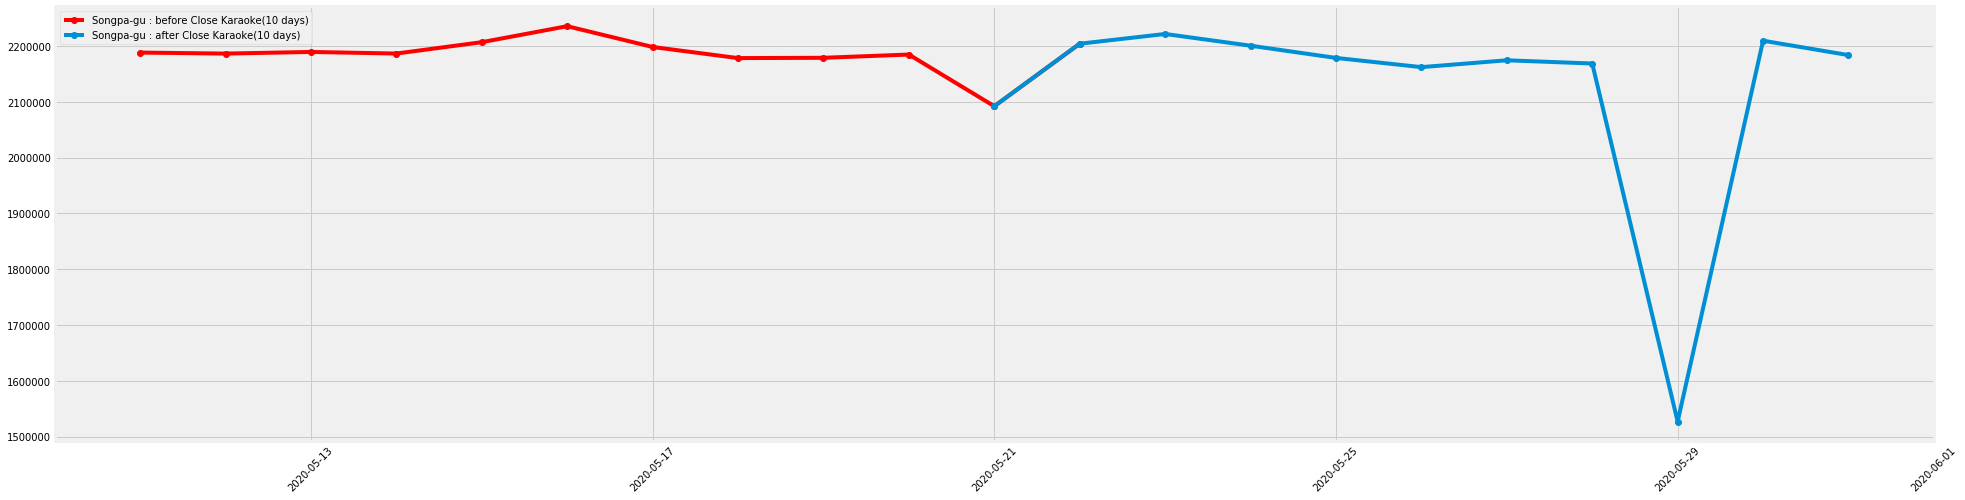

In [75]:
##송파구
Songpa = df_city20[df_city20['city'] == 'Songpa-gu']

plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

xbefore=Songpa['date'].loc[3301:3312] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore=Songpa['fp_num'].loc[3301:3312] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Songpa-gu : before Close Karaoke(10 days)')

xafter=Songpa['date'].loc[3311:3322]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter=Songpa['fp_num'].loc[3311:3322]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Songpa-gu : after Close Karaoke(10 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

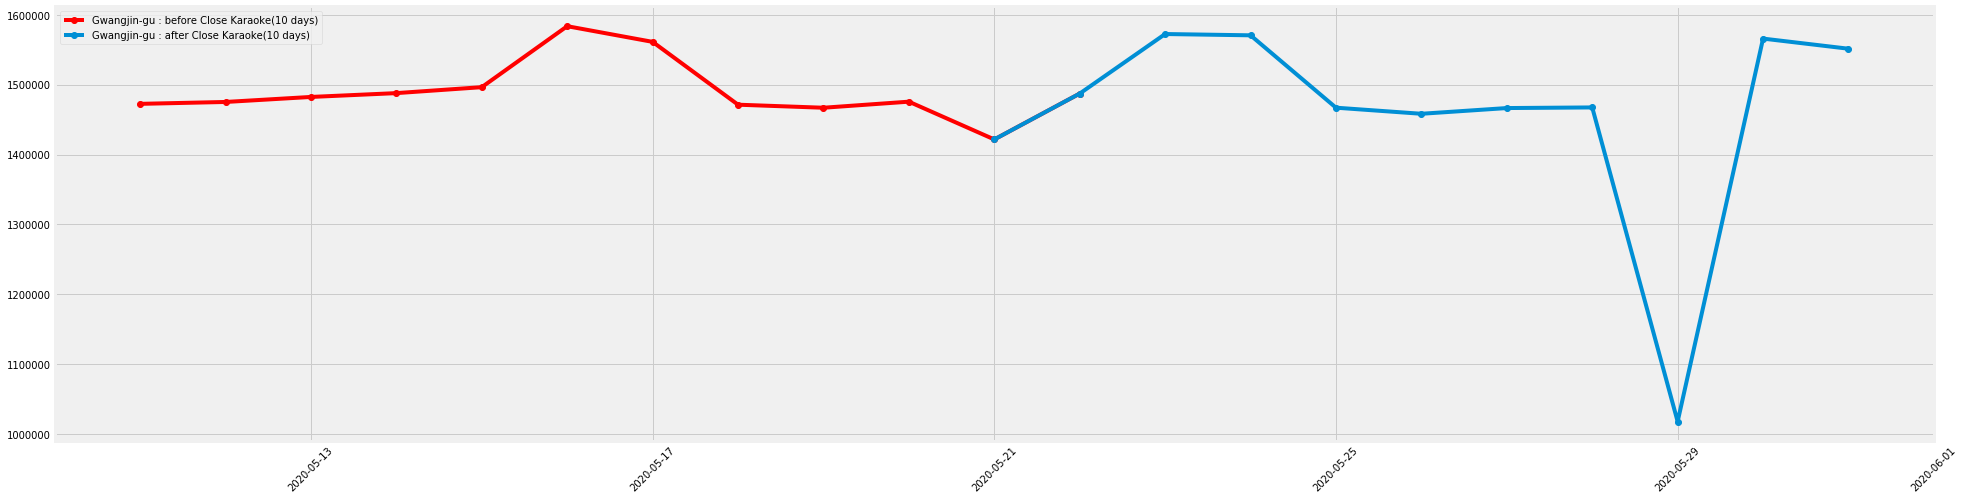

In [76]:
##광진구
Gwangjin = df_city20[df_city20['city'] == 'Gwangjin-gu']

plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

xbefore=Gwangjin['date'].loc[1791:1802] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore=Gwangjin['fp_num'].loc[1791:1802] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Gwangjin-gu : before Close Karaoke(10 days)')

xafter=Gwangjin['date'].loc[1801:1812]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter=Gwangjin['fp_num'].loc[1801:1812]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Gwangjin-gu : after Close Karaoke(10 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

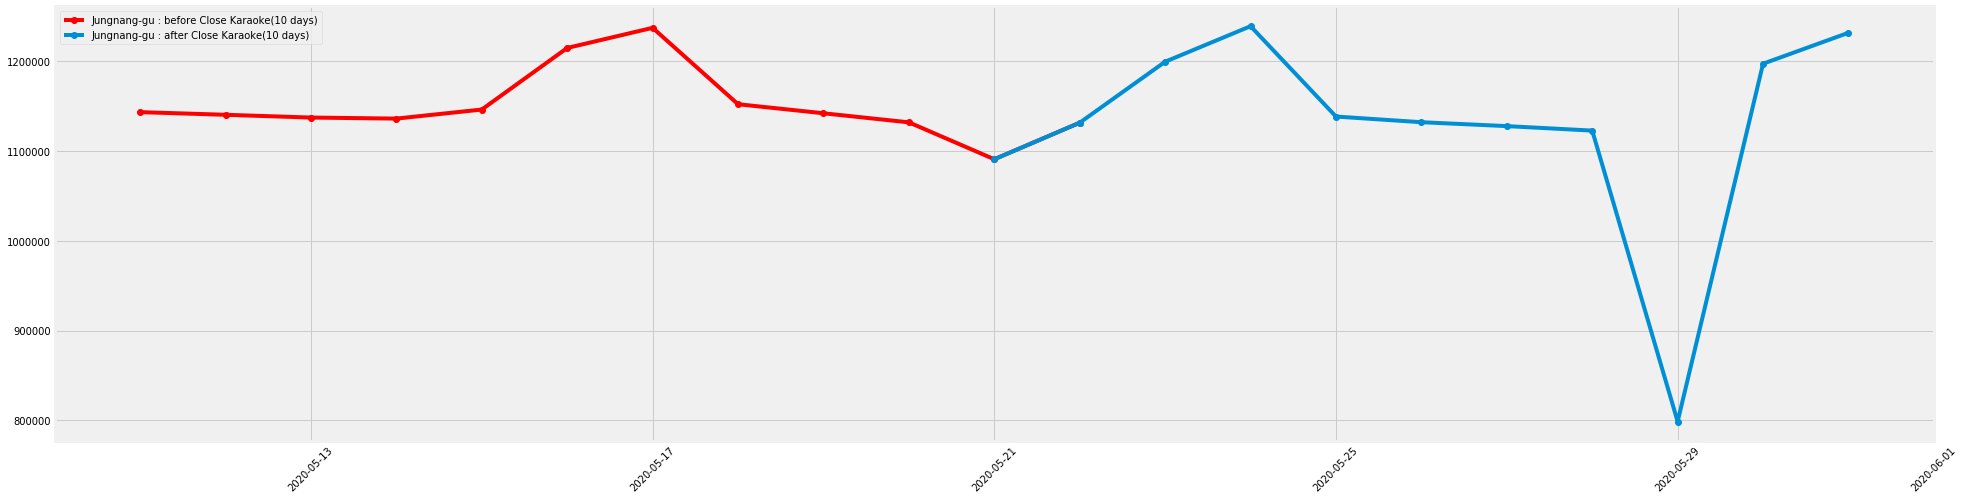

In [77]:
##중랑구
Jungnang = df_city20[df_city20['city'] == 'Jungnang-gu']

plt.figure()
plt.rcParams['figure.figsize'] = [30, 8] # [width, height]

xbefore=Jungnang['date'].loc[2244:2255] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore=Jungnang['fp_num'].loc[2244:2255] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='Jungnang-gu : before Close Karaoke(10 days)')

xafter=Jungnang['date'].loc[2254:2265]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter=Jungnang['fp_num'].loc[2254:2265]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='Jungnang-gu : after Close Karaoke(10 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 3지역의 유동인구 수 

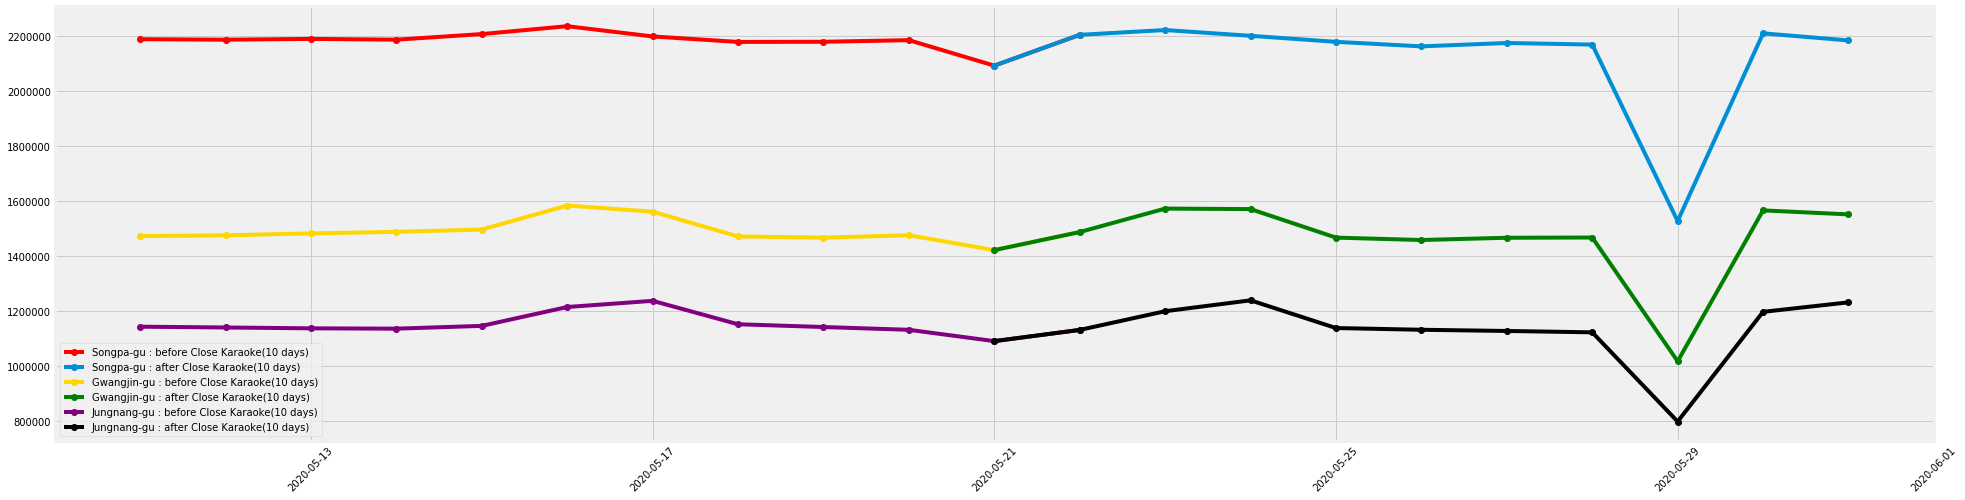

In [78]:
plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

xbefore1=Songpa['date'].loc[3301:3312] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore1=Songpa['fp_num'].loc[3301:3312] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Songpa-gu : before Close Karaoke(10 days)')

xafter1=Songpa['date'].loc[3311:3322]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter1=Songpa['fp_num'].loc[3311:3322]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Songpa-gu : after Close Karaoke(10 days)')

xbefore2=Gwangjin['date'].loc[1791:1802] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore2=Gwangjin['fp_num'].loc[1791:1802] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gwangjin-gu : before Close Karaoke(10 days)')

xafter2=Gwangjin['date'].loc[1801:1812]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter2=Gwangjin['fp_num'].loc[1801:1812]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gwangjin-gu : after Close Karaoke(10 days)')

xbefore3=Jungnang['date'].loc[2244:2255] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore3=Jungnang['fp_num'].loc[2244:2255] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Jungnang-gu : before Close Karaoke(10 days)')

xafter3=Jungnang['date'].loc[2254:2265]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter3=Jungnang['fp_num'].loc[2254:2265]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Jungnang-gu : after Close Karaoke(10 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

#### 노래방 Top 3인 송파구, 광진구, 중랑구의 20대 유동인구 (시간대별)

In [79]:
##송파구
Songpa_hour = age_20[age_20['city'] == 'Songpa-gu']
Songpa_hour = Songpa_hour.sort_values(by=["date", "hour"]) 
Songpa_hour.reset_index(inplace=True)
Songpa_hour

index       date  hour  birth_year     sex province       city  \
0          42 2020-01-01     0          20  female    Seoul  Songpa-gu   
1          43 2020-01-01     0          20    male    Seoul  Songpa-gu   
2          92 2020-01-01     1          20  female    Seoul  Songpa-gu   
3          93 2020-01-01     1          20    male    Seoul  Songpa-gu   
4         142 2020-01-01     2          20  female    Seoul  Songpa-gu   
...       ...        ...   ...         ...     ...      ...        ...   
7227   876015 2020-05-31    21          20    male    Seoul  Songpa-gu   
7228   952254 2020-05-31    22          20  female    Seoul  Songpa-gu   
7229   962263 2020-05-31    22          20    male    Seoul  Songpa-gu   
7230   892251 2020-05-31    23          20    male    Seoul  Songpa-gu   
7231  1064729 2020-05-31    23          20  female    Seoul  Songpa-gu   

      fp_num hour_cat  day_of_week  
0      48370     dawn            2  
1      46370     dawn            2  
2      47250     dawn            2  
3      45770     dawn            2  
4      45450     dawn            2  
...      ...      ...          ...  
7227   45670  evening            6  
7228   45540  evening            6  
7229   44620  evening            6  
7230   44120  evening            6  
7231   45210  evening            6  

[7232 rows x 10 columns]

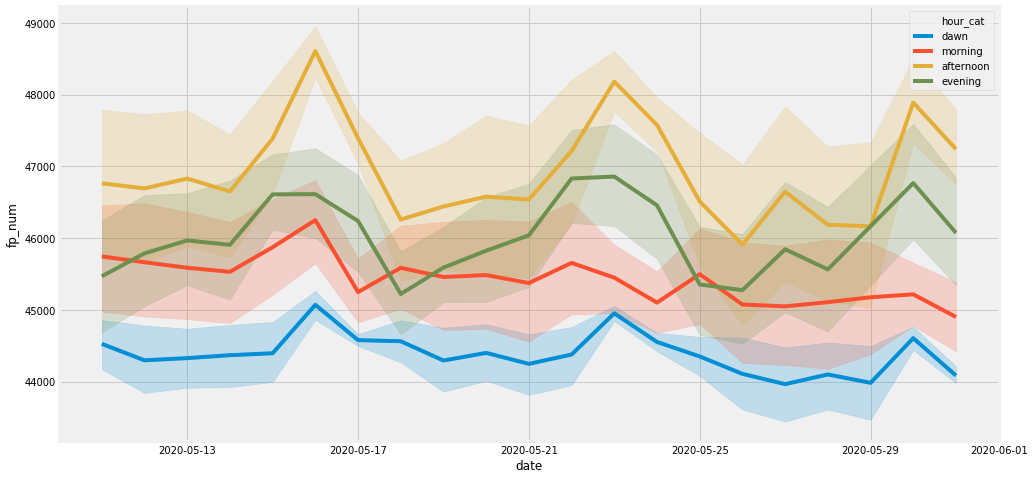

In [80]:
sing_Songpa = Songpa_hour[6240:7232]

plt.figure(figsize=(15,8))
sns.lineplot(data=sing_Songpa, x='date', y="fp_num", hue="hour_cat")

In [81]:
##광진구
Gwangjin_hour = age_20[age_20['city'] == 'Gwangjin-gu']
Gwangjin_hour = Gwangjin_hour.sort_values(by=["date", "hour"]) 
Gwangjin_hour.reset_index(inplace=True)
Gwangjin_hour

index       date  hour  birth_year     sex province         city  \
0          22 2020-01-01     0          20  female    Seoul  Gwangjin-gu   
1          23 2020-01-01     0          20    male    Seoul  Gwangjin-gu   
2          72 2020-01-01     1          20  female    Seoul  Gwangjin-gu   
3          73 2020-01-01     1          20    male    Seoul  Gwangjin-gu   
4         122 2020-01-01     2          20  female    Seoul  Gwangjin-gu   
...       ...        ...   ...         ...     ...      ...          ...   
7227  1046830 2020-05-31    21          20  female    Seoul  Gwangjin-gu   
7228   869891 2020-05-31    22          20  female    Seoul  Gwangjin-gu   
7229   992284 2020-05-31    22          20    male    Seoul  Gwangjin-gu   
7230   890237 2020-05-31    23          20    male    Seoul  Gwangjin-gu   
7231  1060717 2020-05-31    23          20  female    Seoul  Gwangjin-gu   

      fp_num hour_cat  day_of_week  
0      32070     dawn            2  
1      32720     dawn            2  
2      31570     dawn            2  
3      32680     dawn            2  
4      31270     dawn            2  
...      ...      ...          ...  
7227   34530  evening            6  
7228   34130  evening            6  
7229   32900  evening            6  
7230   32160  evening            6  
7231   33600  evening            6  

[7232 rows x 10 columns]

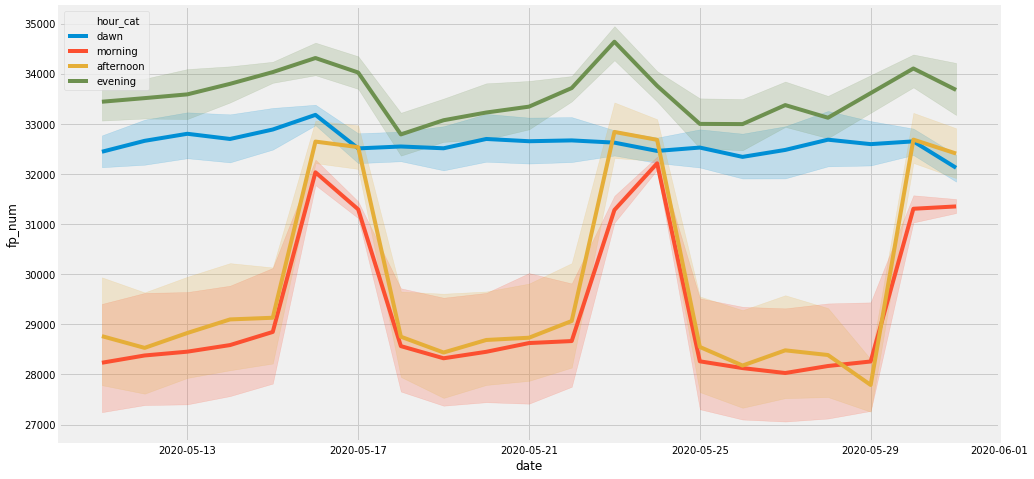

In [82]:
sing_Gwangjin = Gwangjin_hour[6240:7231]

plt.figure(figsize=(15,8))
sns.lineplot(data=sing_Gwangjin, x='date', y="fp_num", hue="hour_cat")

In [83]:
##중랑구
Jungnang_hour = age_20[age_20['city'] == 'Jungnang-gu']
Jungnang_hour = Jungnang_hour.sort_values(by=["date", "hour"]) 
Jungnang_hour.reset_index(inplace=True)
Jungnang_hour

index       date  hour  birth_year     sex province         city  \
0          28 2020-01-01     0          20  female    Seoul  Jungnang-gu   
1          29 2020-01-01     0          20    male    Seoul  Jungnang-gu   
2          78 2020-01-01     1          20  female    Seoul  Jungnang-gu   
3          79 2020-01-01     1          20    male    Seoul  Jungnang-gu   
4         128 2020-01-01     2          20  female    Seoul  Jungnang-gu   
...       ...        ...   ...         ...     ...      ...          ...   
7227  1028684 2020-05-31    21          20    male    Seoul  Jungnang-gu   
7228   972292 2020-05-31    22          20  female    Seoul  Jungnang-gu   
7229   980224 2020-05-31    22          20    male    Seoul  Jungnang-gu   
7230   876023 2020-05-31    23          20    male    Seoul  Jungnang-gu   
7231   990328 2020-05-31    23          20  female    Seoul  Jungnang-gu   

      fp_num hour_cat  day_of_week  
0      23820     dawn            2  
1      25030     dawn            2  
2      24440     dawn            2  
3      25490     dawn            2  
4      24880     dawn            2  
...      ...      ...          ...  
7227   25660  evening            6  
7228   26920  evening            6  
7229   26460  evening            6  
7230   26880  evening            6  
7231   27350  evening            6  

[7232 rows x 10 columns]

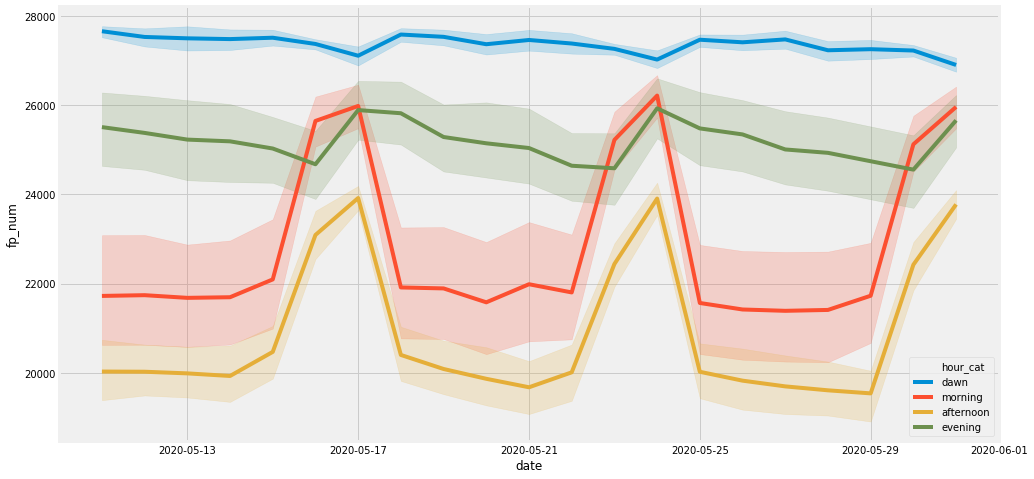

In [84]:
sing_Jungnang = Jungnang_hour[6240:7231]

plt.figure(figsize=(15,8))
sns.lineplot(data=sing_Jungnang, x='date', y="fp_num", hue="hour_cat")

환경 빅데이터 플랫폼에서 제공하는 **'행정동별 노래방분야 소비인구'** 데이터 셋을 통해 소비인구 top 3 지역은 **마포구, 광진구, 노원구**로 판명되었다. 따라서, 해당 지역에 대한 EDA를 진행한다. (추가 데이터셋을 사용해도 되는 지 알 수 없어 분석을 진행하지 않았지만 가능하다면 해당 명령의 실효성을 파악하기에 유의미한 데이터셋일 것으로 생각된다.)

#### 마포구, 광진구, 노원구의 20대 유동인구

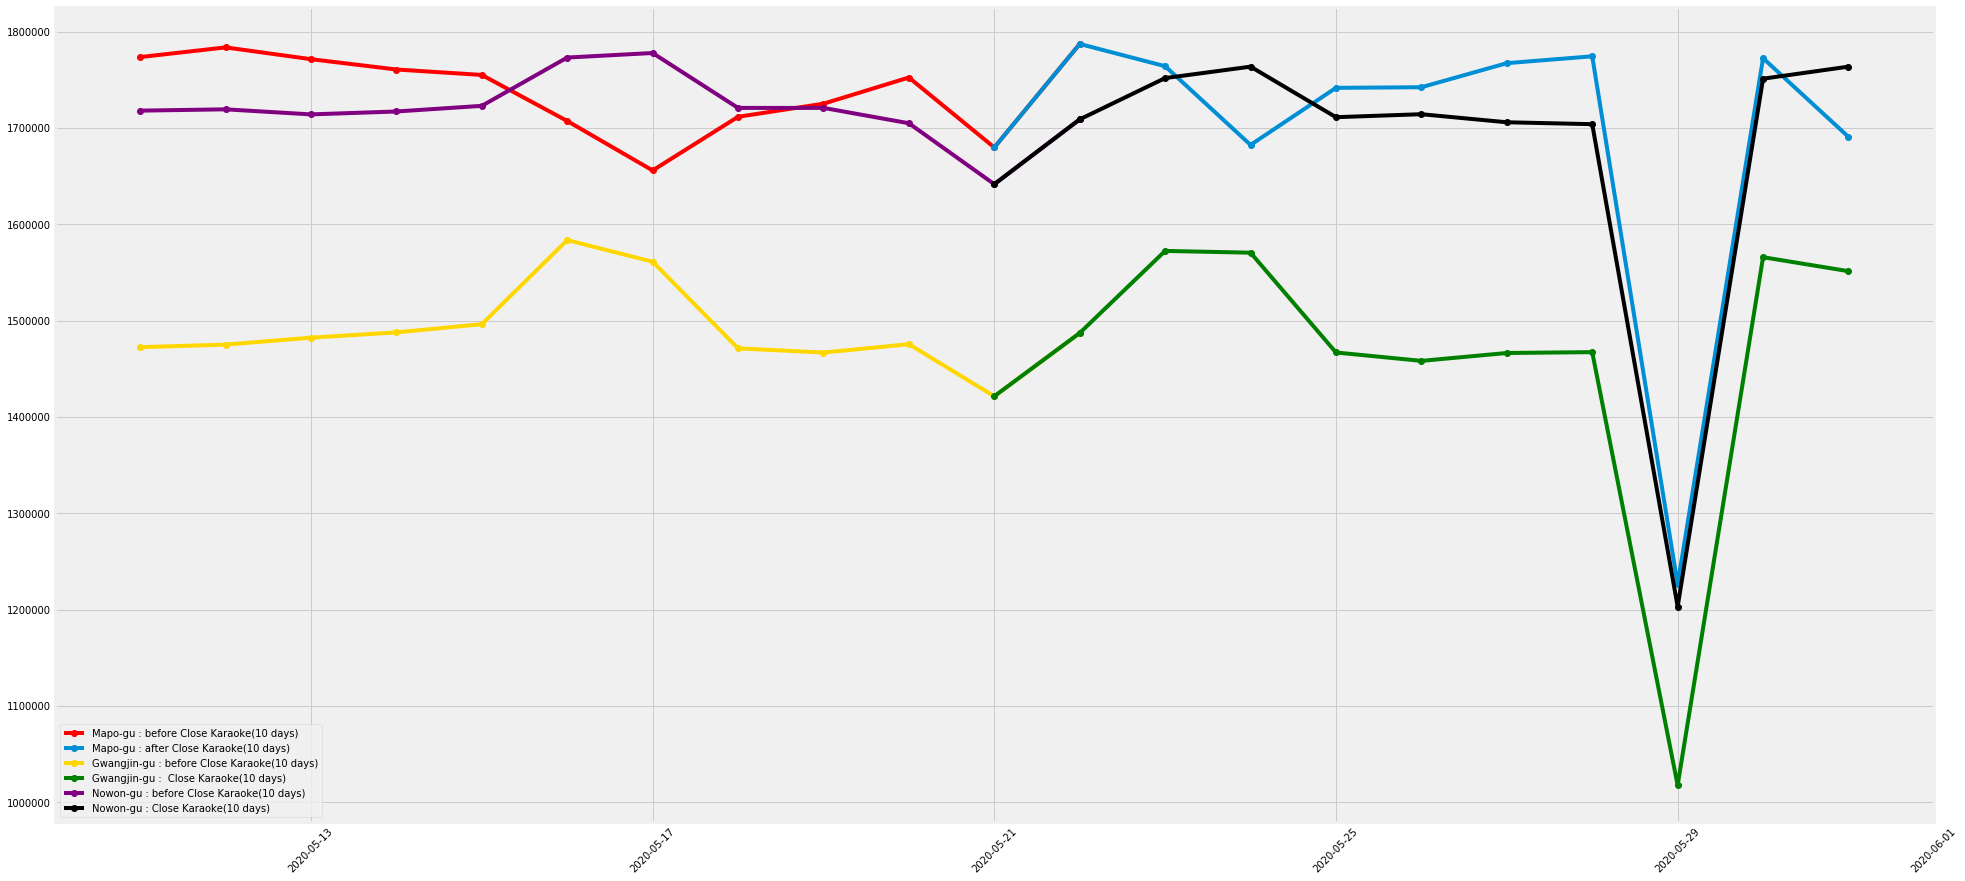

In [85]:
##마포구
Mapo = df_city20[df_city20['city'] == 'Mapo-gu']

##광진구
Gwangjin = df_city20[df_city20['city'] == 'Gwangjin-gu']

##노원구
Nowon = df_city20[df_city20['city'] == 'Nowon-gu']

plt.figure()
plt.rcParams['figure.figsize'] = [30, 15] # [width, height]

xbefore1=Mapo['date'].loc[2395:2406] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore1=Mapo['fp_num'].loc[2395:2406] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore1, ybefore1, marker='o', color='r', label='Mapo-gu : before Close Karaoke(10 days)')

xafter1=Mapo['date'].loc[2405:2416]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter1=Mapo['fp_num'].loc[2405:2416]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter1, yafter1, marker='o', label='Mapo-gu : after Close Karaoke(10 days)')

xbefore2=Gwangjin['date'].loc[1791:1802] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore2=Gwangjin['fp_num'].loc[1791:1802] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore2, ybefore2, marker='o', color='gold', label='Gwangjin-gu : before Close Karaoke(10 days)')

xafter2=Gwangjin['date'].loc[1801:1812]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter2=Gwangjin['fp_num'].loc[1801:1812]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter2, yafter2, marker='o', color='green', label='Gwangjin-gu :  Close Karaoke(10 days)')

xbefore3=Nowon['date'].loc[2546:2557] # 5월 11일 ~ 5월 21일을 x축으로 지정
ybefore3=Nowon['fp_num'].loc[2546:2557] # 5월 11일 ~ 5월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore3, ybefore3, marker='o', color='purple', label='Nowon-gu : before Close Karaoke(10 days)')

xafter3=Nowon['date'].loc[2556:2567]  # 5월 21일부터 5월 31일을 x축으로 지정
yafter3=Nowon['fp_num'].loc[2556:2567]  # 5월 21일부터 5월 31일까지의 확진자수를 y축으로 지정
plt.plot(xafter3, yafter3, marker='o', color='black', label='Nowon-gu : Close Karaoke(10 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.legend()
plt.show()

---
## 3. 지방자치단체 행정명령에 대한 EDA
      지방자치단체 행정명령 - 취약계층이 이용하는 요양원, 노인어린이집, 정신병원에 대한 행정명령 제한수집
      정책 시작일과 종료일 기준 +- 2주까지 비교 (종료일 X)    
      
#### 지방자치단체 행정명령 시작일(2020-05-16) 기준 일별 고령층 확진자 수

In [236]:
Patientinfo_nonnull = Patientinfo[Patientinfo['age'].notnull()]
Patientinfo_nonnull['age'] = Patientinfo_nonnull['age'].astype('int')

elder = Patientinfo_nonnull[Patientinfo_nonnull['age']>=60]
elder

patient_id     sex  age country          province           city  \
9     1000000010  female   60   Korea             Seoul    Seongbuk-gu   
12    1000000013    male   80   Korea             Seoul      Jongno-gu   
13    1000000014  female   60   Korea             Seoul      Jongno-gu   
14    1000000015    male   70   Korea             Seoul   Seongdong-gu   
15    1000000016    male   70   Korea             Seoul      Jongno-gu   
...          ...     ...  ...     ...               ...            ...   
5112  6100000100  female   60   Korea  Gyeongsangnam-do       Jinju-si   
5116  6100000104  female   70   Korea  Gyeongsangnam-do  Sancheong-gun   
5124  6100000112    male   60   Korea  Gyeongsangnam-do   Hapcheon-gun   
5128  6100000116    male   60   Korea  Gyeongsangnam-do    Changwon-si   
5134  6100000122    male   60   Korea  Gyeongsangnam-do       Jinju-si   

            infection_case infected_by contact_number symptom_onset_date  \
9     contact with patient  1000000003              6                NaN   
12    contact with patient  1000000017            117                NaN   
13    contact with patient  1000000013             27         2020-02-06   
14        Seongdong-gu APT         NaN              8         2020-02-11   
15    contact with patient  1000000017            NaN                NaN   
...                    ...         ...            ...                ...   
5112                   etc  6100000097            NaN         2020-03-28   
5116                   etc  6100000097            NaN         2020-03-26   
5124  contact with patient  6100000100            NaN         2020-04-03   
5128                   etc         NaN            NaN         2020-04-20   
5134                   etc         NaN            NaN         2020-05-21   

     confirmed_date released_date deceased_date     state  
9        2020-02-05    2020-02-29           NaN  released  
12       2020-02-16           NaN           NaN  deceased  
13       2020-02-16    2020-03-12           NaN  released  
14       2020-02-19           NaN           NaN  released  
15       2020-02-19    2020-03-11           NaN  released  
...             ...           ...           ...       ...  
5112     2020-03-31           NaN           NaN  released  
5116     2020-03-31           NaN           NaN  released  
5124     2020-04-07           NaN           NaN  released  
5128     2020-04-21    2020-05-15           NaN  released  
5134     2020-05-22           NaN           NaN  released  

[934 rows x 14 columns]

In [237]:
elder['age'] = elder['age'].astype('str')
b = elder[['patient_id', 'age', 'confirmed_date']].sort_values(by = 'confirmed_date').dropna(subset=['confirmed_date']).reset_index(drop=True)

b['number']=range(1,len(b)+1)
b['60'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['60'] if '60' in b.age.iloc[: x].value_counts() else 0)
b['70'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['70'] if '70' in b.age.iloc[: x].value_counts() else 0)
b['80'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['80'] if '80' in b.age.iloc[: x].value_counts() else 0)
b['90'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['90'] if '90' in b.age.iloc[: x].value_counts() else 0)

#보기 좋게 confirmed date를 인덱스로 보내주기
b.set_index('confirmed_date')

patient_id age  number   60   70   80  90
confirmed_date                                           
2020-01-30      5000000001  60       1    1    0    0   0
2020-02-05      1000000010  60       2    2    0    0   0
2020-02-09      2000000008  70       3    2    1    0   0
2020-02-16      1000000013  80       4    2    1    1   0
2020-02-16      1000000014  60       5    3    1    1   0
...                    ...  ..     ...  ...  ...  ...  ..
2020-06-28      1300000041  60     930  480  230  170  49
2020-06-28      1300000042  70     931  480  231  170  49
2020-06-29      1300000044  60     932  481  231  170  49
2020-06-29      1300000043  60     933  482  231  170  49
2020-06-30      1500000119  70     934  482  232  170  49

[934 rows x 7 columns]

#### 전 기간 동안 연령대별 확진자수 추이

<Figure size 2880x720 with 0 Axes>

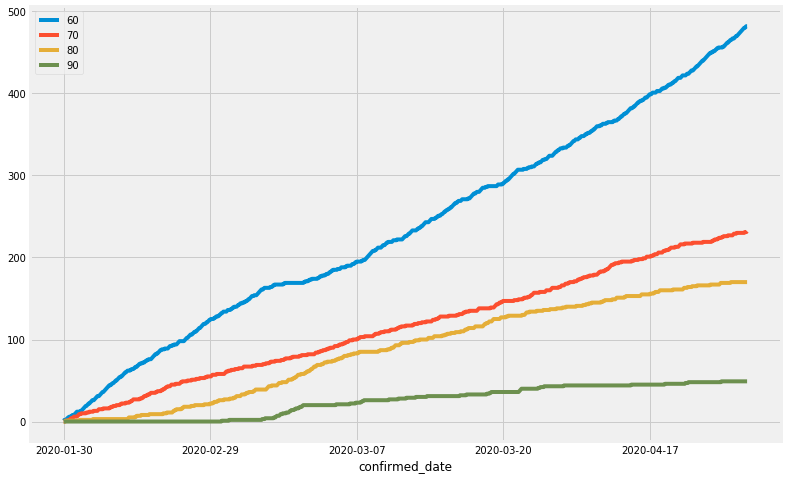

In [238]:
#연령대별 확진자수 추이 살펴보기
plt.figure()
b.plot(kind='line', y=['60', '70', '80','90'], x='confirmed_date', figsize = (12,8))
plt.show()

#### 제한명령 도입 1달 전부터 연령대별 확진자수 추이

<Figure size 2880x720 with 0 Axes>

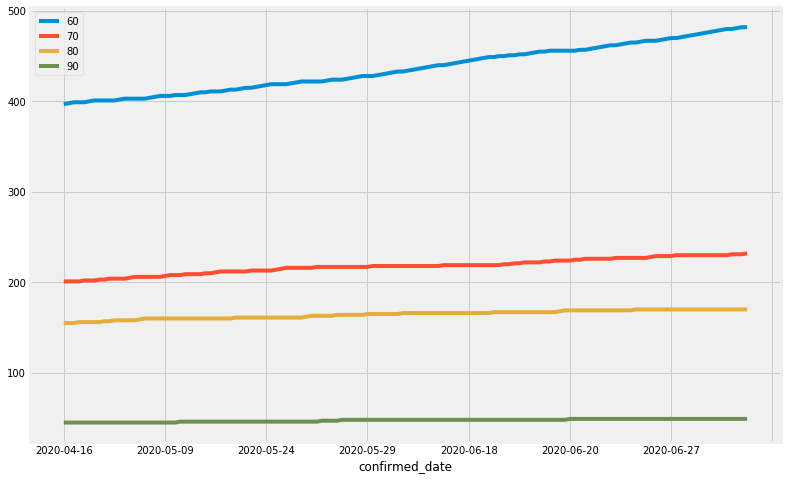

In [239]:
plt.figure()
b.loc[(b['confirmed_date']>='2020-04-16')].plot(kind='line', y=['60', '70', '80','90'], x='confirmed_date', figsize=(12,8))
plt.show()

제한 명령 도입 약 10일 후(2020-05-26)부터 확진자 증가율 감소

#### 제한명령 도입 1달 전부터 고령층 확진자수 추이 (TimeAge 데이터셋 활용)

In [240]:
TimeAge['age'] = TimeAge["age"].str.replace('s',"") # 연령대 정렬을 위한 문자열 제거
TimeAge['age'] = TimeAge['age'].astype('int')

In [241]:
TimeAge_elder = TimeAge[TimeAge['age']>=60]

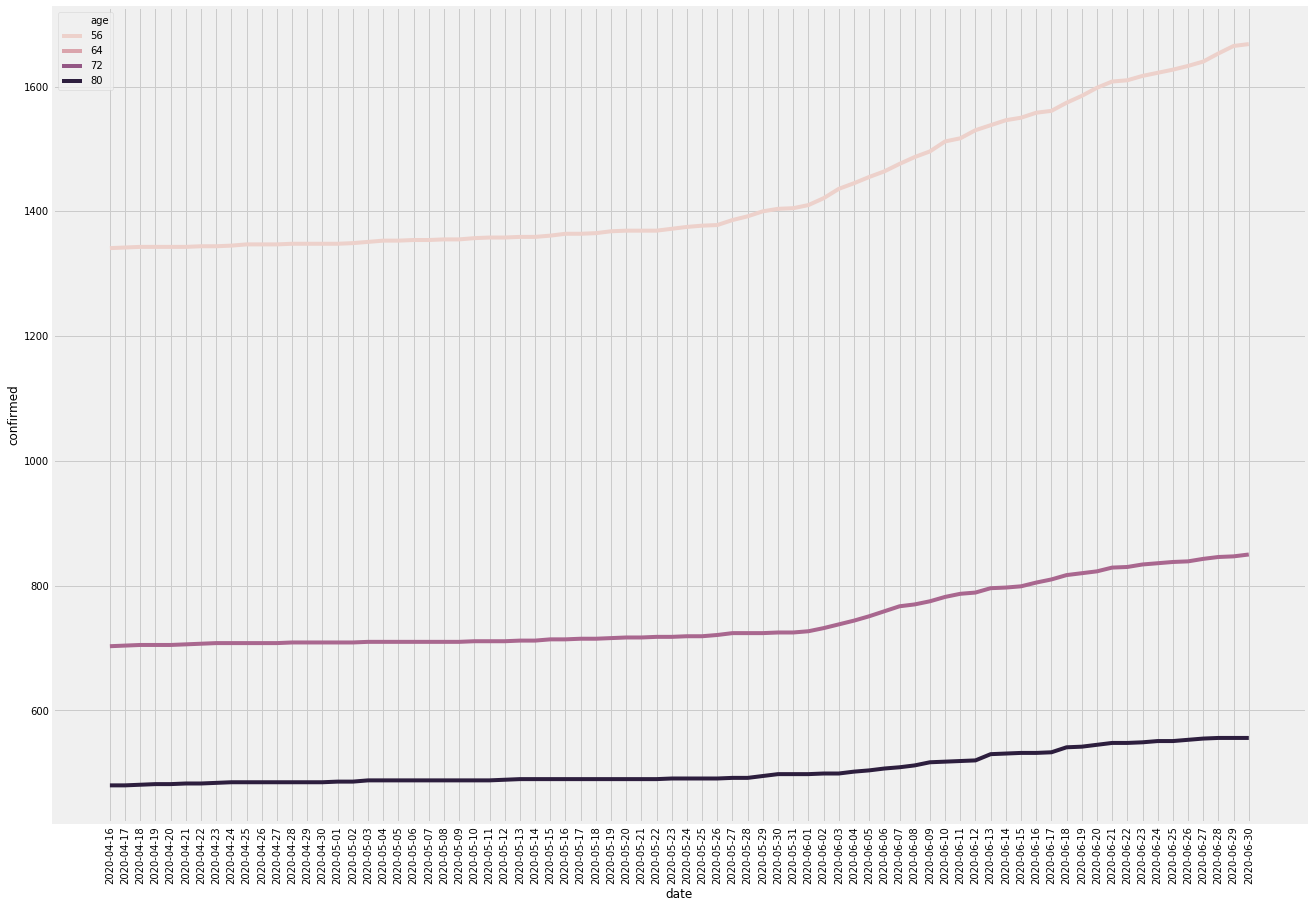

In [242]:
plt.figure(figsize = (20,15))
tt = TimeAge_elder.loc[(TimeAge_elder['date']>='2020-04-16')]
sns.lineplot(data=tt, x='date', y='confirmed', hue = 'age')
plt.xticks(rotation=90) #x축 글자 기울이기
plt.show()

#### 제한명령 도입 1달 전부터 고령층 사망자수 추이 (TimeAge 데이터셋 활용)

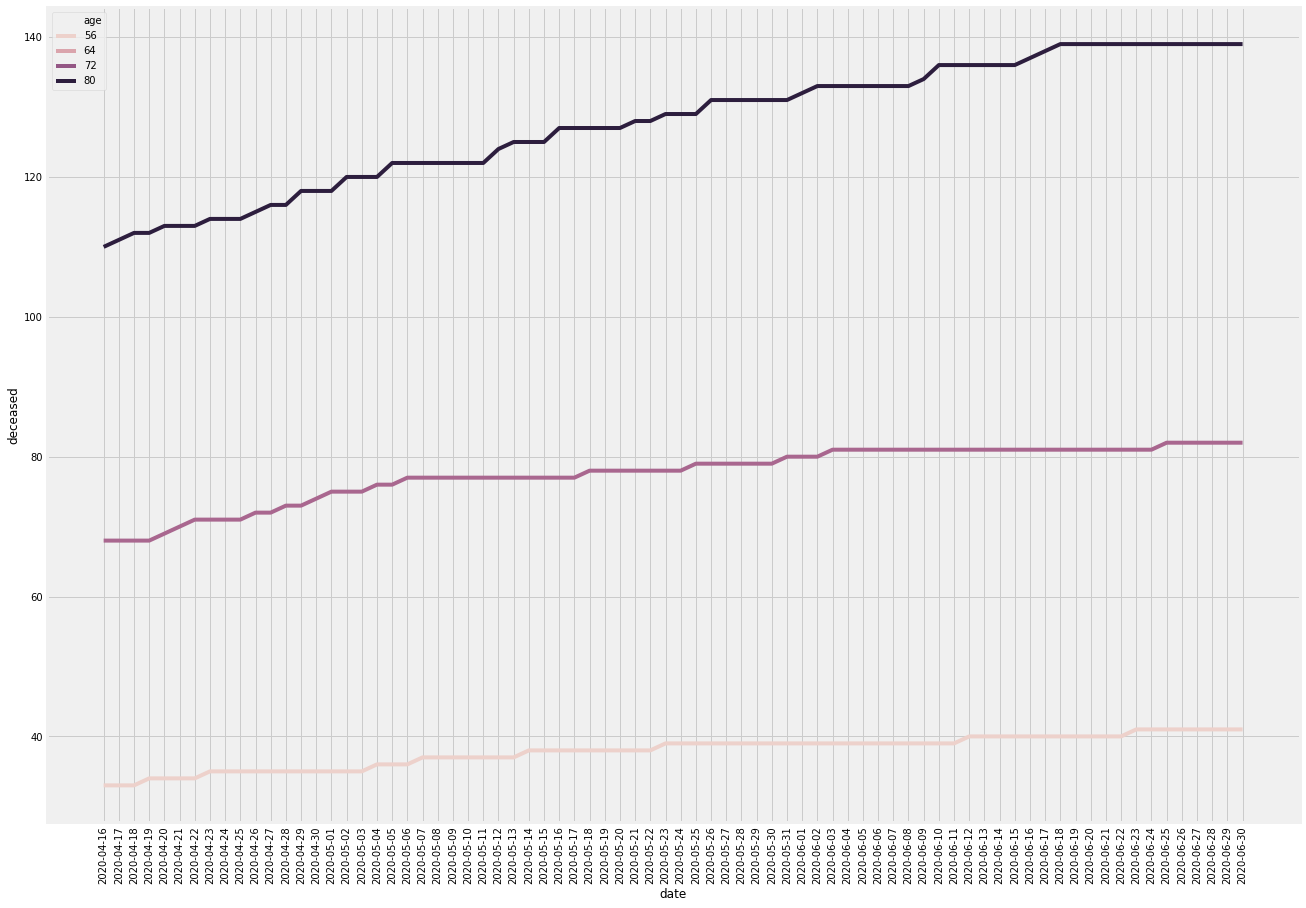

In [243]:
plt.figure(figsize = (20,15))
tt = TimeAge_elder.loc[(TimeAge_elder['date']>='2020-04-16')]
sns.lineplot(data=tt, x='date', y='deceased', hue = 'age')
plt.xticks(rotation=90) #x축 글자 기울이기
plt.show()

#### 전체기간 동안 고령층 분포

In [244]:
elder['age'] = elder['age'].astype('int')

In [245]:
elders_date = pd.DataFrame(elder['confirmed_date'].value_counts())
elders_date.reset_index(inplace=True)
elders_date = elders_date.sort_values(by=["index"]) 
elders_date.reset_index(inplace=True, drop=True)
elders_date

index  confirmed_date
0    2020-01-30               1
1    2020-02-05               1
2    2020-02-09               1
3    2020-02-16               2
4    2020-02-18               2
5    2020-02-19               8
6    2020-02-20              10
7    2020-02-21              12
8    2020-02-22              15
9    2020-02-23              16
10   2020-02-24              12
11   2020-02-25              26
12   2020-02-26              29
13   2020-02-27              17
14   2020-02-28              39
15   2020-02-29              17
16   2020-03-01              28
17   2020-03-02              10
18   2020-03-03              14
19   2020-03-04              26
20   2020-03-05              66
21   2020-03-06              38
22   2020-03-07              22
23   2020-03-08              15
24   2020-03-09               9
25   2020-03-10              17
26   2020-03-11              16
27   2020-03-12               5
28   2020-03-13               8
29   2020-03-14              13
30   2020-03-15              12
31   2020-03-16              12
32   2020-03-17              14
33   2020-03-18              13
34   2020-03-19              15
35   2020-03-20              40
36   2020-03-21               8
37   2020-03-22               6
38   2020-03-23               2
39   2020-03-24              12
40   2020-03-25               9
41   2020-03-26              13
42   2020-03-27               7
43   2020-03-28               6
44   2020-03-29              15
45   2020-03-30               6
46   2020-03-31              19
47   2020-04-01              10
48   2020-04-02              15
49   2020-04-03              11
50   2020-04-04               7
51   2020-04-05               8
52   2020-04-06               6
53   2020-04-07               8
54   2020-04-08               2
55   2020-04-09               7
56   2020-04-10               2
57   2020-04-11               4
58   2020-04-12               5
59   2020-04-13               5
60   2020-04-14               3
61   2020-04-15               1
62   2020-04-16               2
63   2020-04-17               2
64   2020-04-20               1
65   2020-04-21               3
66   2020-04-22               2
67   2020-04-23               2
68   2020-04-24               1
69   2020-04-27               1
70   2020-05-02               4
71   2020-05-03               1
72   2020-05-07               1
73   2020-05-09               1
74   2020-05-12               2
75   2020-05-13               1
76   2020-05-14               1
77   2020-05-15               3
78   2020-05-16               1
79   2020-05-17               1
80   2020-05-20               1
81   2020-05-21               1
82   2020-05-22               4
83   2020-05-23               4
84   2020-05-24               1
85   2020-05-25               2
86   2020-05-26               4
87   2020-05-27               1
88   2020-05-28               6
89   2020-05-29               8
90   2020-06-01               1
91   2020-06-02               3
92   2020-06-04               1
93   2020-06-05               1
94   2020-06-15               3
95   2020-06-16               2
96   2020-06-17               6
97   2020-06-18               5
98   2020-06-19               7
99   2020-06-20              10
100  2020-06-21               2
101  2020-06-22               2
102  2020-06-23               6
103  2020-06-24               3
104  2020-06-25               4
105  2020-06-26               1
106  2020-06-27               8
107  2020-06-28               6
108  2020-06-29               2
109  2020-06-30               1

No handles with labels found to put in legend.


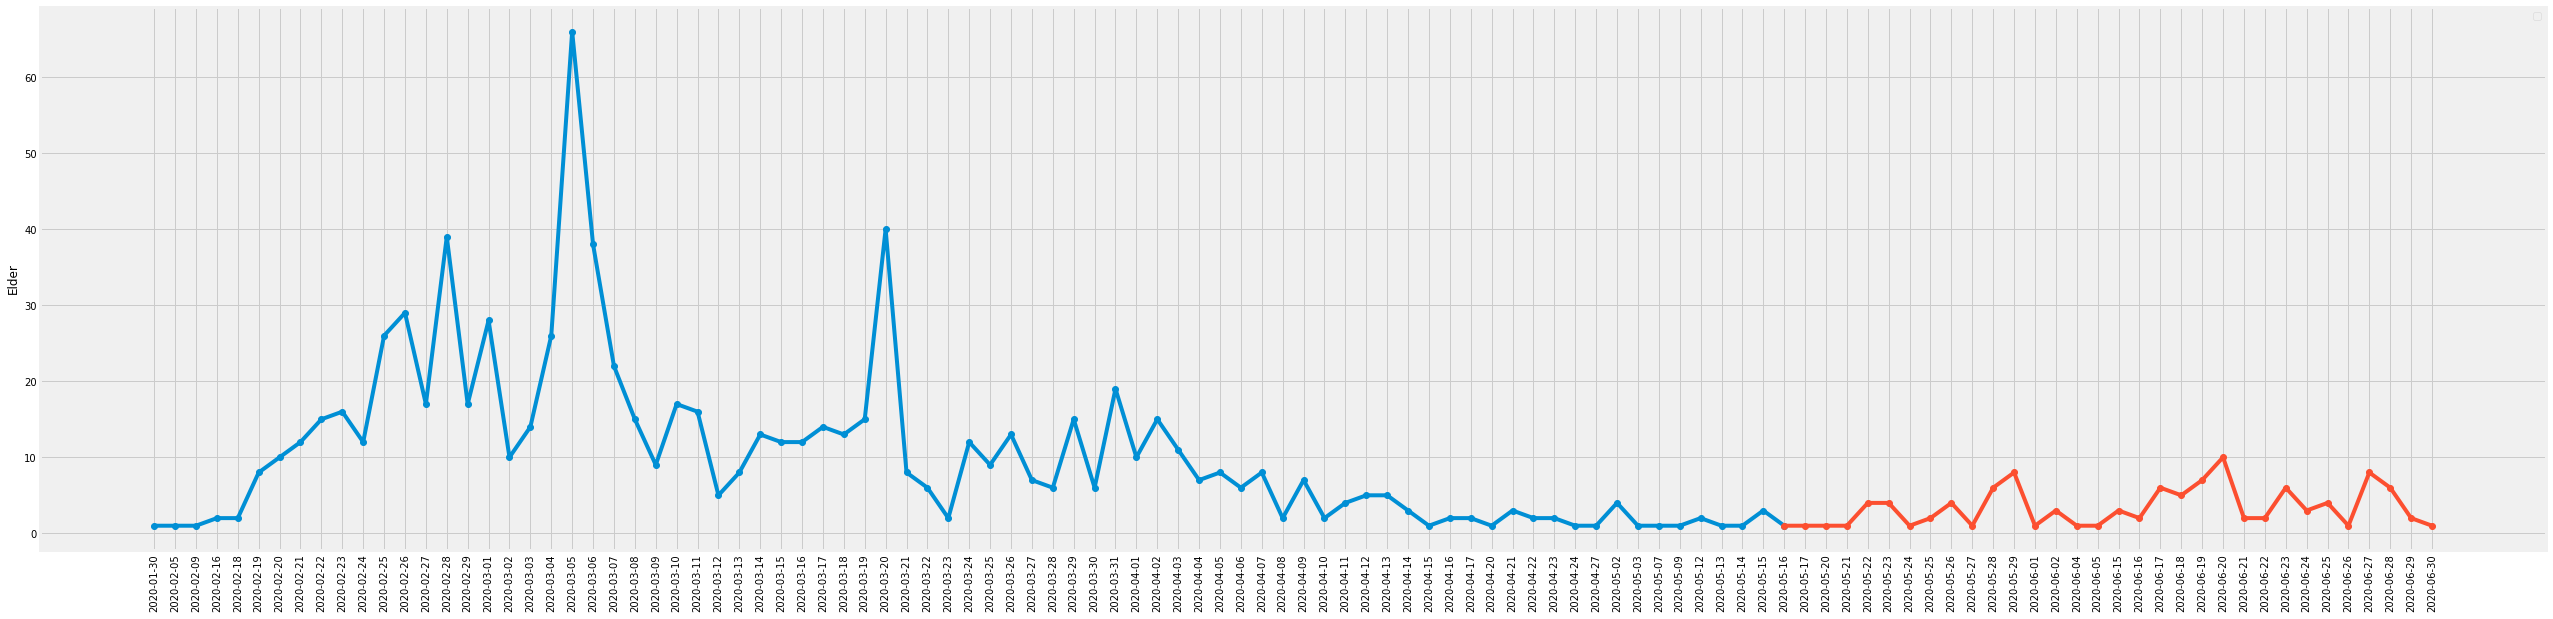

In [246]:
date = elders_date['index'] #날짜 column
conNum = elders_date['confirmed_date'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [40, 10] # [width, height]

xbefore=date[0:79] 
ybefore=conNum[0:79]
plt.plot(xbefore, ybefore, marker='o')

xafter=date[78:110] 
yafter=conNum[78:110]
plt.plot(xafter, yafter, marker='o')

plt.xticks(rotation=90) #x축 글자 기울이기
plt.ylabel("Elder")
plt.legend()
plt.show()

In [247]:
march_5th = elder[elder['confirmed_date']=='2020-03-05']
march_5th = pd.DataFrame(march_5th['infection_case'].value_counts())
march_5th.reset_index(inplace=True)
march_5th = march_5th.sort_values(by=["index"]) 
march_5th.reset_index(inplace=True, drop=True)
march_5th

index  infection_case
0            Bonghwa Pureun Nursing Home               3
1  Gyeongsan Cham Joeun Community Center               3
2             Gyeongsan Jeil Silver Town               1
3                     Shincheonji Church               1
4                   contact with patient               2
5                                    etc              10

확진자가 가장 많이 나온 2020-03-05를 보면 etc를 제외하고서는 봉화푸른요양원과 경산참좋은재가센터의 확진자 수가 가장 많은 데, 해당 장소는 모두 고령층의 인구가 많이 분포하는 장소이다. 또한, 그래프를 보면 행정명령 이후 고령층의 확진자 수가 감소한 것을 확인할 수 있다.

---
#### 감염 Case (전체 기간)

In [248]:
elder['age'] = elder['age'].astype('int')

In [249]:
elder_case = pd.DataFrame(elder['infection_case'].value_counts())
elder_case.reset_index(inplace=True)
elder_case = elder_case.sort_values(by=["index"]) 
elder_case.reset_index(inplace=True, drop=True)
elder_case

index  infection_case
0             Bonghwa Pureun Nursing Home              23
1                Changnyeong Coin Karaoke               1
2                Cheongdo Daenam Hospital               8
3                Coupang Logistics Center               1
4                           Dongan Church               3
5                 Dunsan Electronics Town              12
6           Eunpyeong St. Mary's Hospital              11
7                         Geochang Church               3
8                     Guro-gu Call Center              10
9   Gyeongsan Cham Joeun Community Center               9
10             Gyeongsan Jeil Silver Town              10
11          Gyeongsan Seorin Nursing Home              12
12                          Itaewon Clubs               3
13                          Onchun Church               3
14                            Orange Town               4
15                   Pilgrimage to Israel               1
16                                Richway               3
17       SMR Newly Planted Churches Group               3
18        Samsung Fire & Marine Insurance               1
19                       Seongdong-gu APT               2
20  Seoul City Hall Station safety worker               1
21                     Shincheonji Church              21
22                   contact with patient             290
23                                    etc             199
24                gym facility in Cheonan               2
25                        overseas inflow              53

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text yticklabel objects>)

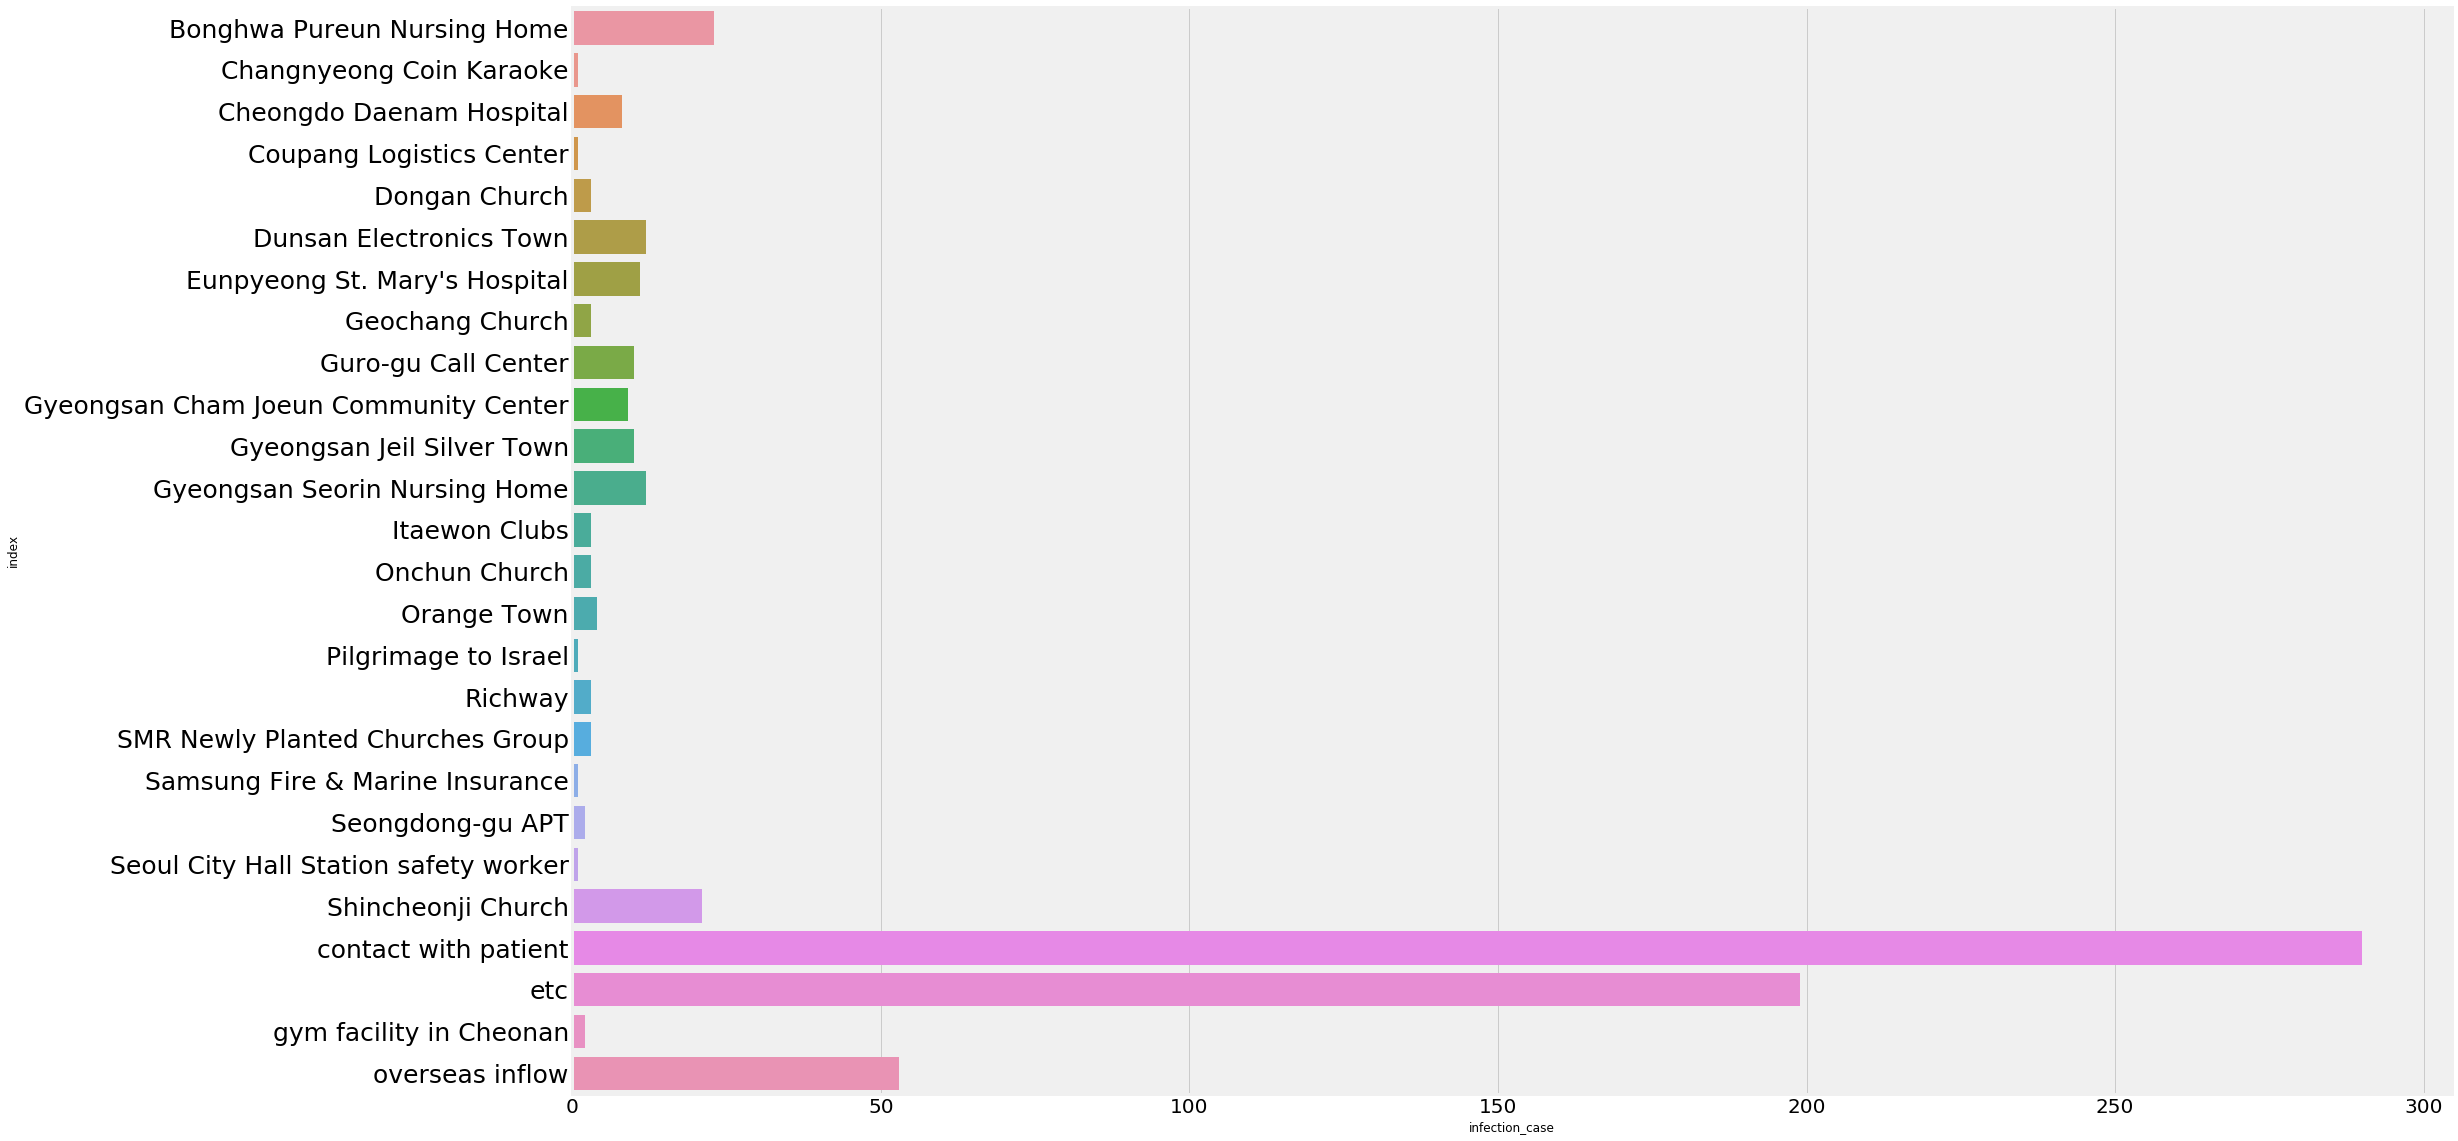

In [251]:
plt.figure()
plt.rcParams['figure.figsize'] = [30, 20] # [width, height]
sns.barplot(x='infection_case', y='index', data=elder_case)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=25)

주 감염경로로 알려진 환자 접촉과 자세한 감염 원인을 알 수 없는 기타 항목이 너무 많다. 두 경우를 제외해보자.

In [252]:
elder_etc = elder_case[elder_case['index'] != 'contact with patient']
elder_etc = elder_etc[elder_etc['index'] != 'etc']
elder_etc

index  infection_case
0             Bonghwa Pureun Nursing Home              23
1                Changnyeong Coin Karaoke               1
2                Cheongdo Daenam Hospital               8
3                Coupang Logistics Center               1
4                           Dongan Church               3
5                 Dunsan Electronics Town              12
6           Eunpyeong St. Mary's Hospital              11
7                         Geochang Church               3
8                     Guro-gu Call Center              10
9   Gyeongsan Cham Joeun Community Center               9
10             Gyeongsan Jeil Silver Town              10
11          Gyeongsan Seorin Nursing Home              12
12                          Itaewon Clubs               3
13                          Onchun Church               3
14                            Orange Town               4
15                   Pilgrimage to Israel               1
16                                Richway               3
17       SMR Newly Planted Churches Group               3
18        Samsung Fire & Marine Insurance               1
19                       Seongdong-gu APT               2
20  Seoul City Hall Station safety worker               1
21                     Shincheonji Church              21
24                gym facility in Cheonan               2
25                        overseas inflow              53

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text yticklabel objects>)

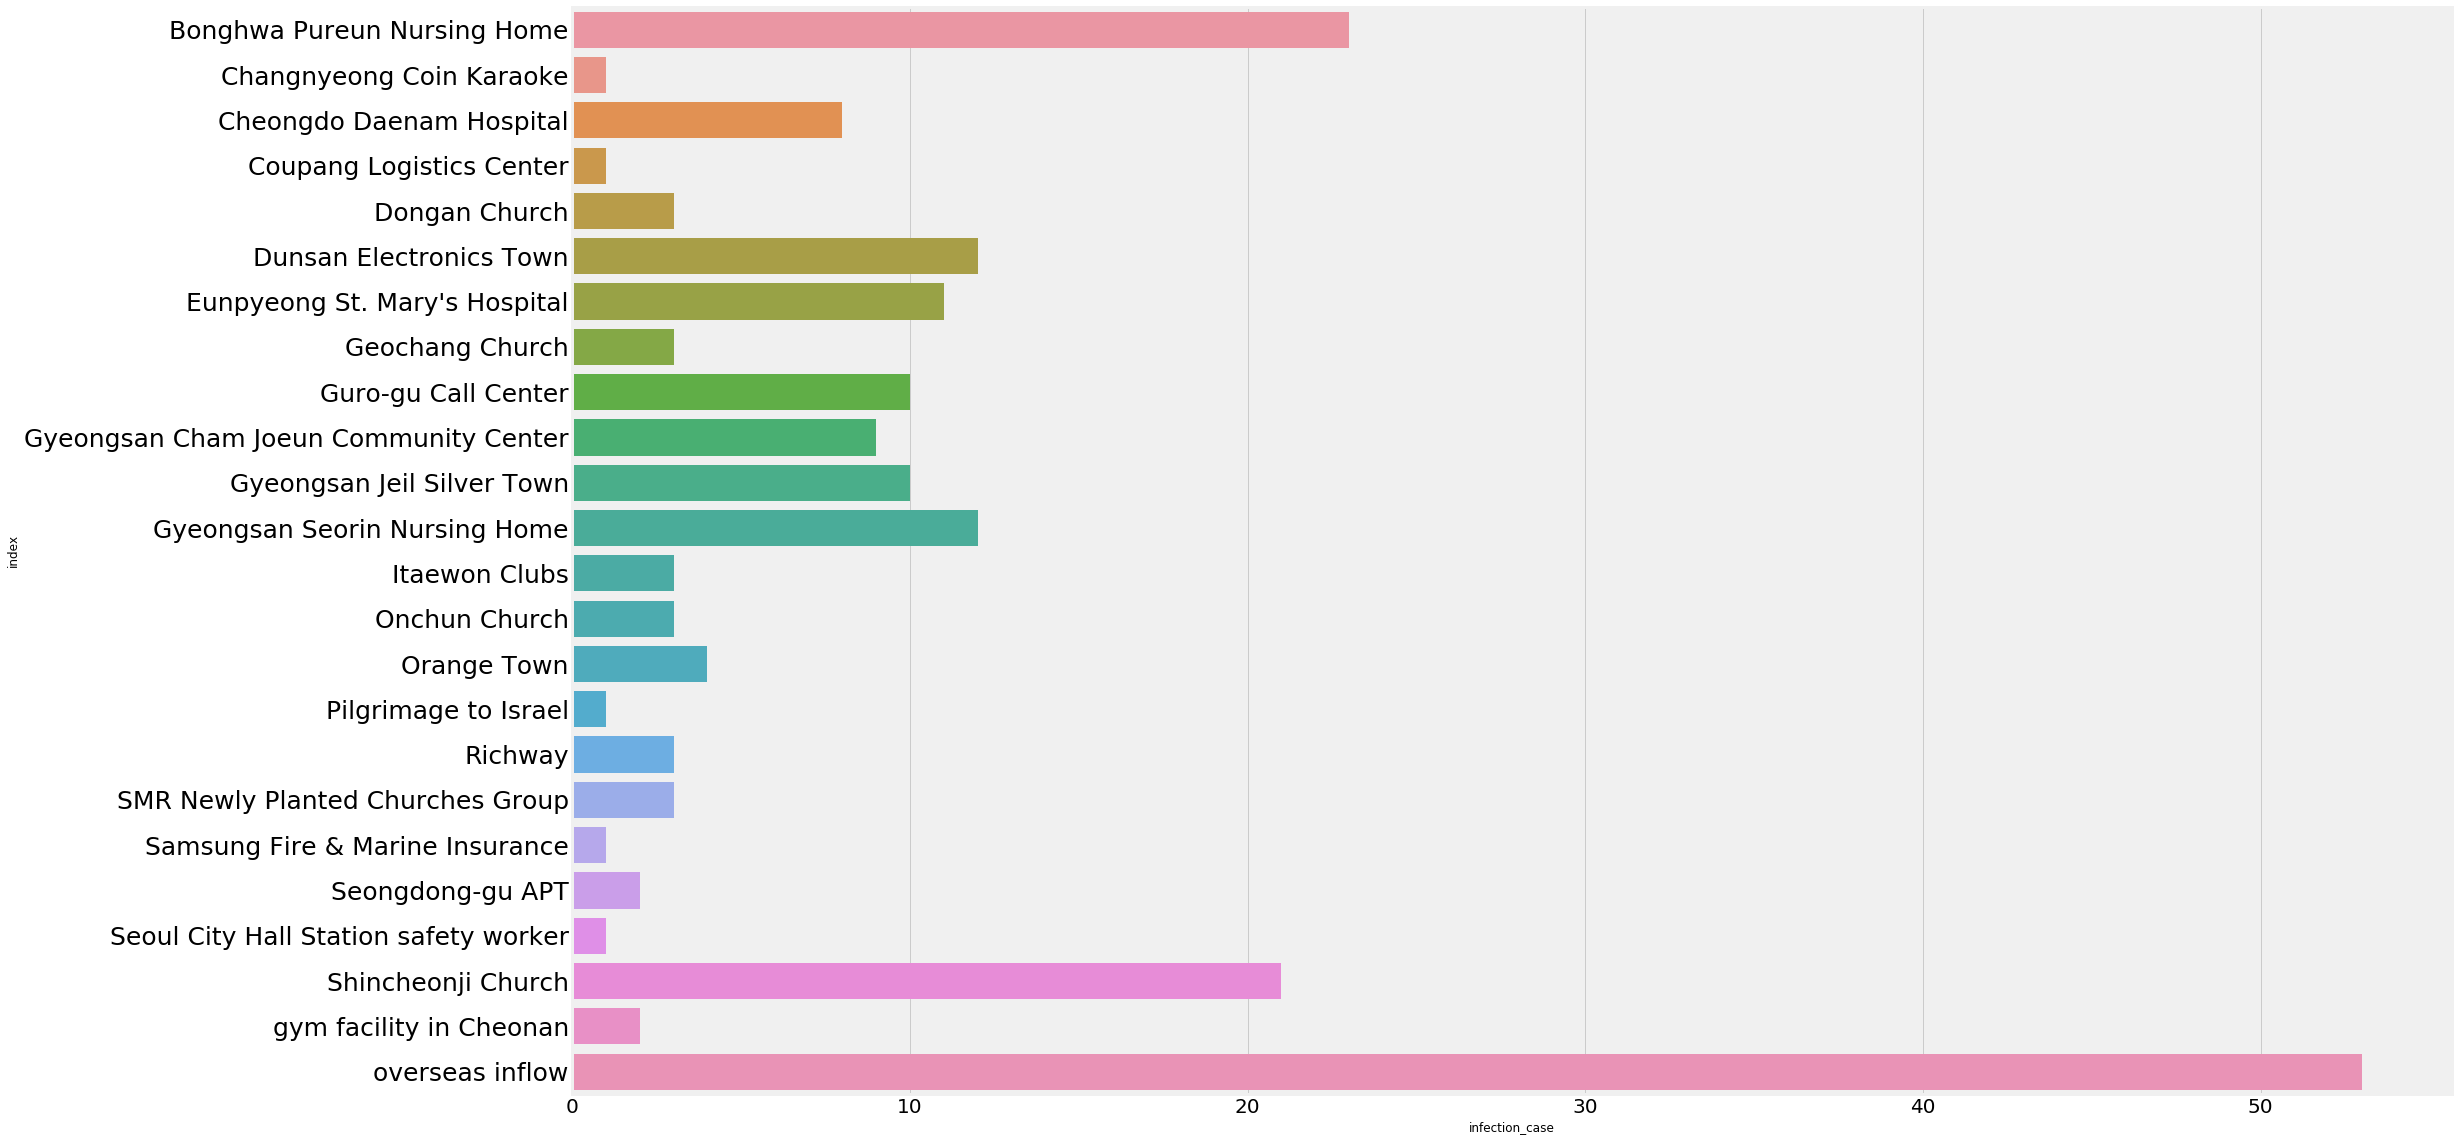

In [254]:
plt.figure()
plt.rcParams['figure.figsize'] = [30, 20] # [width, height]
sns.barplot(x='infection_case', y='index', data=elder_etc)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=25)

해외 입국, 요양원, 신천지가 가장 많다. 전체적으로 살펴보면, **요양원, 실버타운, 병원의 경우가 많은 것을 확인할 수 있다.** 교회나 병원뿐만 아니라 고령층이 집단으로 생활하는 시설에는 더욱 철저한 생활 방역이 필요하다는 점을 알 수 있다. infection_case 중 요양병원, 실버타운과 같이 고령층이 밀집된 장소와 관련된 추출하여 살펴보자.
#### 고령층 밀집 장소

In [255]:
elder_spot = ['Bonghwa Pureun Nursing Home','Cheongdo Daenam Hospital',"Eunpyeong St. Mary's Hospital",'Gyeongsan Jeil Silver Town','Gyeongsan Seorin Nursing Home','Gyeongsan Cham Joeun Community Center']

In [256]:
elders_spot = elder[elder['infection_case']==elder_spot[0]]

for i in elder_spot[1:7]:
    tt = elder[elder['infection_case']==i]
    elders_spot = pd.concat([elders_spot, tt], axis=0)    

elders_spot

patient_id     sex  age country          province          city  \
4573  6008000003  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4576  6008000006  female   90   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4579  6008000009  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4581  6008000011  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4586  6008000016  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4604  6008000034  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4606  6008000036  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4624  6008000054  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4625  6008000055  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4626  6008000056  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4627  6008000057  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4628  6008000058  female   70   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4629  6008000059  female   90   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4630  6008000060  female   90   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4631  6008000061    male   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4632  6008000062  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4633  6008000063  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4634  6008000064  female   70   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4635  6008000065  female   90   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4636  6008000066    male   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4637  6008000067  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4638  6008000068  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4639  6008000069    male   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
4866  6020000003    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4869  6020000006    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4872  6020000009    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4879  6020000016    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4888  6020000025  female   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4902  6020100104    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4903  6020100107    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4905  6020100286    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
24    1000000025    male   60   Korea             Seoul   Gangdong-gu   
27    1000000028  female   70   Korea             Seoul     Jongno-gu   
29    1000000030    male   60   China             Seoul   Gangdong-gu   
48    1000000049    male   60   Korea             Seoul  Eunpyeong-gu   
53    1000000054  female   80   Korea             Seoul  Eunpyeong-gu   
56    1000000057  female   70   Korea             Seoul           etc   
58    1000000059  female   60   Korea             Seoul  Eunpyeong-gu   
59    1000000060    male   80   Korea             Seoul  Eunpyeong-gu   
60    1000000061    male   60   Korea             Seoul  Seodaemun-gu   
1714  1400000071  female   60   Korea           Incheon     Yeonsu-gu   
1715  1400000072  female   60   Korea           Incheon   Michuhol-gu   
4116  6001000359  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4163  6001000406  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4164  6001000407  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4165  6001000408  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4166  6001000409  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4167  6001000410  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4176  6001000419  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4204  6001000447  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4205  6001000448  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
4210  6001000453    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3876  6001000119    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3907  6001000150  female   80   Korea  Gyeongsangbuk-do  Gyeongs

In [257]:
elders_spot = elders_spot.sort_values(by=["confirmed_date"]) 
elders_spot.reset_index(inplace=True)
elders_spot

index  patient_id     sex  age country          province          city  \
0    4866  6020000003    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
1    4902  6020100104    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
2    4872  6020000009    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
3    4903  6020100107    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
4    4869  6020000006    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
5    4905  6020100286    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
6      24  1000000025    male   60   Korea             Seoul   Gangdong-gu   
7      27  1000000028  female   70   Korea             Seoul     Jongno-gu   
8      29  1000000030    male   60   China             Seoul   Gangdong-gu   
9    4879  6020000016    male   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
10     48  1000000049    male   60   Korea             Seoul  Eunpyeong-gu   
11     53  1000000054  female   80   Korea             Seoul  Eunpyeong-gu   
12     56  1000000057  female   70   Korea             Seoul           etc   
13     58  1000000059  female   60   Korea             Seoul  Eunpyeong-gu   
14     59  1000000060    male   80   Korea             Seoul  Eunpyeong-gu   
15     60  1000000061    male   60   Korea             Seoul  Seodaemun-gu   
16   3876  6001000119    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
17   4888  6020000025  female   60   Korea  Gyeongsangbuk-do  Cheongdo-gun   
18   3907  6001000150  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
19   3908  6001000151  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
20   3979  6001000222  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
21   4573  6008000003  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
22   4576  6008000006  female   90   Korea  Gyeongsangbuk-do   Bonghwa-gun   
23   4579  6008000009  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
24   4581  6008000011  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
25   4586  6008000016  female   80   Korea  Gyeongsangbuk-do   Bonghwa-gun   
26   4114  6001000357  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
27   4111  6001000354  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
28   4116  6001000359  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
29   4110  6001000353  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
30   4604  6008000034  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
31   4606  6008000036  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
32   4166  6001000409  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
33   4165  6001000408  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
34   4164  6001000407  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
35   4163  6001000406  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
36   4205  6001000448  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
37   4167  6001000410  female   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
38   4204  6001000447  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
39   4162  6001000405  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
40   4202  6001000445  female   60   Korea  Gyeongsangbuk-do  Gyeongsan-si   
41   4176  6001000419  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
42   4210  6001000453    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
43   4216  6001000459  female   90   Korea  Gyeongsangbuk-do  Gyeongsan-si   
44   4624  6008000054  female   60   Korea  Gyeongsangbuk-do   Bonghwa-gun   
45   4253  6001000496    male   70   Korea  Gyeongsangbuk-do  Gyeongsan-si   
46   4254  6001000497    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
47   4256  6001000499    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
48   4259  6001000502    male   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
49   4261  6001000504  female   80   Korea  Gyeongsangbuk-do  Gyeongsan-si   
50   4260  6001000503  fem

In [258]:
elders_date = pd.DataFrame(elders_spot['confirmed_date'].value_counts())
elders_date.reset_index(inplace=True)
elders_date = elders_date.sort_values(by=["index"]) 
elders_date.reset_index(inplace=True, drop=True)
elders_date

index  confirmed_date
0   2020-02-20               2
1   2020-02-21               3
2   2020-02-22               2
3   2020-02-23               2
4   2020-02-25               1
5   2020-02-26               1
6   2020-02-27               2
7   2020-02-28               5
8   2020-03-01               2
9   2020-03-02               1
10  2020-03-04               4
11  2020-03-05               7
12  2020-03-06              10
13  2020-03-07               2
14  2020-03-08               1
15  2020-03-09               2
16  2020-03-10               6
17  2020-03-11               4
18  2020-03-13               1
19  2020-03-15               3
20  2020-03-16               1
21  2020-03-17               2
22  2020-03-19               4
23  2020-03-20               3
24  2020-04-01               2

No handles with labels found to put in legend.


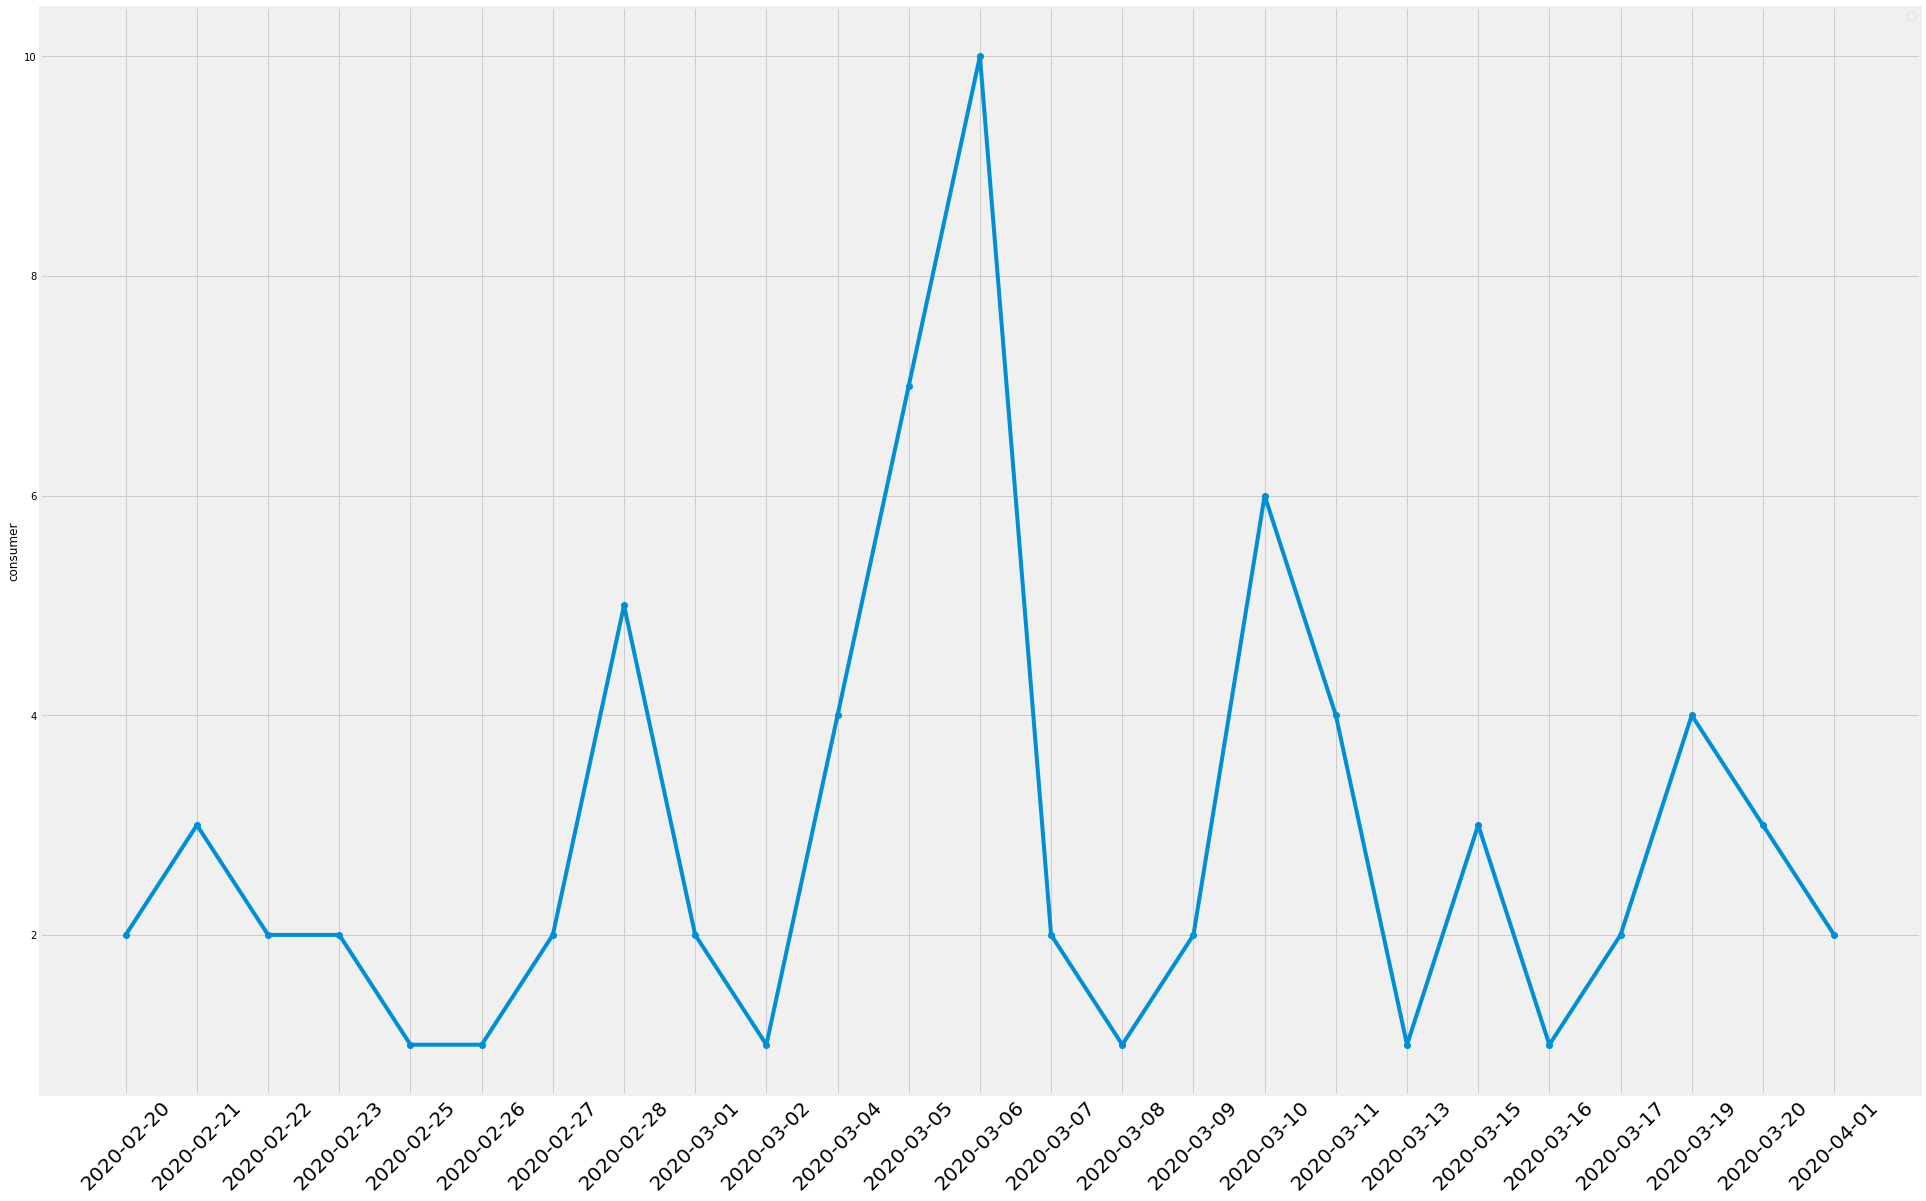

In [259]:
date = elders_date['index'] #날짜 column
conNum = elders_date['confirmed_date'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [30, 10] # [width, height]

xbefore=date[0:25] 
ybefore=conNum[0:25]
plt.plot(xbefore, ybefore, marker='o')

plt.xticks(rotation=45, fontsize=20) #x축 글자 기울이기
plt.ylabel("consumer")
plt.legend()
plt.show()

**밀집 장소에서 발생된 감염사건 자체가 행정명령 이전 Case만 존재하여, 제한명령 이후 확진자 분포와 비교할 수 없다.**  

그러므로, 결론을 노령층 확진 장소를 보았을 때 해당 법률의 필요성이 대두되었고, 제한명령 이후 고령층의 확진자 수가 감소하였으므로 유의미하다. 이런식으로 결론을 내야할 것으로 생각된다.

### 연령층
60대 이상만 살펴봤던 고령층을 다시 연령대로 나눠보자

In [294]:
elderspot_60 = elders_spot[elders_spot['age']==60]
elderspot_70 = elders_spot[elders_spot['age']==70]
elderspot_80 = elders_spot[elders_spot['age']==80]
elderspot_90 = elders_spot[elders_spot['age']==90]
elderspot_100 = elders_spot[elders_spot['age']==100]

elderspot_60.reset_index(inplace=True, drop=True)
elderspot_70.reset_index(inplace=True, drop=True)
elderspot_100.reset_index(inplace=True, drop=True)
elderspot_90.reset_index(inplace=True, drop=True)
elderspot_100.reset_index(inplace=True, drop=True)

In [296]:
elders_date60 = pd.DataFrame(elderspot_60['confirmed_date'].value_counts())
elders_date60.reset_index(inplace=True)
elders_date60 = elders_date60.sort_values(by=["index"]) 
elders_date60.reset_index(inplace=True, drop=True)
elders_date60.columns=['index', 'confirmed_date60']

elders_date70 = pd.DataFrame(elderspot_70['confirmed_date'].value_counts())
elders_date70.reset_index(inplace=True)
elders_date70 = elders_date70.sort_values(by=["index"]) 
elders_date70.reset_index(inplace=True, drop=True)
elders_date70.columns=['index', 'confirmed_date70']

elders_date80 = pd.DataFrame(elderspot_80['confirmed_date'].value_counts())
elders_date80.reset_index(inplace=True)
elders_date80 = elders_date80.sort_values(by=["index"]) 
elders_date80.reset_index(inplace=True, drop=True)
elders_date80.columns=['index', 'confirmed_date80']

elders_date90 = pd.DataFrame(elderspot_90['confirmed_date'].value_counts())
elders_date90.reset_index(inplace=True)
elders_date90 = elders_date90.sort_values(by=["index"]) 
elders_date90.reset_index(inplace=True, drop=True)
elders_date90.columns=['index', 'confirmed_date90']

elders_date100 = pd.DataFrame(elderspot_100['confirmed_date'].value_counts())
elders_date100.reset_index(inplace=True)
elders_date100 = elders_date100.sort_values(by=["index"]) 
elders_date100.reset_index(inplace=True, drop=True)
elders_date100.columns=['index', 'confirmed_date100']

In [306]:
age_date = pd.merge(elders_date80, elders_date60, on="index", how="outer") 
age_date = pd.merge(age_date, elders_date70, on="index", how="outer") 
age_date = pd.merge(age_date, elders_date90, on="index", how="outer") 
age_date = pd.merge(age_date, elders_date100, on="index", how="outer") 
age_date = age_date.replace(np.nan, 0)
age_date

index  confirmed_date80  confirmed_date60  confirmed_date70  \
0   2020-02-27               1.0               0.0               1.0   
1   2020-02-28               2.0               3.0               0.0   
2   2020-03-01               2.0               0.0               0.0   
3   2020-03-02               1.0               0.0               0.0   
4   2020-03-04               1.0               2.0               0.0   
5   2020-03-05               1.0               2.0               2.0   
6   2020-03-06               5.0               1.0               3.0   
7   2020-03-07               1.0               0.0               0.0   
8   2020-03-09               1.0               0.0               1.0   
9   2020-03-10               4.0               1.0               0.0   
10  2020-03-11               1.0               0.0               1.0   
11  2020-03-13               1.0               0.0               0.0   
12  2020-03-15               2.0               0.0               0.0   
13  2020-03-16               1.0               0.0               0.0   
14  2020-03-17               2.0               0.0               0.0   
15  2020-03-19               2.0               0.0               1.0   
16  2020-03-20               1.0               2.0               0.0   
17  2020-02-20               0.0               2.0               0.0   
18  2020-02-21               0.0               3.0               0.0   
19  2020-02-22               0.0               2.0               0.0   
20  2020-02-23               0.0               1.0               1.0   
21  2020-02-25               0.0               1.0               0.0   
22  2020-02-26               0.0               1.0               0.0   
23  2020-03-08               0.0               1.0               0.0   
24  2020-04-01               0.0               2.0               0.0   

    confirmed_date90  confirmed_date100  
0                0.0                0.0  
1                0.0                0.0  
2                0.0                0.0  
3                0.0                0.0  
4                1.0                0.0  
5                2.0                0.0  
6                1.0                0.0  
7                1.0                0.0  
8                0.0                0.0  
9                0.0                1.0  
10               2.0                0.0  
11               0.0                0.0  
12               1.0                0.0  
13               0.0                0.0  
14               0.0                0.0  
15               1.0                0.0  
16               0.0                0.0  
17               0.0                0.0  
18               0.0                0.0  
19               0.0                0.0  
20               0.0                0.0  
21               0.0                0.0  
22               0.0                0.0  
23               0.0                0.0  
24               0.0                0.0

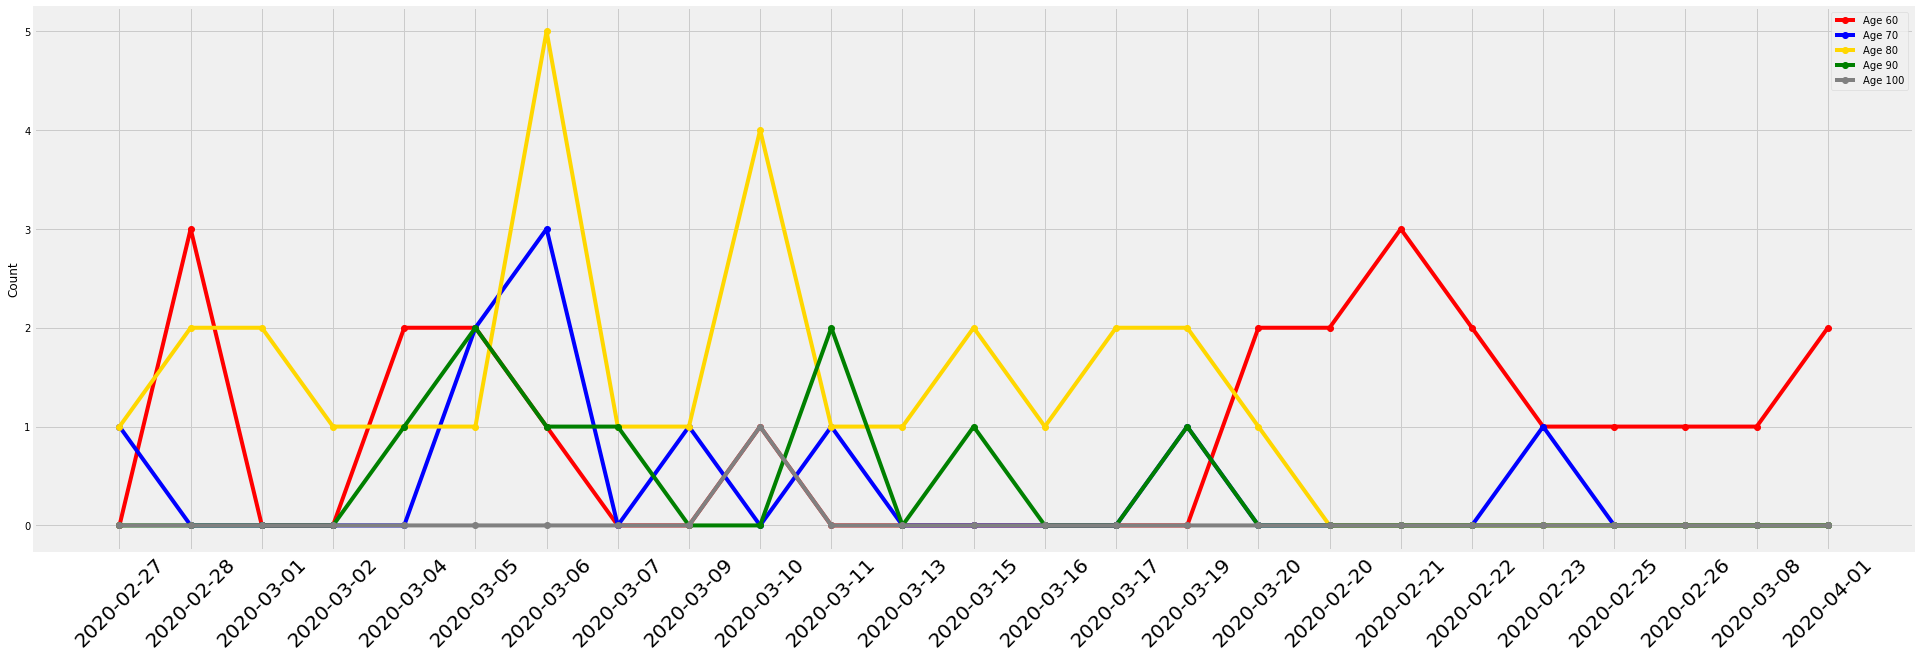

In [308]:
date60 = age_date['index'] #날짜 column
conNum60 = age_date['confirmed_date60'] #확진자수 column

date70 = age_date['index'] #날짜 column
conNum70 = age_date['confirmed_date70'] #확진자수 column

date80 = age_date['index'] #날짜 column
conNum80 = age_date['confirmed_date80'] #확진자수 column

date90 = age_date['index'] #날짜 column
conNum90 = age_date['confirmed_date90'] #확진자수 column

date100 = age_date['index'] #날짜 column
conNum100 = age_date['confirmed_date100'] #확진자수 column

plt.figure()
plt.rcParams['figure.figsize'] = [30, 10] # [width, height]

x1=date60[0:len(age_date)] 
y1=conNum60[0:len(age_date)]
plt.plot(x1, y1, marker='o', color = 'red', label='Age 60')

x2=date70[0:len(age_date)] 
y2=conNum70[0:len(age_date)]
plt.plot(x2, y2, marker='o', color = 'blue', label='Age 70')

x3=date80[0:len(age_date)] 
y3=conNum80[0:len(age_date)]
plt.plot(x3, y3, marker='o', color = 'gold', label='Age 80')

x4=date90[0:len(age_date)] 
y4=conNum90[0:len(age_date)]
plt.plot(x4, y4, marker='o', color = 'green', label='Age 90')

x5=date100[0:len(age_date)] 
y5=conNum100[0:len(age_date)]
plt.plot(x5, y5, marker='o', color = 'gray', label='Age 100')


plt.xticks(rotation=45, fontsize=20) #x축 글자 기울이기
plt.ylabel("Count")
plt.legend()
plt.show()

80대의 확진률이 가장 높다.

### 1. 지역별 노년인구 수

In [92]:
Region = Region[Region['province']!='Korea']

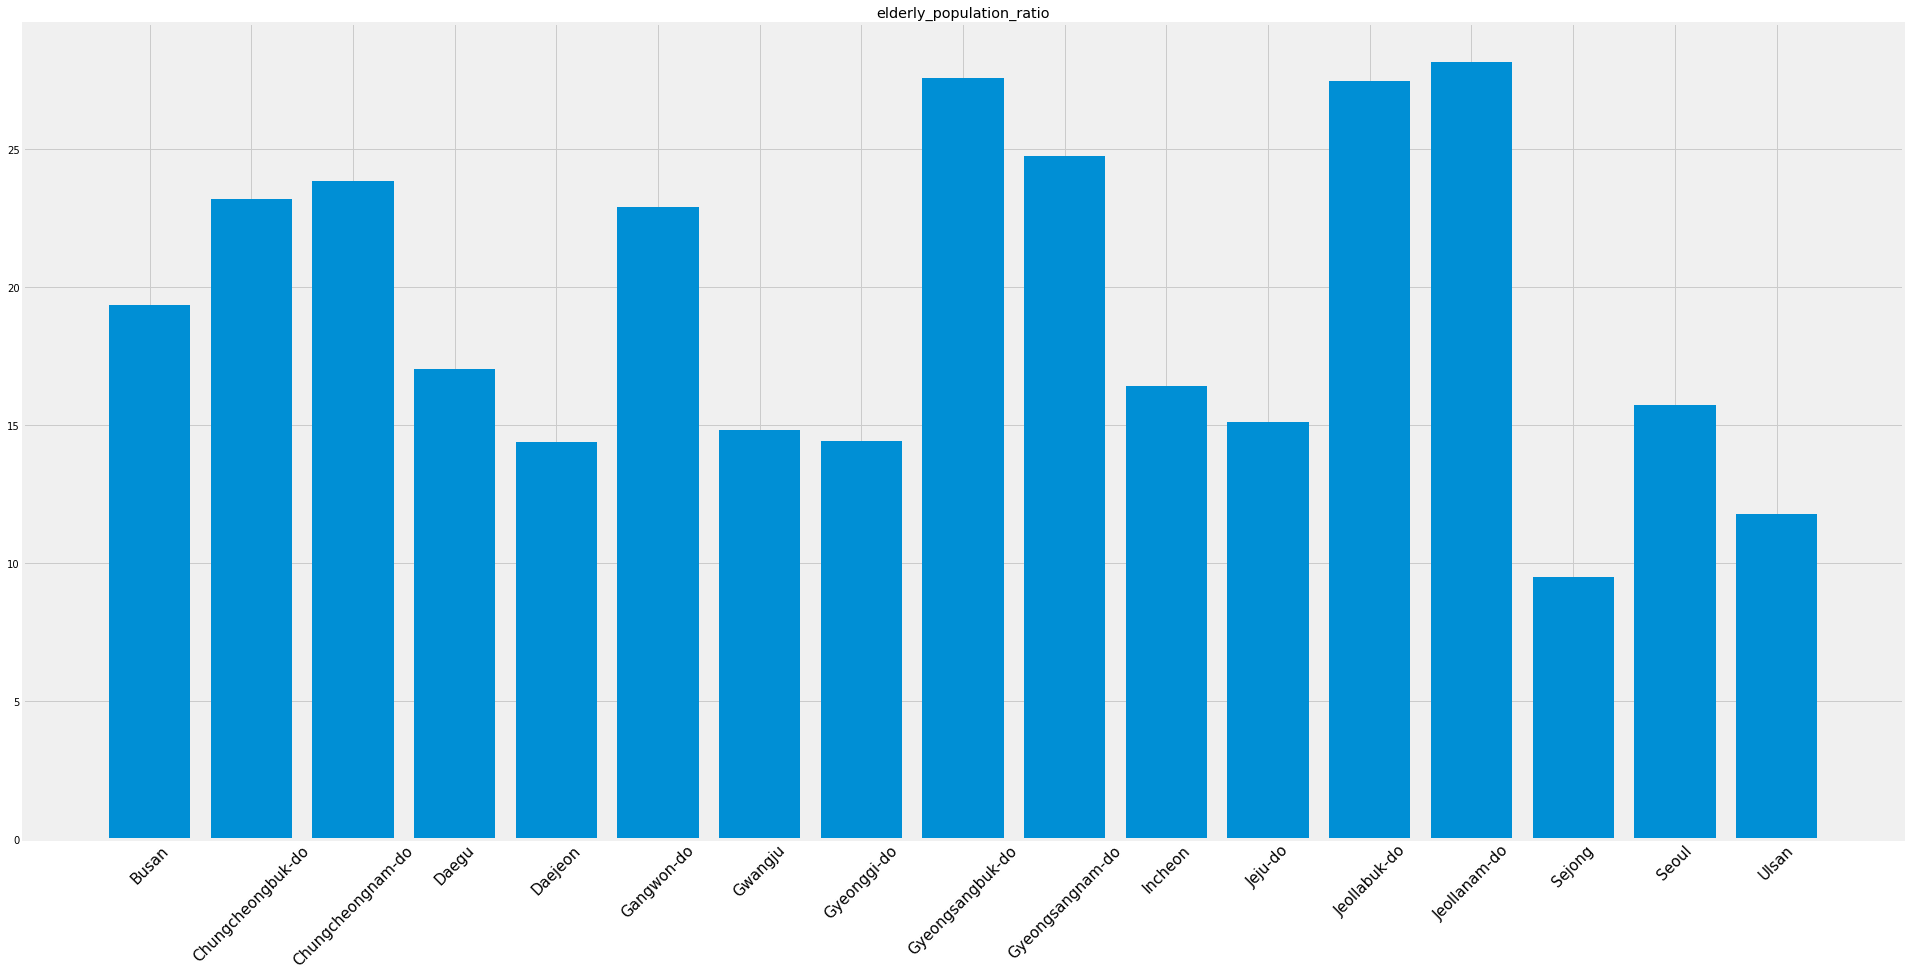

In [93]:
df_elepop_mean = Region.groupby(['province'], as_index=False).mean()
plt.bar(df_elepop_mean['province'],df_elepop_mean['elderly_population_ratio'])
plt.title('elderly_population_ratio')
plt.xticks(rotation=45, fontsize = 15)
plt.show()

독거노인 비율은 전라남도, 경상북도, 전라북도 순으로 많다.

In [94]:
Patientinfo['province'].unique()

array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Gyeonggi-do', 'Sejong', 'Ulsan', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

In [95]:
elder = ['Jeollabuk-do', 'Jeollanam-do', 'Gyeongsangbuk-do']

elder_df = Patientinfo[Patientinfo['province']=='Gyeongsangbuk-do']

for i in elder:
    tt = Patientinfo[Patientinfo['province']==i]
    elder_df = pd.concat([elder_df, tt], axis=0)
elder_df

patient_id     sex age country          province          city  \
3758  6001000001  female  20   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3760  6001000003  female  40   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3761  6001000004  female  50   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3762  6001000005  female  20   Korea  Gyeongsangbuk-do  Gyeongsan-si   
3763  6001000006  female  40   Korea  Gyeongsangbuk-do  Gyeongsan-si   
...          ...     ...  ..     ...               ...           ...   
5008  6023000049  female  30   Korea  Gyeongsangbuk-do     Pohang-si   
5009  6023000050    male  30   Korea  Gyeongsangbuk-do     Pohang-si   
5010  6023000051    male  20   Korea  Gyeongsangbuk-do     Pohang-si   
5011  6023000052    male  20   Korea  Gyeongsangbuk-do     Pohang-si   
5012  6023000053    male  20   Korea  Gyeongsangbuk-do     Pohang-si   

          infection_case infected_by contact_number symptom_onset_date  \
3758  Shincheonji Church  1200000031              7                NaN   
3760                 NaN         NaN              3                NaN   
3761                 NaN         NaN              5                NaN   
3762                 NaN         NaN              2                NaN   
3763                 NaN         NaN              9                NaN   
...                  ...         ...            ...                ...   
5008                 NaN         NaN            NaN                NaN   
5009                 NaN         NaN            NaN                NaN   
5010                 NaN         NaN            NaN                NaN   
5011                 NaN         NaN            NaN                NaN   
5012     overseas inflow         NaN            NaN                NaN   

     confirmed_date released_date deceased_date     state  
3758     2020-02-19    2020-04-09           NaN  released  
3760     2020-02-20    2020-03-06           NaN  released  
3761     2020-02-20    2020-03-25           NaN  released  
3762     2020-02-20    2020-03-18           NaN  released  
3763     2020-02-21    2020-03-14           NaN  released  
...             ...           ...           ...       ...  
5008     2020-03-17    2020-03-28           NaN  released  
5009     2020-03-29    2020-05-10           NaN  released  
5010     2020-03-26    2020-05-14           NaN  released  
5011     2020-04-04    2020-05-19           NaN  released  
5012     2020-06-02    2020-06-26           NaN  released  

[2560 rows x 14 columns]

In [96]:
b = elder_df[['patient_id', 'age', 'confirmed_date']].sort_values(by = 'confirmed_date').dropna(subset=['confirmed_date']).reset_index(drop=True)

b['number']=range(1,len(b)+1)
b['0'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['0'] if '0s' in b.age.iloc[: x].value_counts() else 0)
b['10'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['10'] if '10' in b.age.iloc[: x].value_counts() else 0)
b['20'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['20'] if '20' in b.age.iloc[: x].value_counts() else 0)
b['30'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['30'] if '30' in b.age.iloc[: x].value_counts() else 0)
b['40'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['40'] if '40' in b.age.iloc[: x].value_counts() else 0)
b['50'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['50'] if '50' in b.age.iloc[: x].value_counts() else 0)
b['60'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['60'] if '60' in b.age.iloc[: x].value_counts() else 0)
b['70'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['70'] if '70' in b.age.iloc[: x].value_counts() else 0)
b['80'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['80'] if '80' in b.age.iloc[: x].value_counts() else 0)
b['90'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['90'] if '90' in b.age.iloc[: x].value_counts() else 0)

#보기 좋게 confirmed date를 인덱스로 보내주기
b.set_index('confirmed_date')

patient_id age  number  0   10   20   30   40   50   60   70  \
confirmed_date                                                                 
2020-01-30      5000000001  60       1  0    0    0    0    0    0    1    0   
2020-02-06      5100000001  40       2  0    0    0    0    1    0    1    0   
2020-02-18      6015000001  40       3  0    0    0    0    2    0    1    0   
2020-02-18      6015000002  60       4  0    0    0    0    2    0    2    0   
2020-02-18      6015000001  40       5  0    0    0    0    3    0    2    0   
...                    ...  ..     ... ..  ...  ...  ...  ...  ...  ...  ...   
2020-06-28      6022000051  20    2550  0  115  633  193  274  452  358  195   
2020-06-28      5100000024  40    2551  0  115  633  193  275  452  358  195   
2020-06-28      6022000051  20    2552  0  115  634  193  275  452  358  195   
2020-06-29      6001000639  50    2553  0  115  634  193  275  453  358  195   
2020-06-29      6001000639  50    2554  0  115  634  193  275  454  358  195   

                 80  90  
confirmed_date           
2020-01-30        0   0  
2020-02-06        0   0  
2020-02-18        0   0  
2020-02-18        0   0  
2020-02-18        0   0  
...             ...  ..  
2020-06-28      216  65  
2020-06-28      216  65  
2020-06-28      216  65  
2020-06-29      216  65  
2020-06-29      216  65  

[2554 rows x 13 columns]

<Figure size 2160x1080 with 0 Axes>

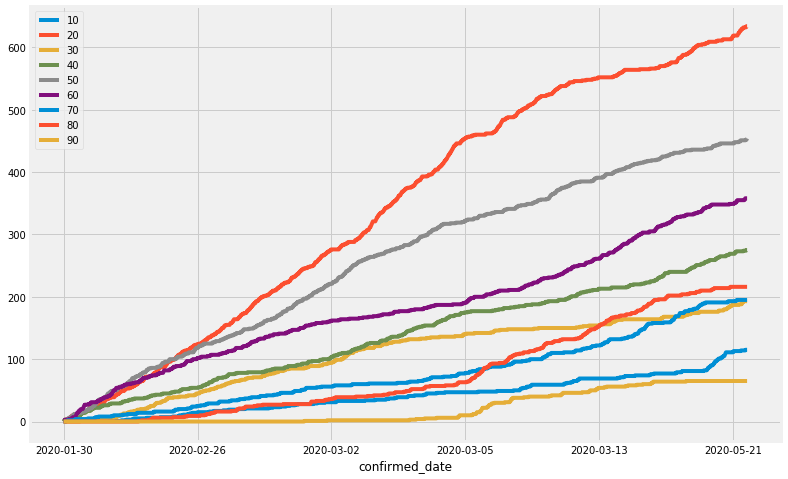

In [97]:
#연령대별 확진자수 추이 살펴보기
plt.figure()
b.plot(kind='line', y=['10', '20', '30', '40', '50', '60', '70', '80','90'], x='confirmed_date', figsize = (12,8))
plt.show()

<Figure size 2160x1080 with 0 Axes>

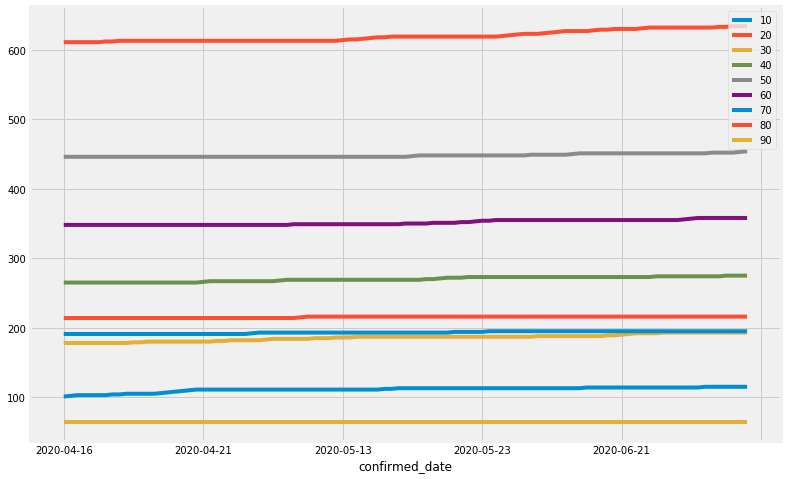

In [98]:
plt.figure()
b.loc[(b['confirmed_date']>='2020-04-16')].plot(kind='line', y=['10', '20', '30', '40', '50', '60', '70', '80','90'], x='confirmed_date', figsize=(12,8))
plt.show()

### 2. 지역별 요양원수

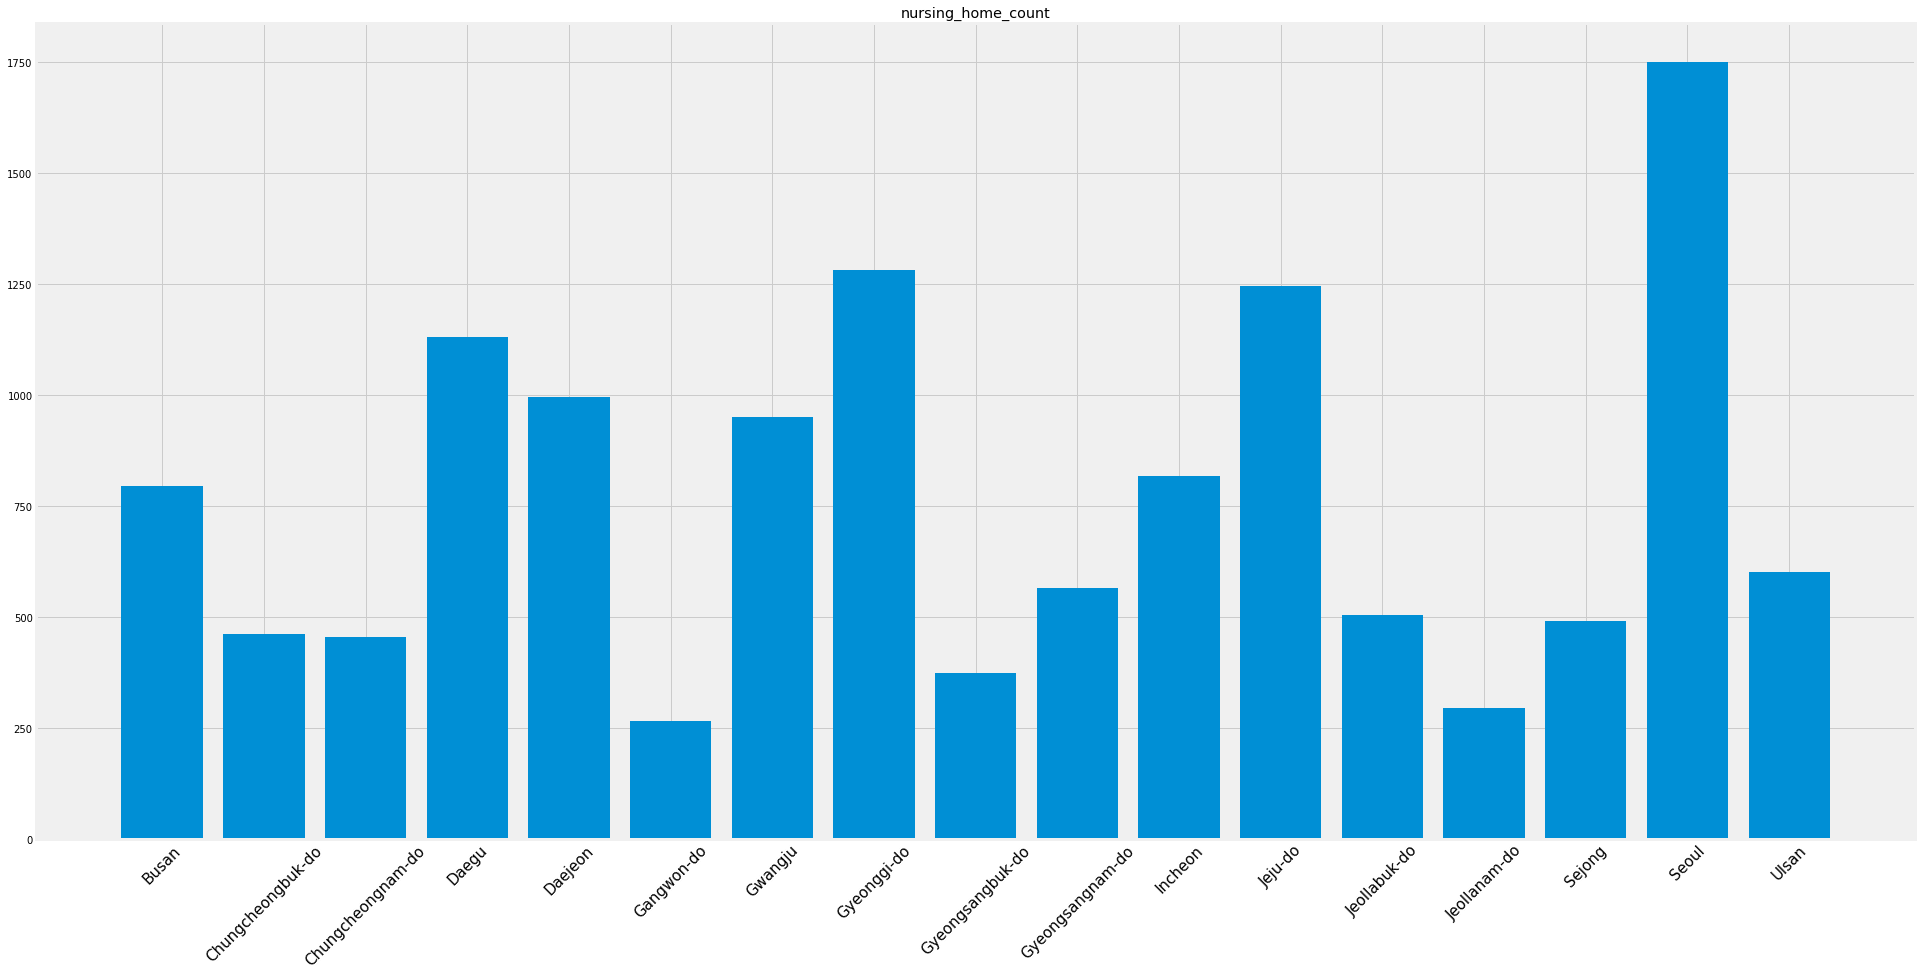

In [99]:
df_nursing_mean = Region.groupby(['province'], as_index=False).mean()
plt.bar(df_nursing_mean['province'],df_nursing_mean['nursing_home_count'])
plt.title('nursing_home_count')
plt.xticks(rotation=45, fontsize = 15)
plt.show()

서울, 경기도, 제주도 순으로 요양원의 수가 많다.

In [100]:
nursing = ['Gyeonggi-do', 'Jeju-do']

nursing_df = Patientinfo[Patientinfo['province']=='Seoul']

for i in nursing:
    tt = Patientinfo[Patientinfo['province']==i]
    nursing_df = pd.concat([elder_df, tt], axis=0)
nursing_df

patient_id     sex  age     country          province          city  \
3758  6001000001  female   20       Korea  Gyeongsangbuk-do  Gyeongsan-si   
3760  6001000003  female   40       Korea  Gyeongsangbuk-do  Gyeongsan-si   
3761  6001000004  female   50       Korea  Gyeongsangbuk-do  Gyeongsan-si   
3762  6001000005  female   20       Korea  Gyeongsangbuk-do  Gyeongsan-si   
3763  6001000006  female   40       Korea  Gyeongsangbuk-do  Gyeongsan-si   
...          ...     ...  ...         ...               ...           ...   
5160  7000000015  female   30       Korea           Jeju-do       Jeju-do   
5161  7000000016     NaN  NaN       Korea           Jeju-do       Jeju-do   
5162  7000000017     NaN  NaN  Bangladesh           Jeju-do       Jeju-do   
5163  7000000018     NaN  NaN  Bangladesh           Jeju-do       Jeju-do   
5164  7000000019     NaN  NaN  Bangladesh           Jeju-do       Jeju-do   

          infection_case infected_by contact_number symptom_onset_date  \
3758  Shincheonji Church  1200000031              7                NaN   
3760                 NaN         NaN              3                NaN   
3761                 NaN         NaN              5                NaN   
3762                 NaN         NaN              2                NaN   
3763                 NaN         NaN              9                NaN   
...                  ...         ...            ...                ...   
5160     overseas inflow         NaN             25                NaN   
5161     overseas inflow         NaN            NaN                NaN   
5162     overseas inflow         NaN             72                NaN   
5163     overseas inflow         NaN            NaN                NaN   
5164     overseas inflow         NaN            NaN                NaN   

     confirmed_date released_date deceased_date     state  
3758     2020-02-19    2020-04-09           NaN  released  
3760     2020-02-20    2020-03-06           NaN  released  
3761     2020-02-20    2020-03-25           NaN  released  
3762     2020-02-20    2020-03-18           NaN  released  
3763     2020-02-21    2020-03-14           NaN  released  
...             ...           ...           ...       ...  
5160     2020-05-30    2020-06-13           NaN  released  
5161     2020-06-16    2020-06-24           NaN  released  
5162     2020-06-18           NaN           NaN  isolated  
5163     2020-06-18           NaN           NaN  isolated  
5164     2020-06-18           NaN           NaN  isolated  

[2579 rows x 14 columns]

In [101]:
b = nursing_df[['patient_id', 'age', 'confirmed_date']].sort_values(by = 'confirmed_date').dropna(subset=['confirmed_date']).reset_index(drop=True)

b['number']=range(1,len(b)+1)
b['0'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['0'] if '0s' in b.age.iloc[: x].value_counts() else 0)
b['10'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['10'] if '10' in b.age.iloc[: x].value_counts() else 0)
b['20'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['20'] if '20' in b.age.iloc[: x].value_counts() else 0)
b['30'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['30'] if '30' in b.age.iloc[: x].value_counts() else 0)
b['40'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['40'] if '40' in b.age.iloc[: x].value_counts() else 0)
b['50'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['50'] if '50' in b.age.iloc[: x].value_counts() else 0)
b['60'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['60'] if '60' in b.age.iloc[: x].value_counts() else 0)
b['70'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['70'] if '70' in b.age.iloc[: x].value_counts() else 0)
b['80'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['80'] if '80' in b.age.iloc[: x].value_counts() else 0)
b['90'] = b['number'].apply(lambda x : b.age.iloc[: x].value_counts()['90'] if '90' in b.age.iloc[: x].value_counts() else 0)

#보기 좋게 confirmed date를 인덱스로 보내주기
b.set_index('confirmed_date')

patient_id age  number  0   10   20   30   40   50   60   70  \
confirmed_date                                                                 
2020-01-30      5000000001  60       1  0    0    0    0    0    0    1    0   
2020-02-06      5100000001  40       2  0    0    0    0    1    0    1    0   
2020-02-18      6015000002  60       3  0    0    0    0    1    0    2    0   
2020-02-18      6015000002  60       4  0    0    0    0    1    0    3    0   
2020-02-18      6015000001  40       5  0    0    0    0    2    0    3    0   
...                    ...  ..     ... ..  ...  ...  ...  ...  ...  ...  ...   
2020-06-28      5100000024  40    2569  0  117  639  197  277  452  358  195   
2020-06-28      6022000051  20    2570  0  117  640  197  277  452  358  195   
2020-06-28      6022000051  20    2571  0  117  641  197  277  452  358  195   
2020-06-29      6001000639  50    2572  0  117  641  197  277  453  358  195   
2020-06-29      6001000639  50    2573  0  117  641  197  277  454  358  195   

                 80  90  
confirmed_date           
2020-01-30        0   0  
2020-02-06        0   0  
2020-02-18        0   0  
2020-02-18        0   0  
2020-02-18        0   0  
...             ...  ..  
2020-06-28      216  65  
2020-06-28      216  65  
2020-06-28      216  65  
2020-06-29      216  65  
2020-06-29      216  65  

[2573 rows x 13 columns]

<Figure size 2160x1080 with 0 Axes>

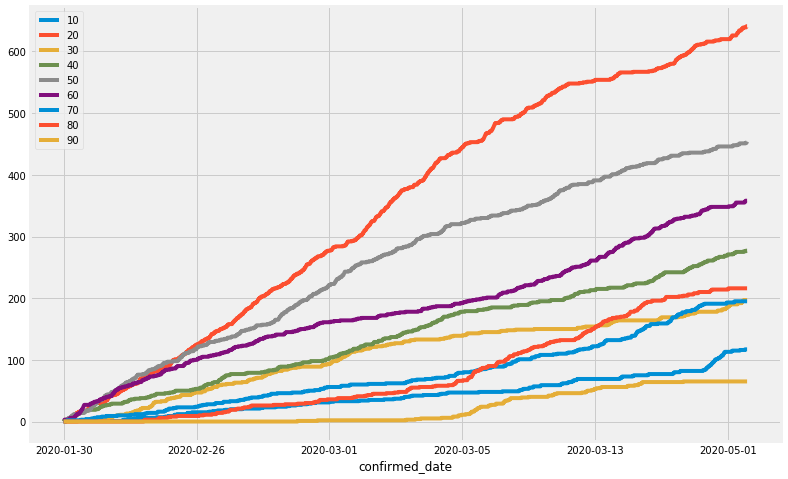

In [102]:
#연령대별 확진자수 추이 살펴보기
plt.figure()
b.plot(kind='line', y=['10', '20', '30', '40', '50', '60', '70', '80','90'], x='confirmed_date', figsize = (12,8))
plt.show()

<Figure size 2160x1080 with 0 Axes>

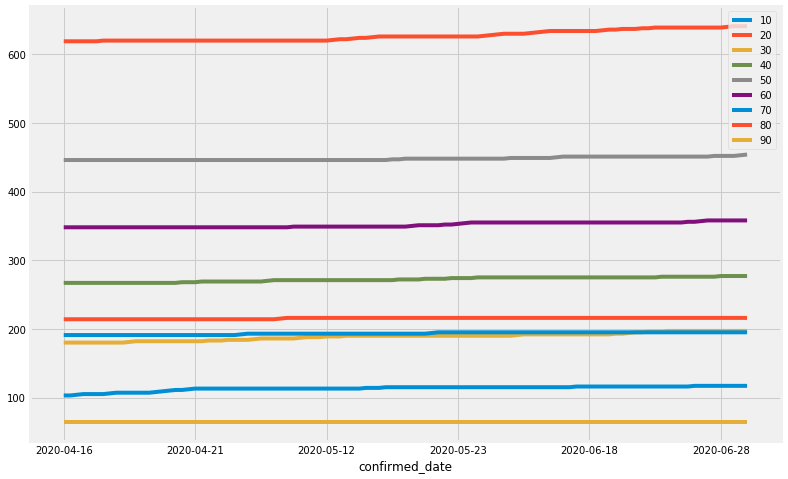

In [103]:
plt.figure()
b.loc[(b['confirmed_date']>='2020-04-16')].plot(kind='line', y=['10', '20', '30', '40', '50', '60', '70', '80','90'], x='confirmed_date', figsize=(12,8))
plt.show()

사망자 수 비율도 살펴보고 싶었으나, Patientinfo 데이터 셋에 5월 이후 deceased_date 변수는 결측치가 너무 많아 확인할 수 없었음. 